In [1]:
import numpy as np
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import itertools
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [5]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.walls = 1 - self._maze
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        self.coverage = np.zeros(self._maze.shape)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        self.coverage[nrow][ncol] += 1

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        rew = 0
        if rat_row == nrows-1 and rat_col == ncols-1:
          rew = 1.0
        if mode == 'blocked':
          rew = 0
        if (rat_row, rat_col) in self.visited:
          rew = 0.
        if mode == 'invalid':
          rew = 0.
        if mode == 'valid':
          rew = 0.

        return rew

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        canvas = 2 * (self._maze - canvas)
        envstate = np.stack([self._maze, self.walls, canvas], axis=0)
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [6]:
from IPython.display import clear_output
import time
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [10]:
class Network(nn.Module):
    def __init__(self, input_size, kernel_size, num_filters, out_features, device=device):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(int(num_filters*(input_size[0]-kernel_size+1)*(input_size[1]-kernel_size+1)/4), 32),
            nn.PReLU(),
            nn.Linear(32, out_features)

        )
        self.to(device)

    def forward(self, x):
        return self.net(x)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(device)
        q_values = self.forward(obs_t.unsqueeze(0))
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action

class DQNAgent():
    def __init__(self, env, epsilon_start, epsilon_end, epsilon_decay, gamma, lr):
        input_size = env.maze.shape
        out_features = 4
        kernel_size = 3
        num_filters = 6
        self.num_actions = out_features
        self.gamma = gamma
        self.targets = None
        self.action_qvalues = None
        self.online_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=lr)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.counter = 1

    def choose_action(self, time, obs):
        epsilon = np.interp(time, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = random.randrange(self.num_actions)
        else:
            action = self.online_net.act(obs)

        return action

    def calculate_target(self, new_obses_t, rews_t, dones_t, var):
        target_qvalues = self.target_net(new_obses_t)
        self.target_qvalues = target_qvalues

        max_val = target_qvalues.max().item() * var

        ### Method 1
        # means = target_qvalues.mean(axis=1).view(BATCH_SIZE, 1)
        # bias_vals = means - target_qvalues
        # for i in range(4):
        #   noise = torch.tensor(np.random.multivariate_normal(bias_vals[:, i].detach().cpu().numpy(), max_val * np.identity(BATCH_SIZE))).to(device)
        #   target_qvalues[:, i] += noise
        # max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 2
        noise = torch.from_numpy(np.random.normal(0, 10 * var, target_qvalues.size())).to(device)
        noisy_target_qvalues = target_qvalues + noise
        max_target_qvalues = noisy_target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 3
#         max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]
#         noise = torch.from_numpy(np.random.normal(0, 10 * var, max_target_qvalues.size())).to(device)
#         max_target_qvalues += noise

        if self.counter % 1000 == 0:
          print(self.online_net(new_obses_t)[0,:])
          for g in self.optimizer.param_groups:
            g['lr'] *= 0.85
            print(g['lr'])

        self.targets = rews_t + self.gamma * (1 - dones_t) * max_target_qvalues

    def calculate_action_qvalues(self, obses_t, actions_t):
        q_values = self.online_net(obses_t)
        self.action_qvalues = torch.gather(input=q_values, dim=1, index=actions_t)

    def optimize_network(self):
        loss = nn.functional.smooth_l1_loss(self.action_qvalues, self.targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [11]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 0.0001
EPSILON_END = 0.0001
EPSILON_DECAY = 5000
TARGET_UPDATE_FREQ = 200

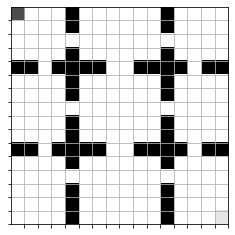

In [12]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
show(env)

trained 0.1-500 0 times - ep num = 0
tensor([5.6963, 5.5951, 5.6248, 5.5265], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([4.2552, 4.2514, 4.1729, 4.2525], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([3.2219, 3.1748, 3.1985, 3.2881], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999996
tensor([2.3882, 2.3797, 2.3495, 2.4242], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.26100312499999995
tensor([15.0162, 14.7470, 14.7127, 14.7517], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.22185265624999995


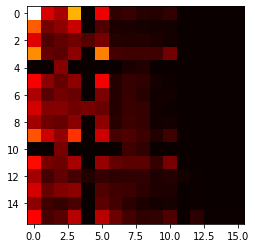

trained 0.1-500 0 times - ep num = 1
tensor([10.0127,  9.7801, 10.0778, 10.3230], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([7.9547, 7.3590, 7.7266, 7.3196], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([ 803.5318, -620.4091,  -70.3472,  437.4625], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1001.0810,  963.6686,  921.0519,  988.5474], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([629.1230, 629.1189, 630.4487, 636.8010], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


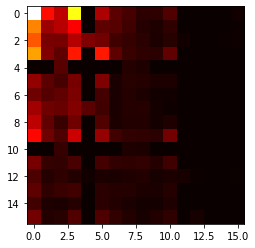

trained 0.1-500 0 times - ep num = 1
tensor([376.0490, 376.5605, 375.2384, 376.0515], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([258.0979, 256.1396, 261.5845, 249.3625], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([164.1799, 162.5582, 164.0227, 164.1180], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([99.2462, 99.0384, 99.2425, 98.9569], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([58.4258, 58.3334, 58.4187, 58.2883], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


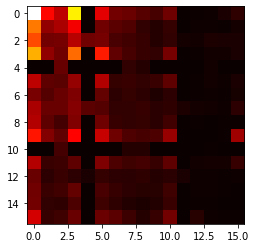

trained 0.1-500 0 times - ep num = 3
tensor([35.0637, 34.9027, 34.8556, 34.9853], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([21.0326, 20.8238, 20.8467, 21.1575], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([12.9226, 12.9980, 13.1241, 13.0805], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([7.9803, 7.9599, 7.7598, 7.9030], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([5.0783, 4.9046, 4.8031, 4.9245], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 0 times - ep num = 3
tensor([3.4152, 3.3928, 3.3248, 3.2217], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.4515, 2.4387, 2.4431, 2.4964], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.9144, 1.8955, 2.0944, 1.8056], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([27.1304, 27.

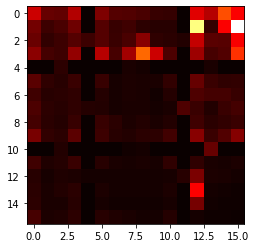

trained 0.1-500 0 times - ep num = 11
tensor([0.5760, 0.5065, 0.5979, 0.6295], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.4500, 0.4726, 0.4956, 0.4490], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.3807, 0.3760, 0.3658, 0.3334], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.5189, 0.6058, 0.5358, 0.6917], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.3862, 0.3981, 0.3633, 0.3844], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 0 times - ep num = 11
trained 0.1-500 1 times - ep num = 0
tensor([17813.4102, 17704.8594, 17992.5234, 16132.7051], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([10531.9717, 10721.7021, 10849.9043, 10373.9746], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([7060.9536, 6763.5977, 6424.1890, 6788.5864], device='cuda:0',
       grad

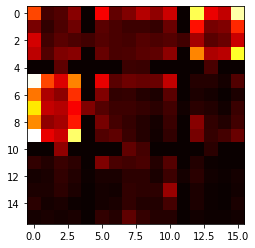

trained 0.1-500 1 times - ep num = 2
tensor([1723.7211, 1717.5521, 1709.9794, 1736.5295], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([1097.4630, 1092.2290, 1097.9111, 1097.4534], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([677.2451, 668.4836, 684.3667, 669.5494], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([426.2664, 459.6663, 400.1777, 428.4459], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([310.9429, 305.0622, 312.1496, 301.2535], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


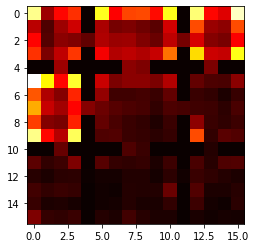

trained 0.1-500 1 times - ep num = 4
tensor([203.0370, 197.1779, 195.8279, 203.0531], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([ 72.3483, 146.7993,  84.9914,  78.9017], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([116.2374, 119.2418, 116.2570, 116.8990], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([71.9484, 71.5725, 71.8511, 71.6793], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([45.2256, 45.5622, 43.3903, 46.7606], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


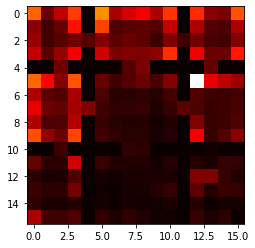

trained 0.1-500 1 times - ep num = 5
tensor([58.2198, 53.9037, 56.1796, 56.0124], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([46.6906, 47.9699, 48.4543, 47.7995], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([30.1741, 29.6119, 27.5893, 33.2400], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([18.4552, 28.5857, 15.3808, 14.5358], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([28.1000, 29.4029, 29.0141, 28.3930], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 1 times - ep num = 7
tensor([18.8567, 20.3040, 20.1014, 18.9440], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.6228, 13.7539, 13.6412, 13.3866], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([23.7822, 24.1580, 23.4826, 24.3299], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678


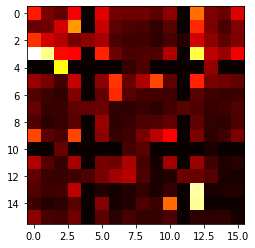

trained 0.1-500 1 times - ep num = 23
tensor([0.3829, 0.3407, 0.3495, 0.2328], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.1819, 0.2318, 0.1659, 0.3062], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.2551, 0.3244, 0.2738, 0.2933], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.2783, 0.2464, 0.2338, 0.2999], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.3040, 0.1721, 0.0989, 0.2834], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 1 times - ep num = 23
trained 0.1-500 2 times - ep num = 0
tensor([2.5397, 2.2643, 2.9767, 2.6831], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([2.6592, 2.6024, 2.7221, 2.5894], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([2.3124, 2.2817, 2.3767, 2.3392], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999996
te

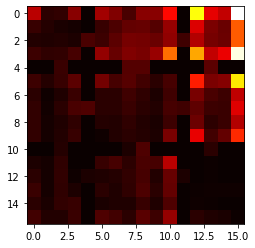

trained 0.1-500 2 times - ep num = 1
tensor([1.2123, 1.2388, 1.2523, 1.2430], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([  411.1559, 22917.5527,  -544.6962, -7826.7207], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([7670.9146, 7750.1104, 7516.1929, 7504.4370], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([4318.1304, 4354.9150, 4291.8652, 4273.6626], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([2716.6445, 2711.2349, 2714.5063, 2724.0439], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


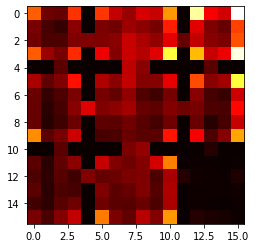

trained 0.1-500 2 times - ep num = 2
tensor([1610.6292, 1628.2424, 1622.4333, 1623.3807], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([1001.1411, 1006.5020, 1009.7457, 1006.3272], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([556.6470, 566.4065, 534.8753, 551.2205], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([357.5269, 358.5413, 359.4768, 358.8448], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([213.0563, 211.5219, 212.8946, 211.6335], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


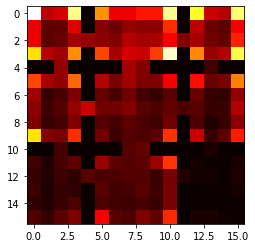

trained 0.1-500 2 times - ep num = 4
tensor([125.5270, 125.2685, 125.2063, 125.0735], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([73.6841, 74.0865, 73.9369, 74.0368], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([45.3618, 45.2860, 45.4655, 45.4273], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([26.9255, 26.7853, 26.8860, 26.8607], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([16.2396, 16.1384, 16.1589, 16.0935], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 2 times - ep num = 6
tensor([9.8242, 9.7033, 9.8679, 9.7819], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([6.1489, 5.9302, 6.1240, 6.0577], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([3.6485, 3.6819, 3.6448, 3.6613], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([

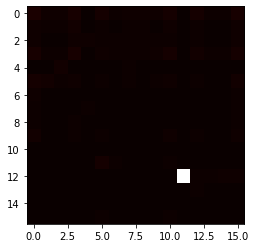

trained 0.1-500 2 times - ep num = 7
tensor([0.1215, 0.1164, 0.1226, 0.1230], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.0266, 0.0538, 0.0409, 0.0550], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.1156, 0.1138, 0.1235, 0.1222], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.1125, 0.1147, 0.1142, 0.1113], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.0758, 0.0895, 0.0810, 0.0854], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 2 times - ep num = 7
trained 0.1-1000 0 times - ep num = 0
tensor([20.4970, 20.4000, 20.2626, 20.8427], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([13.7305, 13.7296, 13.9013, 13.7286], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([9.2897, 9.2971, 9.3481, 9.3739], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070624999999

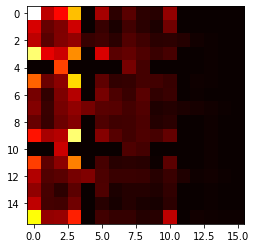

trained 0.1-1000 0 times - ep num = 1
tensor([5.8104, 4.1372, 6.0545, 5.9938], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([4.5184, 4.6704, 4.6611, 4.6973], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([4.1721, 4.1496, 4.2017, 4.2241], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([3.0118, 3.2965, 3.6675, 4.0888], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([ 3.5480, -2.2216,  4.4574,  3.7752], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


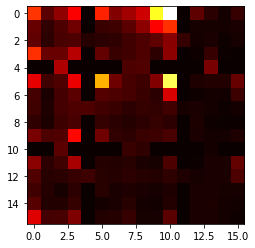

trained 0.1-1000 0 times - ep num = 4
tensor([11.3220, 11.3204, 11.3242, 11.3085], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([6.9675, 6.9264, 6.9916, 6.9373], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([4.4221, 4.4076, 4.4552, 4.4013], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([2.9514, 2.9471, 2.9539, 2.9589], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([2.2233, 2.2354, 2.1676, 2.3570], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


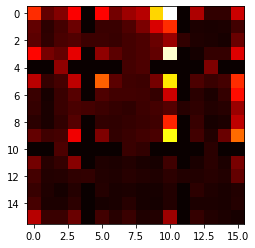

trained 0.1-1000 0 times - ep num = 12
tensor([32.5024, 34.1971, 23.5208, 31.0173], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([25.1889, 28.9271, 30.6671, 21.8925], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([18.4095, 18.1393, 18.1152, 18.5238], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([12.6861, 12.4110, 12.2949, 12.3377], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([7.9109, 7.5231, 7.2577, 7.5677], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 0 times - ep num = 13
tensor([6.2855, 1.8085, 5.1281, 6.6975], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([5.3527, 5.3334, 5.3270, 5.3979], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([3.4277, 3.4589, 3.4761, 3.4765], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.96

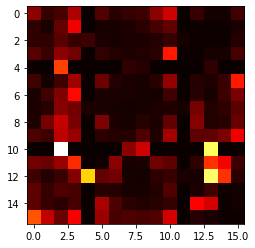

trained 0.1-1000 0 times - ep num = 14
tensor([0.2340, 0.2034, 0.2142, 0.2254], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.2730, 0.3018, 0.2919, 0.2822], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.2502, 0.2758, 0.2989, 0.2570], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.3519, 0.3539, 0.4003, 0.2998], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.2235, 0.2499, 0.2217, 0.2456], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 0 times - ep num = 14
trained 0.1-1000 1 times - ep num = 0
tensor([3.4971, 3.5392, 3.7063, 3.5135], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([5514.9805, 3645.3726, 3924.5190, 4689.8403], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([2969.3706, 2902.1018, 2996.3032, 2942.1677], device='cuda:0',
       grad_fn=<SliceBackwar

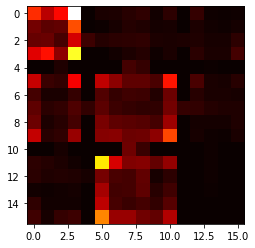

trained 0.1-1000 1 times - ep num = 0
tensor([1028.9950, 1044.5134, 1024.0867, 1024.2999], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([691.9631, 675.3110, 691.0223, 711.4892], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([416.5092, 411.1042, 415.9359, 417.9139], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([261.5874, 259.1405, 259.7784, 259.3500], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([159.4460, 159.6868, 160.0390, 159.1108], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


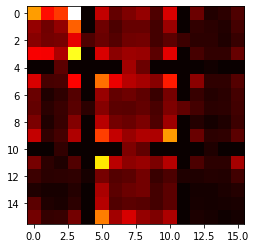

trained 0.1-1000 1 times - ep num = 6
tensor([81.6026, 84.2073, 83.4157, 84.5629], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([54.0699, 54.5030, 56.2276, 51.2207], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([51.7699, 50.7092, 50.9741, 48.5581], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([34.5012, 31.5523, 32.0110, 33.3721], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([69.1014, 67.8547, 67.9607, 67.8531], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


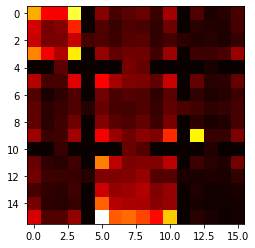

trained 0.1-1000 1 times - ep num = 8
tensor([41.7769, 41.8476, 41.6736, 41.5509], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([103.3016, 101.2208, 102.2663, 101.6585], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([73.3577, 76.4748, 73.6636, 73.5557], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([47.3580, 47.2749, 47.2460, 47.2819], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([28.3530, 27.6300, 27.9280, 28.6443], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 1 times - ep num = 11
tensor([16.6581, 15.9780, 14.4858, 15.5930], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.3573, 11.7458, 13.1844, 13.1825], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([ 9.7878,  9.7266, 10.4722,  9.4026], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513

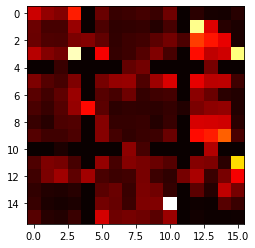

trained 0.1-1000 1 times - ep num = 13
tensor([0.3709, 0.3262, 0.4029, 0.3868], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.4167, 0.3974, 0.3978, 0.3971], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.1951, 0.2999, 0.2913, 0.2854], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.4389, 0.3827, 0.4066, 0.3376], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.4398, 0.3956, 0.4258, 0.3713], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 1 times - ep num = 13
trained 0.1-1000 2 times - ep num = 0
tensor([7578.0835, 6757.3516, 7330.8857, 7177.6416], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([6212.7529, 5946.0581, 5857.6855, 6092.8228], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([3871.2798, 3764.3052, 3844.3003, 3937.7935], device='cuda:0',
       grad_fn=<

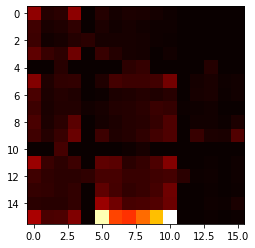

trained 0.1-1000 2 times - ep num = 2
tensor([1797.5359, 1761.0931, 1795.2601, 1799.3105], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([1096.4762, 1088.9906, 1113.9603, 1109.0112], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([695.0338, 695.1331, 698.3911, 694.1522], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([544.9781, 480.0532, 494.9304, 486.5914], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([377.5462, 378.0006, 374.7241, 376.2480], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


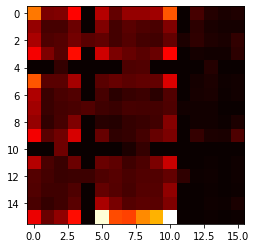

trained 0.1-1000 2 times - ep num = 2
tensor([231.5714, 232.9133, 231.0900, 232.5974], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([ 84.8893, 104.8049,  92.0061,  94.2938], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([104.7120, 100.9849, 101.9373, 105.4035], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([66.3615, 66.4166, 66.4060, 66.6430], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([40.0203, 39.9511, 39.9437, 39.4037], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


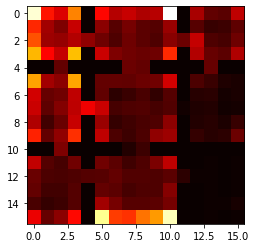

trained 0.1-1000 2 times - ep num = 2
tensor([24.8606, 24.3341, 24.6102, 24.1804], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([15.4595, 15.1675, 15.2731, 14.9756], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([10.2302, 10.2240, 10.3230, 10.0208], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([6.5029, 6.1949, 6.7257, 6.5911], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([3.9264, 5.1056, 4.5398, 5.0981], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 2 times - ep num = 3
tensor([3.9223, 4.8418, 4.5745, 4.0595], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([3.5330, 3.2150, 3.2575, 3.6195], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.8186, 2.2214, 2.6353, 2.6657], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.6336, 2.

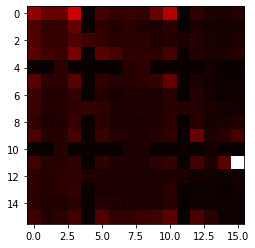

trained 0.1-1000 2 times - ep num = 21
tensor([0.3158, 0.3013, 0.3033, 0.3026], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.1736, 0.1883, 0.1859, 0.1648], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.1626, 0.2000, 0.1835, 0.1809], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.1826, 0.1781, 0.1882, 0.1809], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.1363, 0.1504, 0.1484, 0.1371], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 2 times - ep num = 21
trained 0.1-5000 0 times - ep num = 0
tensor([3.6452, 3.5227, 3.8026, 3.4803], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([81.6528, 82.8927, 87.4321, 91.1400], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([65.9153, 65.7494, 66.4234, 66.0760], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.307062499

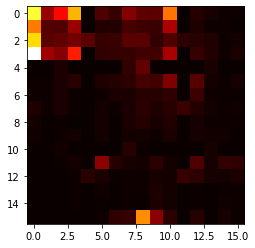

trained 0.1-5000 0 times - ep num = 4
tensor([  491.4933, -1599.8712,  1088.8966,  3963.5552], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([2596.6587, 2405.1687, 2259.8557, 2350.9756], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1677.1516, 1743.9808, 1678.6206, 1687.7410], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1587.4908, 1644.1285, 1394.3192, 1280.1761], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([1194.8575, 1219.3871, 1148.4965, 1264.7731], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


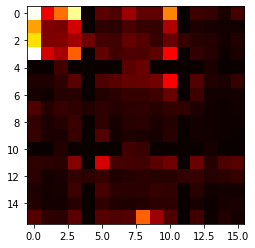

trained 0.1-5000 0 times - ep num = 8
tensor([835.5423, 832.8791, 851.6138, 816.6701], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([ 713.2077, 1259.8300,  685.5655,  716.0316], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([435.4626, 451.1047, 461.1263, 438.6417], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([262.4239, 260.6163, 261.9151, 264.2165], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([176.7444, 181.8263, 174.7286, 179.3179], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


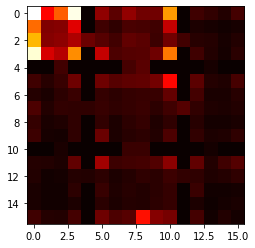

trained 0.1-5000 0 times - ep num = 11
tensor([139.3558, 137.5950, 135.0965, 138.1257], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([77.6667, 77.6434, 77.9160, 77.8666], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([46.7817, 46.7477, 46.5457, 46.8093], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([33.2372, 33.9421, 33.7171, 33.4388], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([23.7860, 24.4037, 24.2055, 24.3179], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 0 times - ep num = 12
tensor([16.0780, 16.0991, 15.6534, 16.7847], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([10.4859, 10.4781, 10.6129, 10.4733], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([7.7135, 7.9148, 7.8889, 7.8950], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638

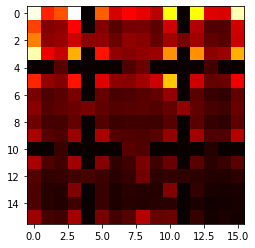

trained 0.1-5000 0 times - ep num = 22
tensor([0.8715, 0.8708, 0.8577, 0.8479], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9676, 0.9809, 0.9672, 0.9616], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8846, 0.9203, 0.8855, 0.8969], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.7954, 0.8195, 0.8267, 0.8330], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8568, 0.8754, 0.8664, 0.8254], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 0 times - ep num = 22
trained 0.1-5000 1 times - ep num = 0
tensor([ 95.6277, 100.5926, 102.5834, 101.0605], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([53.8645, 54.4386, 54.2696, 54.3298], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([35.7536, 35.8466, 35.8157, 35.7478], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3

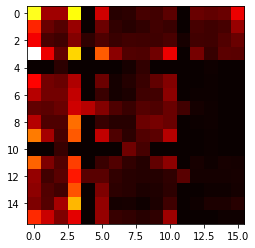

trained 0.1-5000 1 times - ep num = 2
tensor([13.0722, 12.8197, 13.0211, 12.9011], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([110.8996,  87.0095,  90.4060, 109.0427], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([81.9394, 85.2845, 84.5327, 82.9825], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([55.9014, 55.7714, 55.8546, 55.9037], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([34.8869, 34.8793, 34.8460, 34.8010], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


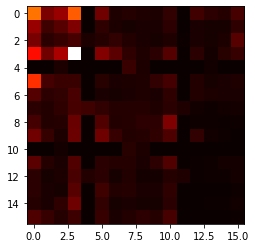

trained 0.1-5000 1 times - ep num = 5
tensor([21.8869, 21.8319, 21.8134, 21.8807], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([14.0879, 14.3456, 13.8606, 14.1658], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([433.9049, 436.9400, 428.9390, 437.8635], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([256.5577, 268.7152, 273.9518, 276.1797], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([242.8868, 240.0916, 248.2836, 238.9608], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


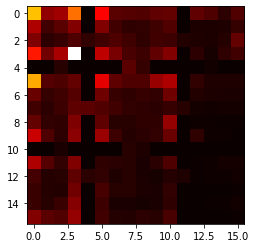

trained 0.1-5000 1 times - ep num = 5
tensor([171.4251, 168.9265, 169.9454, 170.7225], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([105.1771, 103.8436, 105.6759, 104.6776], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([71.8690, 71.6530, 72.1380, 71.9891], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([43.5251, 43.8987, 43.6142, 43.8720], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([42.5824, 43.6481, 42.7942, 42.5702], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 1 times - ep num = 6
tensor([26.0531, 26.0376, 25.6409, 25.7740], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([15.3734, 15.6803, 15.6391, 15.6881], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([11.0028, 11.3841, 11.5040, 10.8494], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598

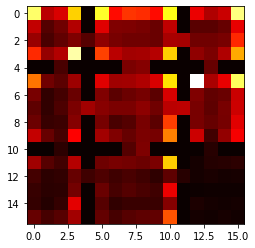

trained 0.1-5000 1 times - ep num = 17
tensor([0.9813, 0.9616, 1.0084, 0.9626], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.8853, 0.8891, 0.9015, 0.9135], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8140, 0.8249, 0.8509, 0.8002], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.8218, 0.8087, 0.8354, 0.8196], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8030, 0.8317, 0.8104, 0.7970], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 1 times - ep num = 19
trained 0.1-5000 2 times - ep num = 0
tensor([  28661.6367,  -89713.1953, -120169.0078,   -3635.9546],
       device='cuda:0', grad_fn=<SliceBackward0>)
0.425
tensor([-260.4403, -277.3191, -255.4893, -209.3654], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-91.1953, -92.5697, -90.3360, -90.9648], device='cuda:0',
       g

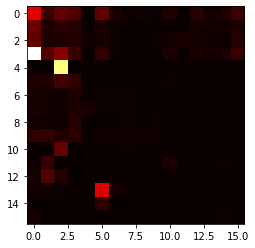

trained 0.1-5000 2 times - ep num = 1
tensor([-13.6941, -13.6663, -13.5937, -13.6243], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-6.1131, -6.2357, -6.2382, -6.0637], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-1.6031, -1.7077, -1.6480, -1.6593], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([0.9541, 1.2754, 0.9442, 1.0596], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([2.6101, 2.5201, 2.7047, 2.5143], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


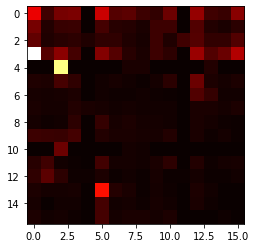

trained 0.1-5000 2 times - ep num = 2
tensor([2.9068, 2.9954, 3.0346, 2.9975], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([3.2495, 2.9890, 2.8900, 3.0015], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([3.2323, 3.1050, 3.2480, 3.2898], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([3.3318, 3.0201, 3.1887, 3.3541], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([3.3777, 3.2354, 3.2062, 3.1947], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


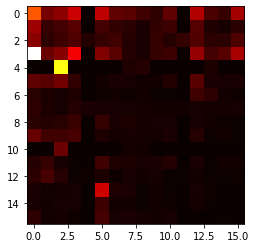

trained 0.1-5000 2 times - ep num = 2
tensor([2.9913, 2.9773, 2.9112, 2.9995], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([ 9.1412, 10.0632, 10.4078,  9.3780], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([61.9550, 48.4451, 53.6021, 55.1727], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([31.0850, 32.6385, 31.9641, 31.9476], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([21.2774, 20.4273, 20.8513, 21.7889], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 2 times - ep num = 3
tensor([12.6855, 12.7793, 12.8590, 12.9187], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([8.7437, 9.8640, 8.8738, 9.7880], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([7.2747, 6.8105, 7.8969, 6.2309], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([5.

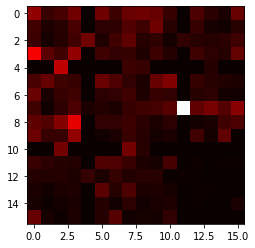

trained 0.1-5000 2 times - ep num = 5
tensor([0.9485, 0.9589, 1.0411, 0.8558], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.8754, 0.9794, 0.9069, 0.9178], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8202, 0.8102, 0.8416, 0.8409], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.7700, 0.8190, 0.8201, 0.8450], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8379, 0.8715, 0.8838, 0.7866], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 2 times - ep num = 5
trained 0.5-500 0 times - ep num = 0
tensor([ -93.7384,  936.9861, 1211.3398,  972.3979], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([4445.2393, 4217.3276, 4082.1865, 4183.5811], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([3267.2454, 3367.6199, 3290.9680, 3389.8975], device='cuda:0',
       grad_fn=<Sli

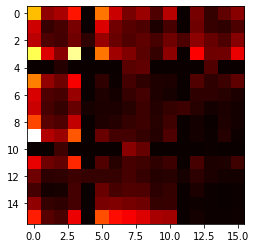

trained 0.5-500 0 times - ep num = 2
tensor([179.8605, 181.9977, 182.4813, 183.8526], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([114.0286, 114.0800, 114.2012, 113.7405], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([69.0246, 68.9468, 69.0269, 69.0314], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([41.8707, 41.9831, 41.7290, 41.8736], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([25.7713, 25.7167, 25.7902, 25.8090], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


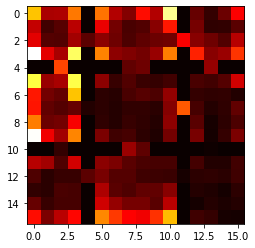

trained 0.5-500 0 times - ep num = 4
tensor([16.2869, 16.3356, 16.0674, 16.1166], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([17.8778, 17.9299, 17.9926, 17.8288], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([11.8227, 11.8775, 11.8511, 11.8029], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([7.6546, 7.7101, 7.6662, 7.6891], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([5.1911, 5.2093, 5.2308, 5.1667], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


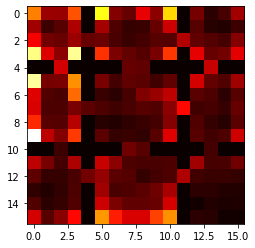

trained 0.5-500 0 times - ep num = 5
tensor([3.6973, 3.6679, 3.6535, 3.6727], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([2.8536, 2.8992, 2.9021, 2.8208], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([ 0.0324,  2.4274, -1.5694, -6.8426], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([5.6372, 5.6314, 5.6242, 5.6308], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([3.7683, 3.8071, 3.8004, 3.8061], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 0 times - ep num = 6
tensor([2.6659, 2.6718, 2.6605, 2.6766], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.0118, 2.0335, 2.0345, 2.0070], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.6287, 1.6128, 1.6462, 1.6438], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([1.4056, 1.3895, 1.30

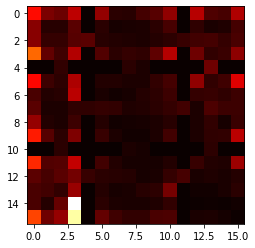

trained 0.5-500 0 times - ep num = 19
tensor([0.4798, 0.4777, 0.4729, 0.4736], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.4613, 0.4631, 0.4610, 0.4621], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.4542, 0.4548, 0.4559, 0.4526], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.4459, 0.4481, 0.4453, 0.4471], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.4380, 0.4368, 0.4361, 0.4370], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 0 times - ep num = 20
trained 0.5-500 1 times - ep num = 0
tensor([13.1451, 12.8586, 13.0515, 13.2648], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([9278.1113, 9047.9961, 9265.5977, 8843.2715], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([5785.9521, 5705.5859, 6164.7954, 5920.5552], device='cuda:0',
       grad_fn=<SliceBackwa

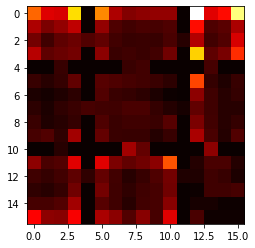

trained 0.5-500 1 times - ep num = 2
tensor([ 21550.5371, -15697.5342,   -218.4359,  -3118.8850], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([4302.6187, 4375.8813, 4318.2729, 4373.1392], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([2516.3220, 2427.9165, 2478.1267, 2508.7300], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1623.2006, 1627.4340, 1583.0432, 1616.0764], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([ 981.2142,  996.6575, 1005.6759,  983.3653], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


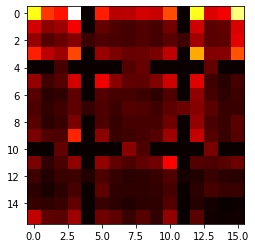

trained 0.5-500 1 times - ep num = 4
tensor([718.4558, 713.5433, 696.9725, 717.9717], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([438.4244, 438.8124, 434.4738, 434.6744], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([261.8657, 263.8105, 260.2387, 258.4784], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([155.0418, 156.4114, 155.4651, 155.5245], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([95.4111, 95.0141, 95.0572, 94.9879], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


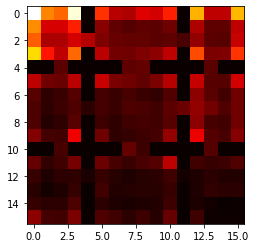

trained 0.5-500 1 times - ep num = 4
tensor([56.7729, 56.9331, 56.8963, 57.3454], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([14.6357, 86.6024, 47.9915, 61.8636], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([61.4989, 66.4924, 48.1815, 53.8343], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([39.5931, 38.9758, 39.1424, 37.0065], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([25.6546, 17.4107, 24.0658, 15.1883], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 1 times - ep num = 6
tensor([27.8992, 27.7481, 27.9568, 26.5506], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([18.2664, 16.5314, 17.5936, 14.8576], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([18.2429, 18.5661, 18.0230, 18.4721], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678


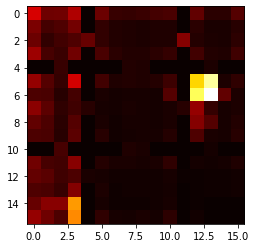

trained 0.5-500 1 times - ep num = 6
tensor([0.8371, 0.7582, 0.8411, 0.8012], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.8877, 0.9377, 0.8572, 0.7704], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.7288, 0.5668, 0.6470, 0.6937], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.4996, 0.7175, 0.5456, 0.6511], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.6902, 0.7344, 0.7010, 0.7343], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 1 times - ep num = 6
trained 0.5-500 2 times - ep num = 0
tensor([13.0040, 13.1154, 13.5898, 13.8887], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([3660.2900, 3385.2153, 3550.0549, 3605.2791], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([2292.6472, 2302.6150, 2339.9358, 2357.1299], device='cuda:0',
       grad_fn=<SliceBackward

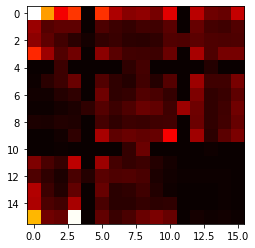

trained 0.5-500 2 times - ep num = 1
tensor([-3.8848, -8.1590, -6.7964, -8.5590], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-2.4492, -2.2559, -2.3326, -2.2591], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-0.1120, -0.1168, -0.1096, -0.1587], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1.0014, 0.9668, 1.0320, 1.1020], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([1.6241, 1.6166, 1.6409, 1.7110], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


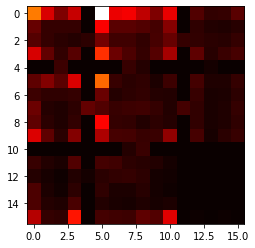

trained 0.5-500 2 times - ep num = 1
tensor([1.9289, 1.9703, 1.9985, 2.0149], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([1.9766, 2.1624, 2.0636, 1.9266], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([164.5816, 170.2336, 186.5172, 198.0879], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([202.9045, 185.1996, 181.4817, 126.5316], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([364.3985, 330.9135, 320.5461, 358.7647], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


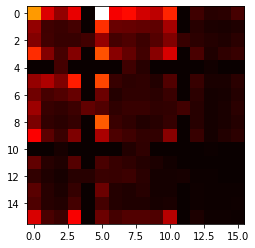

trained 0.5-500 2 times - ep num = 3
tensor([501.5124, 496.8707, 493.9336, 463.8474], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([305.8814, 303.0149, 306.6651, 304.1685], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([192.7627, 191.3397, 190.4636, 194.4693], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([117.3998, 117.0821, 117.5873, 116.9132], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([69.3347, 69.2633, 69.6278, 69.7468], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 2 times - ep num = 5
tensor([41.8920, 41.8453, 41.9299, 41.7385], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([27.6712, 25.1775, 27.7447, 25.8104], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([19.2247, 19.2352, 19.0051, 19.2767], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011

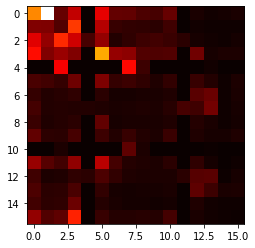

trained 0.5-500 2 times - ep num = 17
tensor([0.6675, 0.6855, 0.6994, 0.7050], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.5189, 0.7271, 0.7585, 0.5804], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.3838, 0.4739, 0.3920, 0.4596], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.2724, 0.3618, 0.5685, 0.4504], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.5315, 0.5078, 0.5190, 0.5189], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 2 times - ep num = 17
trained 0.5-1000 0 times - ep num = 0
tensor([  83.9282,  243.3789, -130.7973,  -70.4533], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([251.2468, 225.2524, 266.5802, 254.7709], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([151.3274, 151.2888, 151.3909, 151.1036], device='cuda:0',
       grad_fn=<SliceBackw

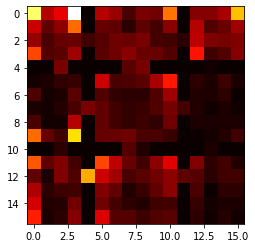

trained 0.5-1000 0 times - ep num = 2
tensor([87.3735, 86.9710, 87.4028, 87.2071], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([56.7053, 54.8202, 54.8622, 55.0045], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([35.9664, 36.2947, 36.4955, 36.7748], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([65.6407, -4.3036, 72.9845, 17.8306], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([41.8222, 42.5982, 40.8632, 42.2629], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


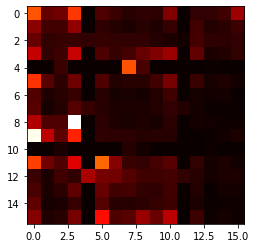

trained 0.5-1000 0 times - ep num = 4
tensor([26.8540, 26.7595, 26.7426, 26.8095], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([17.3800, 17.3982, 17.4033, 17.3742], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([11.6847, 11.7333, 11.6803, 11.6835], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([8.2973, 8.2882, 8.3249, 8.3344], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([6.1066, 6.1213, 6.1298, 6.1358], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


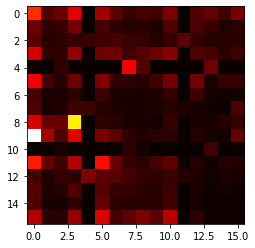

trained 0.5-1000 0 times - ep num = 5
tensor([4.7958, 4.7979, 4.8114, 4.7359], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([3.7939, 3.9241, 4.0754, 4.0157], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([3.3124, 3.3193, 3.3187, 3.3032], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([2.9601, 2.9665, 2.9550, 3.0005], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([2.7569, 2.7191, 2.6917, 2.7171], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 0 times - ep num = 6
tensor([2.4629, 2.5059, 2.4729, 2.4911], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.3319, 2.3623, 2.3673, 2.3252], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.2229, 2.2477, 2.2310, 2.2287], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.1384, 2.0483, 2.1350

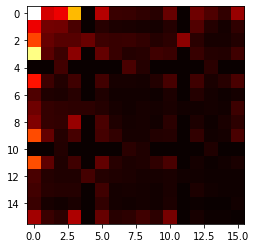

trained 0.5-1000 0 times - ep num = 8
tensor([0.9421, 0.9500, 0.9482, 0.9587], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9253, 0.9290, 0.9255, 0.9264], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8707, 0.8877, 0.8838, 0.8968], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.8907, 0.8928, 0.8933, 0.8932], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8718, 0.8907, 0.8817, 0.8889], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 0 times - ep num = 8
trained 0.5-1000 1 times - ep num = 0
tensor([15.2617, 16.5806, 17.5102, 18.2821], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([18.8517, 19.4757, 18.9177, 19.2619], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([17.2040, 17.5171, 17.5794, 17.2965], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070624

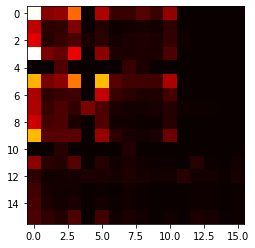

trained 0.5-1000 1 times - ep num = 3
tensor([10.1362, 10.5870, 10.5679, 10.3470], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([9.3357, 8.6368, 8.7556, 8.7298], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([7.6894, 7.7609, 7.5613, 7.6882], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([6.9029, 6.7642, 6.9084, 7.0171], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([5.9005, 7.3145, 6.4574, 7.6199], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


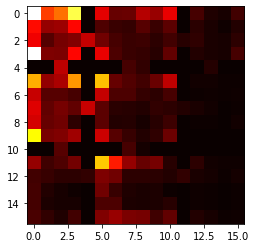

trained 0.5-1000 1 times - ep num = 4
tensor([6.0718, 5.9535, 5.7902, 5.9452], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([5.0857, 5.0610, 5.0511, 5.1029], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([4.5225, 4.4171, 4.4622, 4.4378], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([3.9860, 4.0480, 3.9710, 3.9981], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([3.7524, 3.6558, 3.6704, 3.6158], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


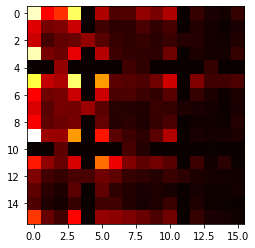

trained 0.5-1000 1 times - ep num = 6
tensor([3.4742, 3.5021, 3.4555, 3.4605], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([3.0929, 3.2001, 3.3072, 3.1332], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([3.0575, 3.0573, 3.0230, 3.0740], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([2.8060, 2.8283, 2.7753, 2.8430], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([2.5502, 2.6326, 2.5874, 2.6114], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 1 times - ep num = 7
tensor([2.4698, 2.4440, 2.4439, 2.4848], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.3243, 2.3542, 2.3368, 2.3089], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.2150, 2.2068, 2.2298, 2.2271], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.0691, 2.1119, 2.1285

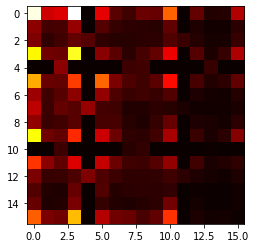

trained 0.5-1000 1 times - ep num = 17
tensor([0.9459, 0.9421, 0.9516, 0.9515], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9336, 0.9325, 0.9339, 0.9338], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.9161, 0.9149, 0.9212, 0.9241], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.9064, 0.9026, 0.9078, 0.9047], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8893, 0.8913, 0.8894, 0.8955], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 1 times - ep num = 18
trained 0.5-1000 2 times - ep num = 0
tensor([14.0272, 54.6981, 26.8309,  3.9943], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([26.4269, 26.2036, 26.4833, 26.6860], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([22.0271, 21.7920, 21.9510, 22.0676], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706

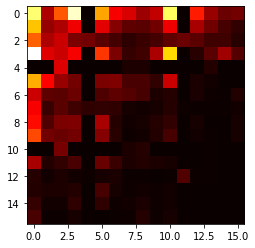

trained 0.5-1000 2 times - ep num = 0
tensor([17.9725, 26.6181,  8.4682, 14.3292], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([18.4908, 16.2122, 15.4163, 17.3769], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([18.1044, 17.2964, 18.3630, 18.3556], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-1632.0005,  3523.9180,   794.5881, -2106.2417], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([1719.1525, 1777.9781, 1773.8519, 1727.3894], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


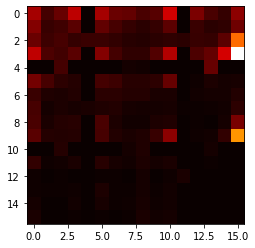

trained 0.5-1000 2 times - ep num = 0
tensor([1123.4023, 1133.8934, 1118.2692, 1106.5520], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([696.3002, 700.7665, 691.5308, 694.6343], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([414.6794, 414.6254, 405.3307, 404.9045], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([264.6932, 262.7854, 264.7144, 271.2032], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([167.2664, 166.5457, 167.2959, 167.3942], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


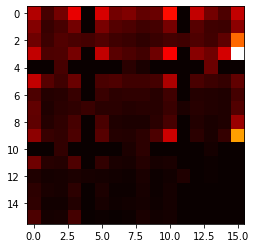

trained 0.5-1000 2 times - ep num = 1
tensor([101.5579, 102.7340, 101.6975, 101.4804], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([62.0081, 61.9897, 62.2199, 62.1857], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([37.8680, 37.6297, 37.7569, 37.7095], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([23.0211, 22.9899, 22.9027, 22.5323], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([16.4485, 16.4476, 17.7524, 16.4664], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 2 times - ep num = 4
tensor([13.5039, 13.9985, 14.3481, 13.9930], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([ 8.7737,  9.1916,  9.6835, 10.2716], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([7.1874, 7.2748, 7.0698, 7.2694], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.01190159851363867

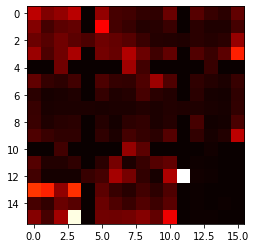

trained 0.5-1000 2 times - ep num = 7
tensor([1.0447, 0.9711, 1.0251, 0.9857], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.8706, 0.8777, 0.8416, 0.8605], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8083, 0.8598, 0.8415, 0.8715], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.8106, 0.6167, 0.7642, 0.5591], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.8296, 0.6567, 0.7987, 0.6289], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 2 times - ep num = 7
trained 0.5-5000 0 times - ep num = 0
tensor([ 98.9515, 104.8500, 105.8713,  98.8995], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([73.6121, 72.6870, 72.5967, 72.2006], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([62.7076, 61.8249, 62.2439, 60.2527], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.307

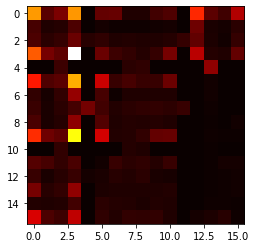

trained 0.5-5000 0 times - ep num = 3
tensor([753.0870, 758.3600, 810.6349, 811.2423], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([527.8535, 583.9291, 560.3918, 586.5602], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([ 692.2446, 1648.0645,  943.1552, 1138.2958], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1514.6448, 1649.0016, 1616.6429, 1571.8547], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([916.9879, 952.5890, 917.5949, 914.0071], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


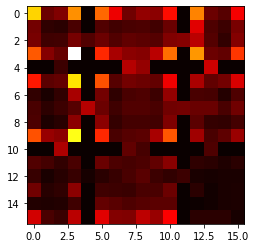

trained 0.5-5000 0 times - ep num = 6
tensor([567.1537, 581.1433, 574.2464, 586.4048], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([395.4805, 388.9276, 386.1793, 382.5696], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([204.8186, 206.3729, 203.4456, 205.5225], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([129.3844, 136.7193, 134.6797, 129.0440], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([231.1285, 120.1455, 100.0678, 175.6538], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


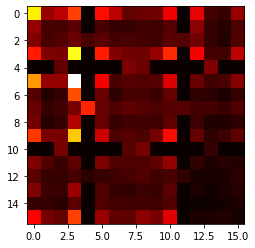

trained 0.5-5000 0 times - ep num = 9
tensor([86.0784, 87.3814, 75.3224, 80.7471], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([85.5696, 80.7436, 85.3543, 87.2313], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([61.4673, 57.3257, 61.5636, 61.3085], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([41.5671, 36.5013, 34.3972, 35.4124], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([31.8621, 36.7636, 36.8924, 33.6285], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 0 times - ep num = 12
tensor([23.7781, 26.5768, 29.5661, 25.0494], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([23.6221, 24.1238, 21.1823, 25.1948], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([27.3308, 27.5238, 27.5766, 28.4438], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.0119015985136386

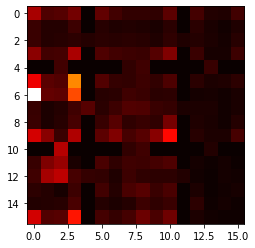

trained 0.5-5000 0 times - ep num = 22
tensor([4.6307, 4.6595, 4.6835, 4.5629], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.6195, 4.5987, 4.5789, 4.6244], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.2807, 4.5279, 4.2763, 4.4673], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([3.9020, 4.0384, 4.1044, 3.9195], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([4.4026, 4.4191, 4.2130, 4.2453], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 0 times - ep num = 22
trained 0.5-5000 1 times - ep num = 0
tensor([17.0024, 19.1760, 17.9377, 18.0052], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([29.7043, 29.0918, 30.3536, 30.0933], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-194.1251,  507.1677, -303.8332,  865.4896], device='cuda:0',
       grad_fn=<SliceBackward0>)

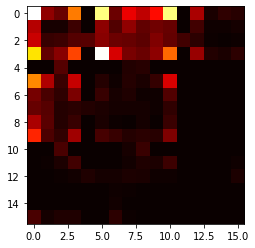

trained 0.5-5000 1 times - ep num = 1
tensor([103.7617, 102.6989, 104.9991, 103.7810], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([70.7773, 70.9656, 70.5183, 70.9656], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([52.4636, 52.6347, 52.7227, 52.5556], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([346.0224, 275.1175, 415.0355, 884.9065], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([691.0902, 724.6815, 670.7470, 702.8464], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


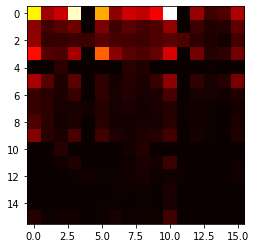

trained 0.5-5000 1 times - ep num = 1
tensor([651.8444, 615.6323, 725.0145, 687.2207], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([529.7676, 501.8344, 541.2632, 553.4586], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([330.9673, 332.0428, 326.4321, 325.6770], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([218.9161, 194.1049, 201.3741, 218.7682], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([150.3557, 151.3129, 150.4299, 152.6604], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


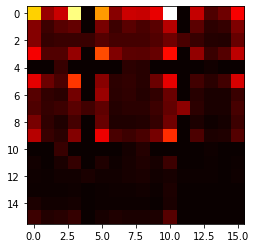

trained 0.5-5000 1 times - ep num = 1
tensor([111.4943,  92.6517,  97.2310, 100.6535], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([65.3062, 66.2393, 66.4743, 66.2849], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([51.8659, 49.1199, 51.0846, 50.6223], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([44.9239, 45.6494, 46.9221, 45.3169], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([32.3297, 33.5638, 28.6973, 27.3685], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 1 times - ep num = 4
tensor([20.6123, 20.5167, 20.2576, 20.9238], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([17.3109, 18.2862, 16.8384, 15.5744], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([17.4176, 17.0082, 18.2862, 17.7359], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.0119015985136

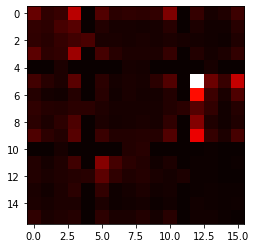

trained 0.5-5000 1 times - ep num = 15
tensor([4.0642, 4.1930, 4.1072, 4.2210], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.3752, 4.3152, 4.3425, 4.4439], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.1546, 4.1774, 4.1744, 4.1956], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([4.1124, 4.0472, 4.0489, 4.0462], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([4.2312, 4.2413, 4.2607, 4.2933], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 1 times - ep num = 15
trained 0.5-5000 2 times - ep num = 0
tensor([1441.5985, 1308.5726, 1291.5762, 1114.8374], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([1643.3502, 1544.5295, 1533.4185, 1638.6969], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([790.1146, 743.4607, 805.5728, 851.1080], device='cuda:0',
       grad_fn=<Slic

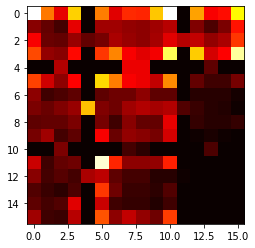

trained 0.5-5000 2 times - ep num = 0
tensor([186.3111, 246.1127, 187.8453, 218.0622], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([174.9168, 198.7191, 134.3448, 131.5704], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([116.7553, 117.7958, 115.5797, 119.6444], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([62.5490, 55.8037, 64.8442, 60.3114], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([75.0392, 66.0154, 64.1748, 67.1806], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


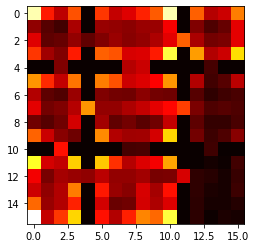

trained 0.5-5000 2 times - ep num = 4
tensor([55.5471, 54.5283, 55.6030, 56.4620], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([48.9516, 49.8116, 49.2552, 49.0322], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([36.9786, 37.7564, 35.1354, 34.5510], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([26.7009, 25.8524, 25.9280, 25.4694], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([15.2752, 15.5938, 17.2570, 17.6005], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


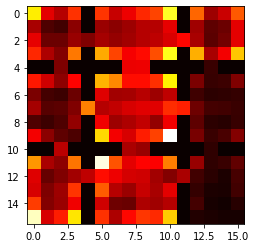

trained 0.5-5000 2 times - ep num = 6
tensor([30.4108, 23.7137, 17.5705, 30.7601], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([13.5008, 12.9689, 14.8309, 13.5527], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([17.4076, 20.1862, 18.3096, 18.2557], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([12.0847, 13.6160, 12.2169, 12.4215], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([12.9148, 12.1997, 13.0370, 13.0938], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 2 times - ep num = 8
tensor([9.5421, 9.7170, 9.7761, 9.8687], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([ 9.1000,  8.9938, 10.0068,  8.7124], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([7.3384, 7.7575, 7.5676, 7.3356], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor

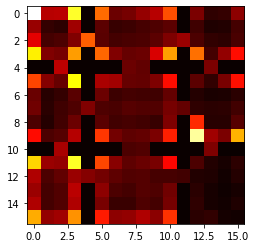

trained 0.5-5000 2 times - ep num = 17
tensor([4.4882, 4.4481, 4.5092, 4.5000], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.4296, 4.4300, 4.4355, 4.4047], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.3516, 4.3423, 4.4033, 4.3577], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([4.2123, 4.1861, 4.2022, 4.1915], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([4.1575, 4.1858, 4.1720, 4.1807], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 2 times - ep num = 21
trained 1-500 0 times - ep num = 0
tensor([26.6029, 24.9398, 27.0404, 24.2053], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([89.9483, 75.6770, 63.4086, 91.0014], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([ 96.6987, 100.8904,  92.3336, 101.2333], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070

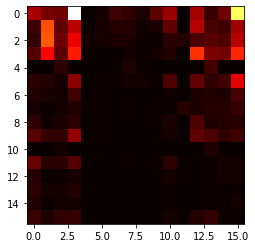

trained 1-500 0 times - ep num = 4
tensor([28.8025, 28.5860, 31.5134, 28.8805], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([23.3492, 23.5124, 23.9247, 23.0569], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([17.1128, 18.3347, 17.1275, 17.8084], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([ 878.1520, 1125.6165, 1051.3267,  940.8843], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([453.5860, 529.1644, 739.3673, 501.7119], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


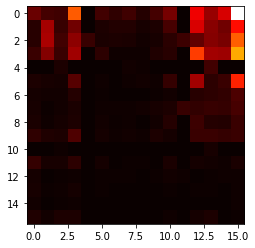

trained 1-500 0 times - ep num = 5
tensor([948.9533, 851.9479, 840.3900, 876.2916], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([664.0897, 688.3970, 634.5518, 747.9888], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([602.3403, 613.4788, 610.8118, 616.2878], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([431.9257, 417.2879, 428.3182, 424.1495], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([279.6548, 288.7522, 280.6026, 282.5312], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


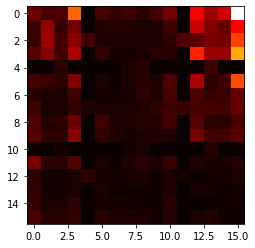

trained 1-500 0 times - ep num = 9
tensor([197.2485, 198.4983, 199.4315, 194.4915], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([123.6930, 123.7233, 124.1853, 120.0870], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([75.1649, 74.4597, 74.6447, 75.3986], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([45.9092, 45.8208, 45.8427, 45.8652], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([31.3705, 31.5476, 31.0017, 31.4852], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 0 times - ep num = 11
tensor([22.4247, 22.7998, 22.6943, 23.5989], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([14.3847, 14.8847, 14.9562, 14.7010], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([14.2069, 13.5972, 14.2731, 14.3100], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.01190159851363

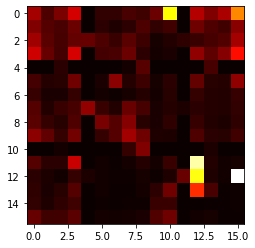

trained 1-500 0 times - ep num = 14
tensor([1.1060, 1.0280, 0.9526, 0.9807], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.0455, 0.9851, 1.0901, 1.1115], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.1226, 1.0803, 1.2240, 1.1850], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.9238, 0.8616, 0.8889, 0.9178], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.9467, 0.9832, 0.9432, 0.9499], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 0 times - ep num = 14
trained 1-500 1 times - ep num = 0
tensor([24.6689, 24.8442, 24.5841, 23.8557], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([24.4326, 24.9420, 24.2685, 24.5371], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([89.1671, 81.7042, 85.0175, 87.5345], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999

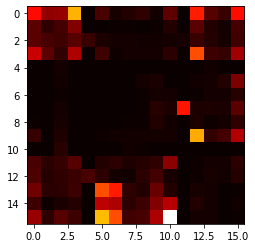

trained 1-500 1 times - ep num = 2
tensor([27.4586, 27.7073, 26.8728, 27.0081], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([20.0584, 19.8848, 20.1234, 19.7413], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([14652.7900, 11094.5078, 24301.4395, 19021.5879], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1390.1792, 1331.5809, 1322.7661, 1351.6440], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([855.8424, 848.5466, 834.2103, 867.4763], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


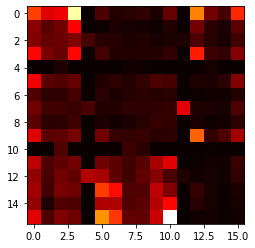

trained 1-500 1 times - ep num = 6
tensor([531.8367, 532.4384, 530.8455, 526.4205], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([341.5270, 344.0258, 351.5682, 347.2014], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([230.5459, 226.9361, 230.1281, 230.2422], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([149.7906, 148.4504, 147.5292, 149.9337], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([90.7808, 90.5402, 89.5165, 89.2943], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


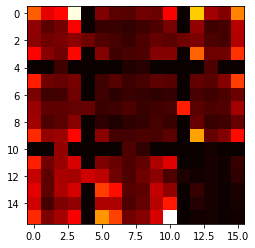

trained 1-500 1 times - ep num = 6
tensor([47.6250, 74.1899, 29.4703, 57.9137], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([54.0022, 53.5985, 54.0562, 54.1781], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([33.1646, 33.0648, 33.1128, 33.1205], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([20.2946, 20.5124, 20.8540, 20.8211], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([14.2368, 14.6645, 13.6809, 13.5809], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 1 times - ep num = 7
tensor([20.2924, 20.3872, 19.5508, 19.9804], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.6698, 13.7340, 13.8001, 13.1453], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([ 9.6704, 11.1682, 10.7343, 11.7494], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tens

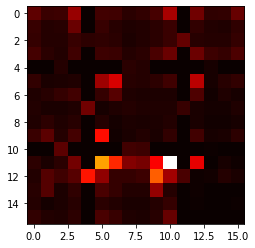

trained 1-500 1 times - ep num = 9
tensor([0.9581, 1.0284, 0.9794, 1.0007], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.0713, 1.1108, 1.0622, 1.1040], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.0992, 1.0540, 1.0656, 1.0917], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.0446, 1.0499, 1.0300, 1.0199], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.9308, 0.9045, 0.9579, 0.9419], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 1 times - ep num = 9
trained 1-500 2 times - ep num = 0
tensor([24.8431, 24.4139, 24.2201, 23.8065], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-28922.3750,  91845.9844,  43777.9531, -17663.6230], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([18253.3613, 18308.5352, 18366.1113, 17776.3359], device='cuda:0',
       grad_fn=<SliceBa

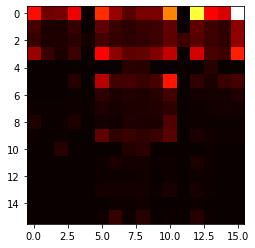

trained 1-500 2 times - ep num = 1
tensor([4322.9336, 4326.0381, 4330.9004, 4324.5093], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([21139.3008, 21099.7480, 21206.1230, 21184.0078], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([12852.8027, 12938.9482, 12774.8486, 12889.8740], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([7454.1440, 7507.0093, 7462.2827, 7514.3281], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([4516.2075, 4503.2280, 4533.3525, 4503.6548], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


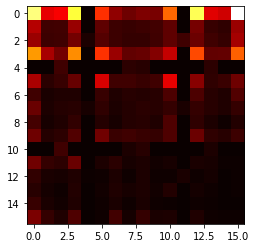

trained 1-500 2 times - ep num = 2
tensor([2709.7859, 2719.0291, 2702.2322, 2717.8899], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([1634.6531, 1633.2094, 1640.0112, 1648.5193], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([1000.4993, 1003.3879, 1005.0844, 1003.8773], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([597.3982, 596.9647, 596.6406, 594.9374], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([370.0143, 369.4829, 370.6330, 370.2210], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


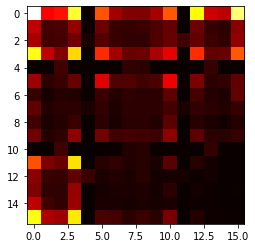

trained 1-500 2 times - ep num = 4
tensor([218.2111, 218.1349, 218.4385, 219.0516], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([131.2947, 131.0728, 131.6499, 131.4644], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([77.2937, 77.9892, 78.2275, 77.0495], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([103.7861, 106.9623, 105.2249, 104.0518], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([62.4652, 62.1583, 61.8854, 62.2328], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 2 times - ep num = 4
tensor([39.9142, 37.1151, 40.1162, 39.6026], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([23.1593, 21.6902, 22.6451, 22.7976], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([ 8.8421,  8.9112, 10.0054, 10.9736], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.01190159851

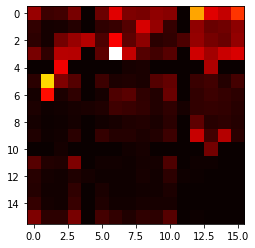

trained 1-500 2 times - ep num = 5
tensor([1.0211, 1.1430, 1.0817, 0.9660], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9711, 1.3186, 1.2134, 1.1680], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.8298, 0.9258, 0.9979, 0.9661], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.0101, 1.1943, 1.2094, 1.3281], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.2136, 1.2355, 1.1903, 1.2461], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 2 times - ep num = 5
trained 1-1000 0 times - ep num = 0
tensor([-1152.6423, -2637.3440, -2449.6248,  2027.9784], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([1379.2222, 1361.0576, 1387.4264, 1392.2729], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([786.5400, 799.0536, 829.7694, 817.8190], device='cuda:0',
       grad_fn=<SliceBackw

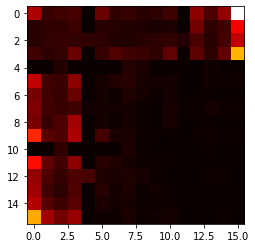

trained 1-1000 0 times - ep num = 1
tensor([216.9503, 215.6100, 211.0688, 216.3095], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([669.2922, 662.8230, 544.7052, 610.7747], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([647.2097, 658.7678, 633.9938, 645.3695], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([415.3181, 420.7623, 413.5052, 413.0793], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([463.7395, 507.2397, 408.1306, 308.5542], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


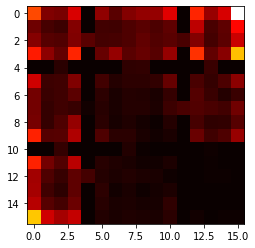

trained 1-1000 0 times - ep num = 2
tensor([803.4186, 851.7358, 815.5888, 831.6420], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([582.6197, 593.8300, 622.4886, 554.8694], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([386.6628, 383.7800, 387.6729, 387.7715], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([231.0912, 231.6851, 231.4131, 231.2752], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([140.3740, 140.1320, 140.2858, 140.5029], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


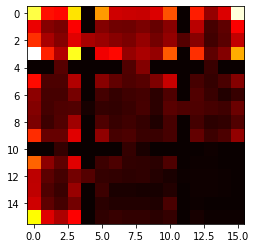

trained 1-1000 0 times - ep num = 3
tensor([113.0684, 126.0303, 121.2016, 101.2658], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([79.3986, 81.5659, 80.8831, 80.0643], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([48.7384, 49.4341, 48.3616, 48.7139], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([31.3685, 31.9833, 31.9667, 31.7983], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([21.2513, 20.5212, 21.4109, 20.8500], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 0 times - ep num = 5
tensor([14.5664, 14.6780, 15.2603, 16.0860], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([7.4504, 7.9201, 7.5708, 7.7642], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([7.9710, 8.7537, 8.3040, 8.2371], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor

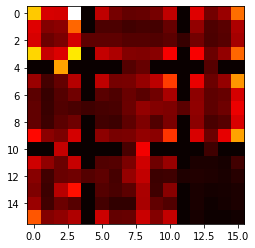

trained 1-1000 0 times - ep num = 18
tensor([2.1113, 2.1244, 2.1574, 2.2125], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.9050, 1.9712, 1.9204, 1.9501], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.8092, 1.8397, 1.8416, 1.8372], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.8324, 1.8308, 1.7948, 1.8005], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.2139, 1.1470, 1.1741, 1.1897], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 0 times - ep num = 18
trained 1-1000 1 times - ep num = 0
tensor([ -554.1738,  3859.1289,  4729.2031, -1231.7245], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([2412.5002, 2409.1021, 2368.6760, 2395.6814], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([1641.1974, 1657.3357, 1635.0200, 1569.8765], device='cuda:0',
       grad_fn=<Sl

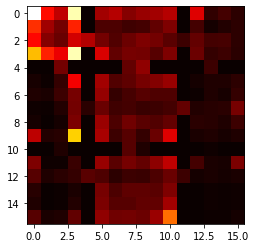

trained 1-1000 1 times - ep num = 3
tensor([838.0188, 854.0907, 847.5228, 841.8621], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([488.1171, 491.4236, 493.9673, 489.2556], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([136.1955, 135.3342, 137.9677, 135.9341], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([64.1952, 57.6994, 75.8474, 69.2310], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([77.1086, 77.1755, 79.0678, 78.4430], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


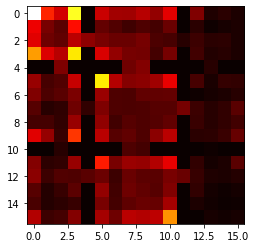

trained 1-1000 1 times - ep num = 7
tensor([180.1433, 173.8736, 161.5074, 170.1148], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([102.0747, 101.8580, 101.7594, 101.6556], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([74.2154, 70.4742, 69.7828, 74.0023], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([72.6713, 74.5990, 75.5097, 76.9474], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([62.2357, 66.6219, 62.0847, 62.8852], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


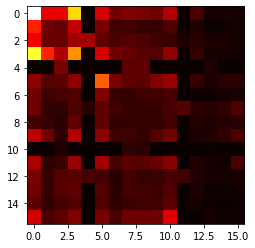

trained 1-1000 1 times - ep num = 9
tensor([61.6048, 60.6871, 63.4534, 55.9531], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([53.0250, 63.2569, 66.6334, 63.3582], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([39.3090, 39.8225, 40.2852, 39.2740], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([30.3599, 28.9720, 28.1478, 28.1942], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([22.7841, 24.6246, 23.4106, 23.8814], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 1 times - ep num = 12
tensor([18.1235, 18.6962, 18.4985, 19.0277], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.9119, 12.8454, 13.7264, 13.7768], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([10.7536, 11.3374, 10.3111, 10.9066], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
t

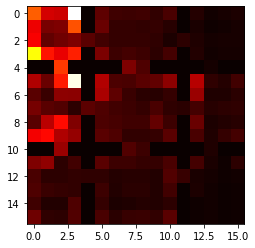

trained 1-1000 1 times - ep num = 17
tensor([1.9192, 1.8788, 1.8908, 1.8130], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.7860, 1.7780, 1.8374, 1.7443], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.7540, 1.7961, 1.7542, 1.7945], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.7971, 1.7259, 1.7706, 1.7454], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.7981, 1.8167, 1.7887, 1.8479], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 1 times - ep num = 17
trained 1-1000 2 times - ep num = 0
tensor([37.0951, 34.2051, 37.6710, 36.4604], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([41.0119, 42.0743, 43.5943, 42.5953], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([39.0452, 39.4925, 36.5239, 37.3905], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999

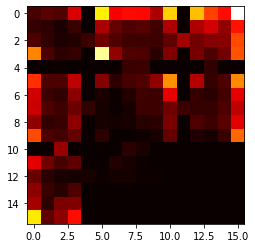

trained 1-1000 2 times - ep num = 0
tensor([4630.8950, 4557.7778, 4566.7417, 4591.9990], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([2960.8486, 2965.6785, 2969.5854, 2883.4255], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1821.1674, 1811.8285, 1834.8986, 1814.1649], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1090.7146, 1091.4595, 1092.9971, 1092.0261], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([657.1768, 657.7060, 662.9536, 663.2877], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


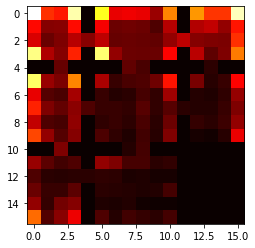

trained 1-1000 2 times - ep num = 0
tensor([411.1171, 413.2669, 415.0622, 412.2484], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([259.6806, 261.6635, 260.1838, 259.7408], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([161.2082, 162.0506, 158.9008, 160.2963], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([99.6430, 98.9844, 99.3701, 99.4365], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([61.6603, 61.6348, 61.8051, 61.8419], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


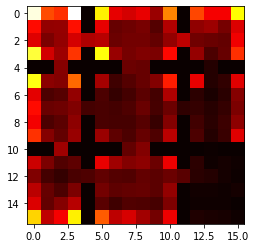

trained 1-1000 2 times - ep num = 3
tensor([36.6931, 35.9403, 36.5478, 36.7651], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([45.4164, 45.0357, 44.9670, 45.0874], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([37.9089, 37.9119, 38.2276, 37.9919], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([21.6473, 22.5492, 23.3758, 23.0489], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([19.4929, 18.7941, 19.0695, 18.9748], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 2 times - ep num = 4
tensor([39.5285, 39.6821, 39.5579, 39.6020], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([23.9184, 23.4949, 24.4133, 23.5757], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([17.6598, 18.2184, 17.3144, 17.3463], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

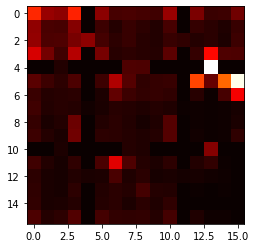

trained 1-1000 2 times - ep num = 7
tensor([1.7284, 1.8822, 1.9359, 1.9565], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.9991, 2.0718, 2.0711, 2.0123], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.8021, 1.7660, 1.8170, 1.8041], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.7808, 1.7557, 1.9095, 1.9601], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.6617, 1.6482, 1.6823, 1.5861], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 2 times - ep num = 7
trained 1-5000 0 times - ep num = 0
tensor([-290.7769,  293.9802,  798.1686, -331.7214], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([151.4735, 158.8500, 146.2454, 156.4758], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([127.4383, 127.3534, 127.6025, 126.9638], device='cuda:0',
       grad_fn=<SliceBackward0>)

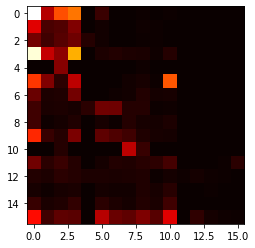

trained 1-5000 0 times - ep num = 2
tensor([79.4040, 80.3383, 79.9543, 80.6668], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([64.3341, 65.5526, 64.4999, 65.1891], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([57.0990, 56.9255, 56.3888, 57.3932], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([52.3355, 50.9367, 51.7717, 50.9931], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([49.6039, 49.3372, 49.7544, 48.9903], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


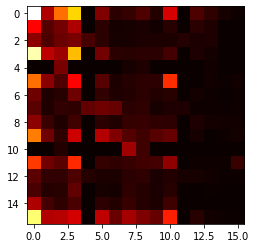

trained 1-5000 0 times - ep num = 2
tensor([42.3140, 41.5115, 41.1698, 38.8520], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([26.0359, 39.2054, 41.9451, 41.5453], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([10.8256, 22.7246, 40.7050, 67.9184], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([218.8929, 217.2460, 205.6394, 191.4492], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([151.7424, 145.1457, 147.8031, 147.3909], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


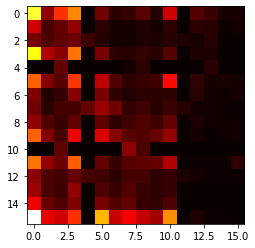

trained 1-5000 0 times - ep num = 2
tensor([93.3656, 94.0645, 94.7700, 94.3347], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([66.7402, 66.9874, 66.5597, 67.4137], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([47.2925, 47.7682, 47.5159, 47.5800], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([37.8352, 38.7055, 37.6227, 37.8210], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([44.4209, 44.6646, 45.9083, 44.4727], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 0 times - ep num = 5
tensor([34.1361, 32.3756, 34.3594, 33.0813], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([28.1690, 29.5476, 28.8836, 29.0212], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([22.2904, 19.7288, 22.1104, 22.5074], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

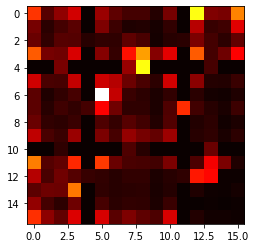

trained 1-5000 0 times - ep num = 14
tensor([8.5360, 8.5216, 8.6392, 8.5408], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([8.4820, 8.4192, 8.4260, 8.2724], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([7.9427, 7.9363, 7.8039, 8.0058], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.0473, 8.0054, 8.0227, 8.1044], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.2766, 8.4322, 8.3473, 8.1081], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 0 times - ep num = 14
trained 1-5000 1 times - ep num = 0
tensor([  580.2942,  3024.8816, -4521.8652,  2140.9761], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([6624.8223, 6670.7944, 6121.7798, 6605.9058], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([3941.8701, 3795.9739, 3926.8105, 3983.6069], device='cuda:0',
       grad_fn=<Sl

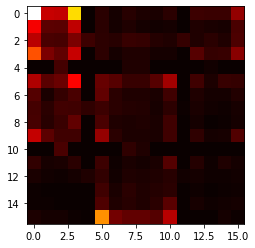

trained 1-5000 1 times - ep num = 2
tensor([1097.5222, 1107.2819, 1102.3566, 1108.8740], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([681.0125, 672.6312, 684.4568, 673.1263], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1763.6251, 1598.9714, 1684.5703, 1617.9574], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1077.4611, 1075.6217, 1061.1996, 1079.1472], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([671.9401, 660.7687, 665.2343, 657.6173], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


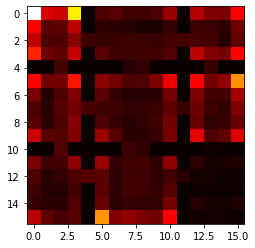

trained 1-5000 1 times - ep num = 4
tensor([405.9107, 403.1558, 404.1266, 402.5852], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([244.3701, 243.5021, 245.5992, 244.1209], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([156.0845, 156.0283, 156.1781, 156.3699], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([112.7049, 116.2786, 113.6237, 118.7116], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([112.9689, 112.0824, 110.3473, 112.6910], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


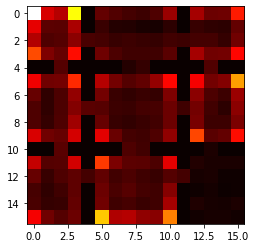

trained 1-5000 1 times - ep num = 6
tensor([70.2763, 71.7521, 75.9092, 72.2460], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([62.7960, 57.7645, 61.4536, 62.9691], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([47.4034, 48.6764, 48.2410, 48.2439], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([42.6658, 42.3209, 42.8228, 43.0520], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([36.7049, 37.9331, 38.9746, 37.7295], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 1 times - ep num = 8
tensor([23.2430, 23.9380, 23.8202, 23.2320], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([21.8936, 20.1794, 21.9553, 20.0469], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([20.3466, 21.7442, 21.1137, 19.6361], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

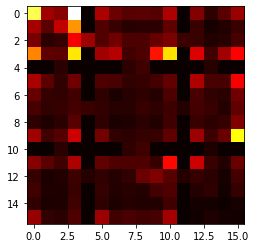

trained 1-5000 1 times - ep num = 30
tensor([9.0169, 8.9077, 8.7199, 8.8139], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([8.2017, 8.2494, 8.2752, 8.2067], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([8.5594, 8.5344, 8.4565, 8.5582], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.5760, 8.5273, 8.5339, 8.5379], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.1801, 8.3186, 8.2661, 8.3074], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 1 times - ep num = 30
trained 1-5000 2 times - ep num = 0
tensor([34052.6016, 33946.2773, 34296.9023, 34472.6523], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([23147.4160, 22687.5059, 22994.9668, 22902.1934], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([13892.5244, 14994.6758, 13696.3857, 12660.3916], device='cuda:0',
       gra

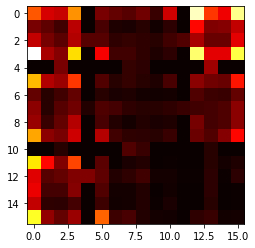

trained 1-5000 2 times - ep num = 3
tensor([3775.0156, 3802.9497, 3750.9231, 3665.4126], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([2433.9104, 2463.9910, 2442.2915, 2455.8333], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1507.2195, 1502.9077, 1525.4153, 1517.2953], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([964.9528, 972.1594, 965.5785, 957.9766], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([593.4094, 602.4624, 592.8810, 599.8928], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


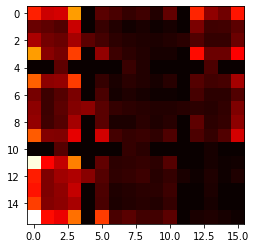

trained 1-5000 2 times - ep num = 4
tensor([379.6706, 377.5332, 377.6416, 377.2040], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([239.3916, 239.8103, 242.5571, 241.3535], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([153.9057, 153.1760, 153.4108, 154.3336], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([111.5737, 108.1382, 114.3412, 113.7769], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([77.1089, 76.4490, 77.6745, 75.3320], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


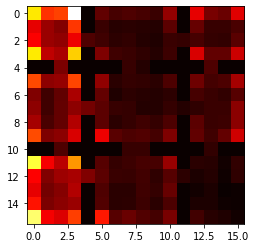

trained 1-5000 2 times - ep num = 7
tensor([54.4900, 55.7499, 55.4472, 54.9350], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([38.3215, 42.3659, 37.1068, 39.3306], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([49.4026, 47.9469, 49.2069, 49.3581], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([51.7035, 52.0225, 51.5608, 48.8360], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([42.9950, 47.9819, 41.3116, 42.1900], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 2 times - ep num = 9
tensor([34.1274, 33.8389, 33.8380, 33.5261], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([29.9131, 29.0500, 29.5445, 30.2067], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([24.7407, 24.8083, 25.1565, 24.8202], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

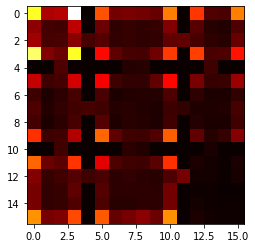

trained 1-5000 2 times - ep num = 13
tensor([8.8721, 8.9109, 8.9331, 8.9526], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([8.5953, 8.5985, 8.5913, 8.6231], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([8.5082, 8.5211, 8.5983, 8.5230], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.3073, 8.3457, 8.3005, 8.3371], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.3036, 8.2436, 8.2631, 8.2893], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 2 times - ep num = 13


In [13]:
for sigma in [0.1, 0.5, 1]:
  for rate in [500, 1000, 5000]:
    avg_returns = []
    episodes = []
    current_coverage = []
    coverage_steps = [5000, 10000, 15000, 50000]
    prefix = f"{sigma}_{rate}_"

    # Noise defined
    for k in range(3):
        torch.cuda.empty_cache()
        current_return = []

        replay_buffer = deque(maxlen=BUFFER_SIZE)
        rew_buffer = []
        temp_episodes = []

        rat_cell = (0, 0)
        env = Qmaze(maze)
        env.reset(rat_cell)
        obs = env.observe()

        agent = DQNAgent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA, 0.5)
        cnt = 0
        coverage_counter = 0
        episode = 0
        for step in itertools.count():
            agent.counter += 1
            action = agent.choose_action(step, obs)

            new_obs, rew, done = env.act(action)
            Transition = (obs, action, rew, done, new_obs)
            replay_buffer.append(Transition)
            obs = new_obs

            if done != 'not_over':
                rat_cell = (0,0)
                env.reset(rat_cell)
                obs = env.observe()
                rew_buffer.append(GAMMA**(cnt))
                episode += 1
                cnt = 0

            if len(replay_buffer) > BATCH_SIZE:
                transitions = random.sample(replay_buffer, BATCH_SIZE)
                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                converted_dones = [done != 'not_over' for done in dones]

                obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

                # Calculate noise
                var = sigma / np.ceil (agent.counter / rate)

                agent.calculate_target(new_obses_t, rews_t, dones_t, var)
                agent.calculate_action_qvalues(obses_t, actions_t)
                agent.optimize_network()

            if step % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()

            if step in coverage_steps:
                if k == 0:
                    current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
                else:
                    current_coverage[coverage_counter] = np.concatenate(
                        [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

                coverage_counter += 1

                plt.imshow(env.coverage, cmap='hot', interpolation='nearest')
                plt.show()

            if step > 55000:
                episodes.append(np.copy(temp_episodes))
                avg_returns.append(np.copy(rew_buffer))
                break
            cnt += 1

            if step % 5000 == 0:
                temp_episodes.append(episode)
                print(f"trained {sigma}-{rate} {k} times - ep num = {episode}")

    min_length = np.min([len(array) for array in avg_returns])
    np.save(prefix+"episodes.npy", np.mean(episodes, axis=0))
    np.save(prefix+"score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
    for s in range(len(coverage_steps)):
        np.save(prefix+f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

In [34]:
plt.imshow(np.mean(current_coverage[1], axis=0)[0:][:], cmap='hot', interpolation='nearest')

IndexError: ignored

<ipython-input-174-4ba5ae3ef7bf>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: ignored

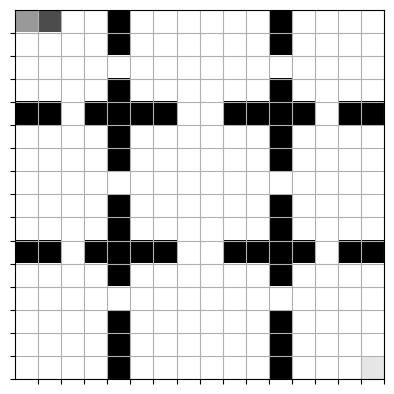

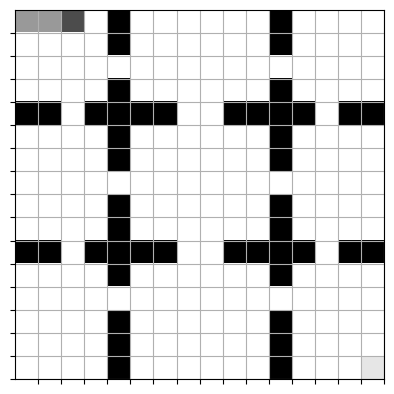

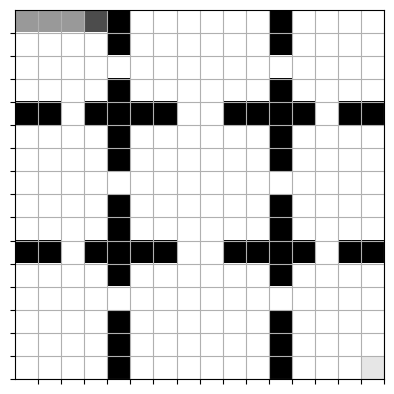

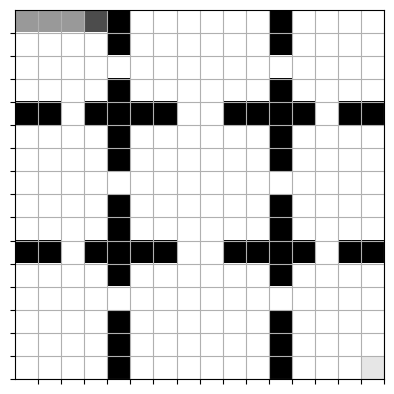

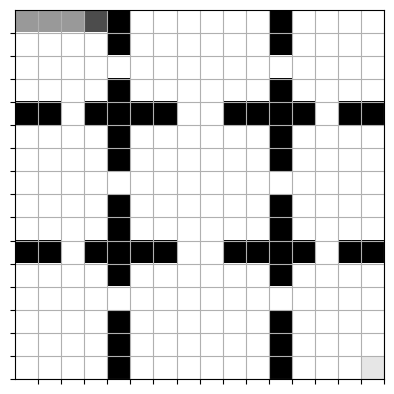

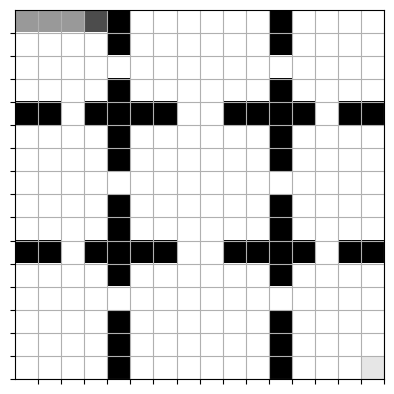

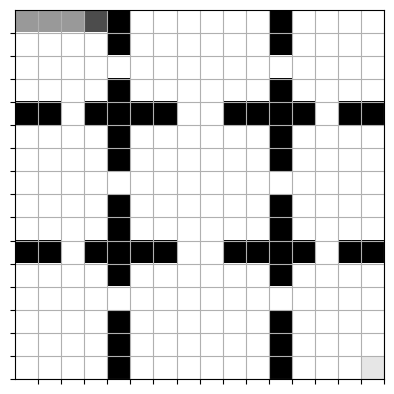

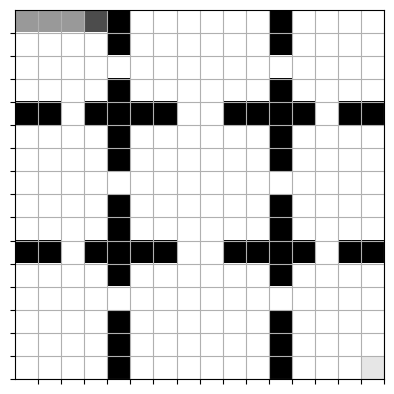

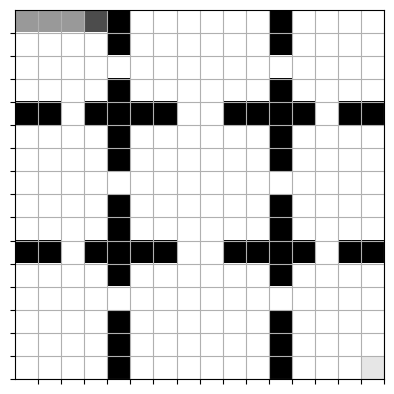

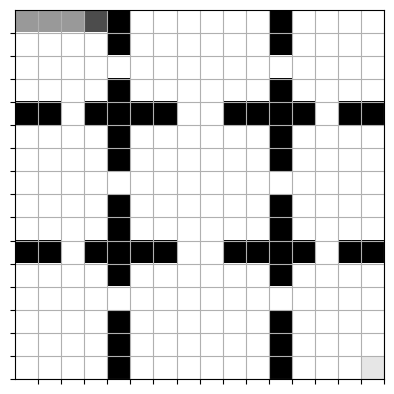

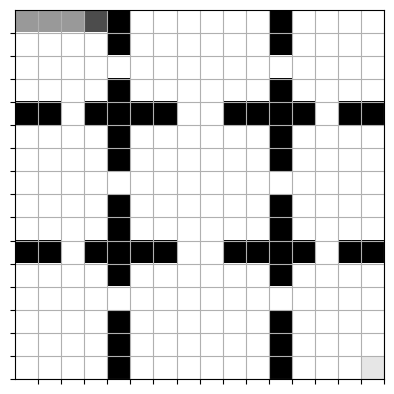

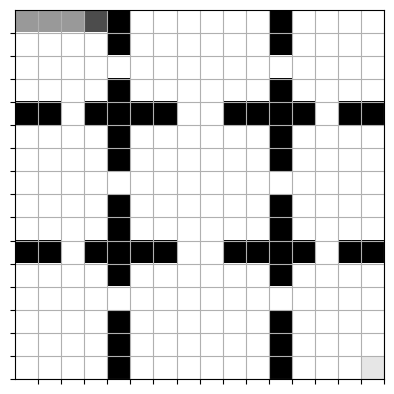

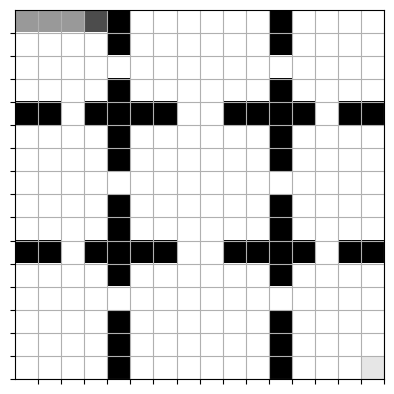

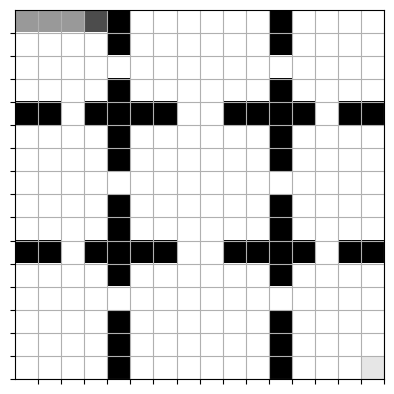

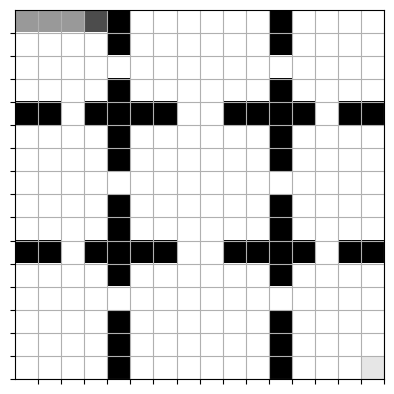

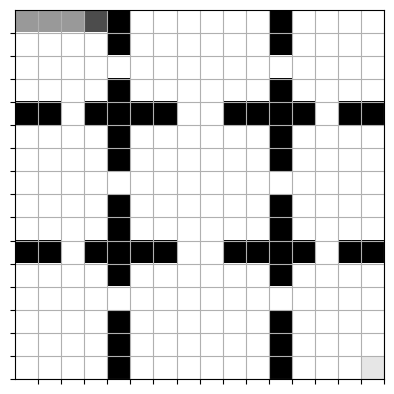

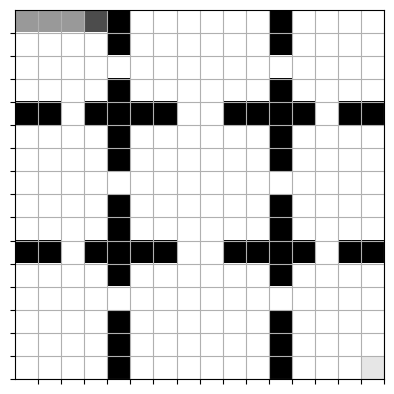

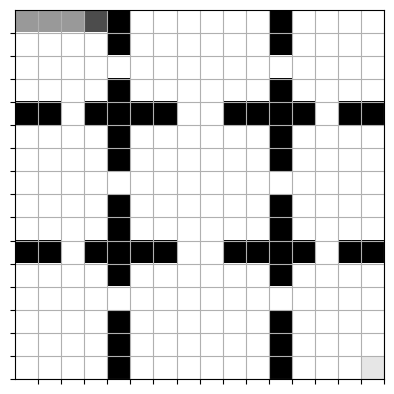

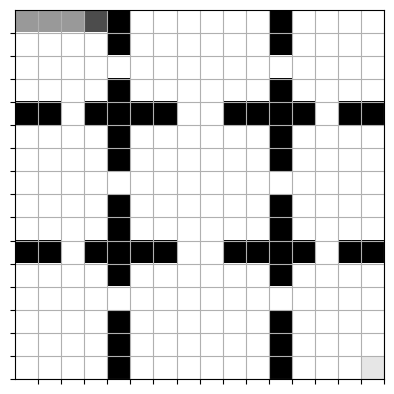

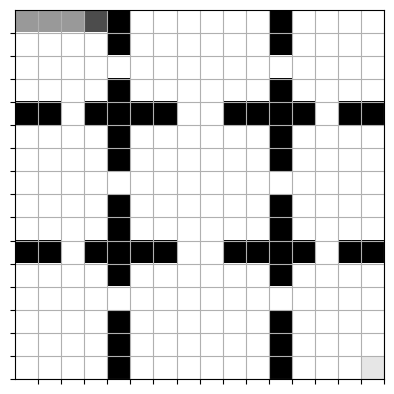

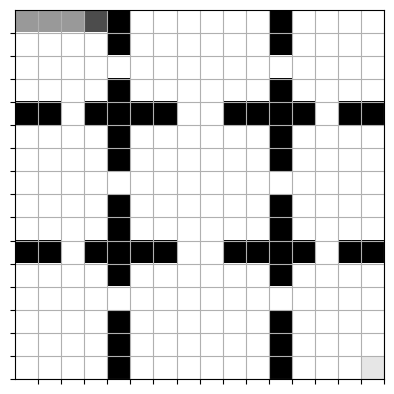

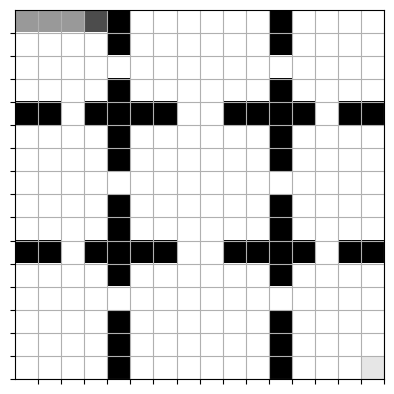

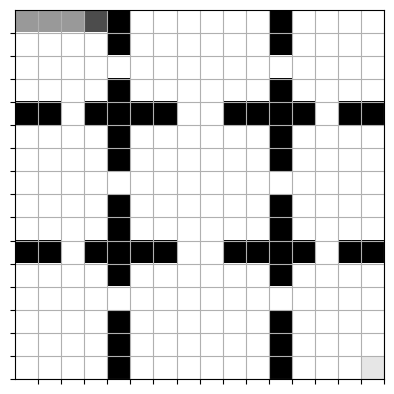

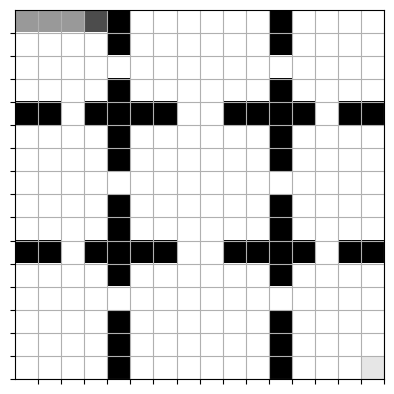

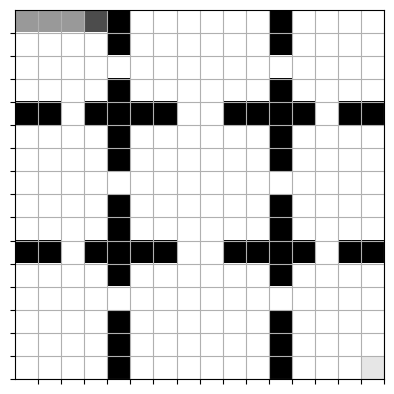

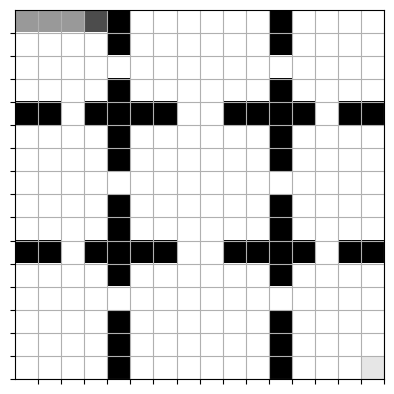

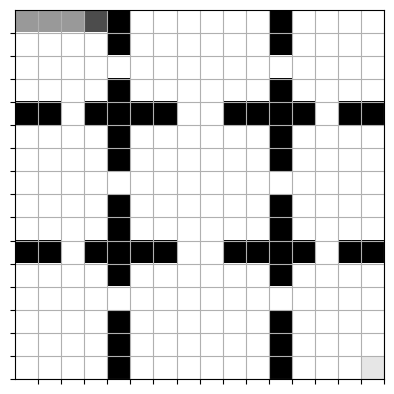

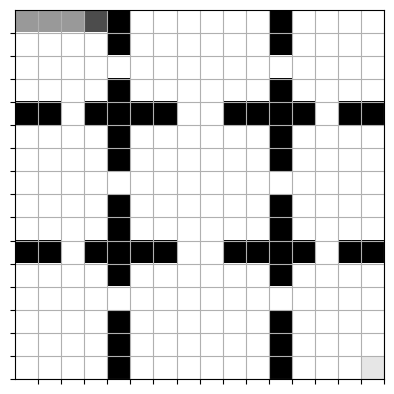

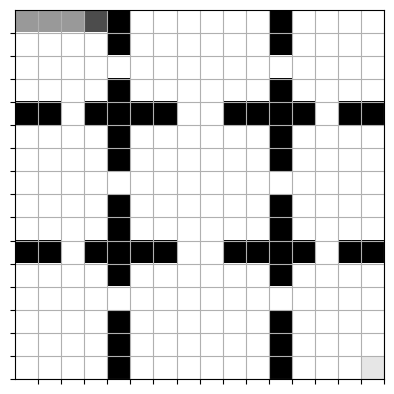

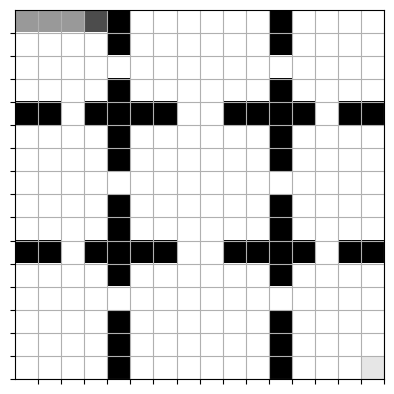

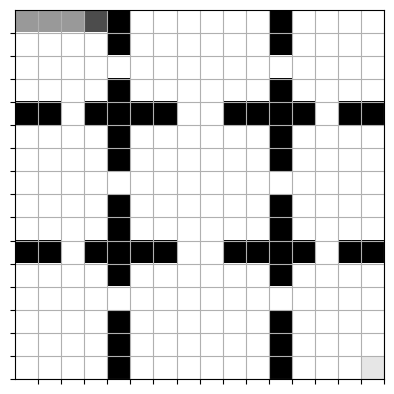

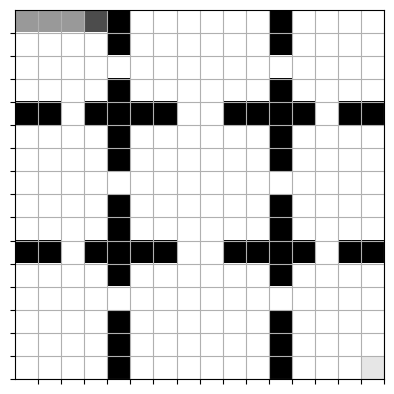

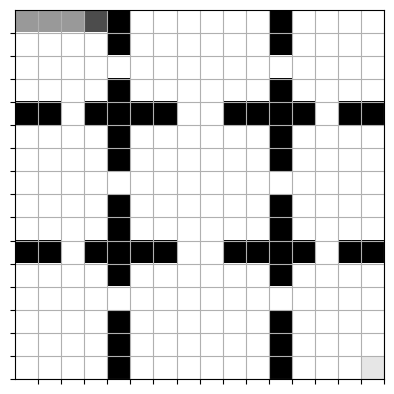

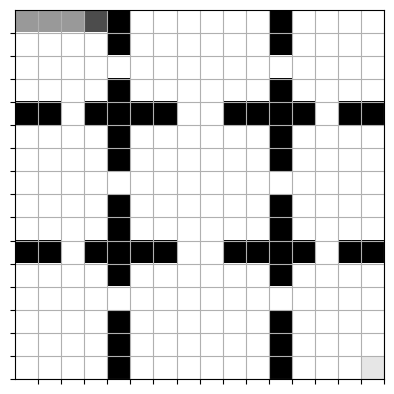

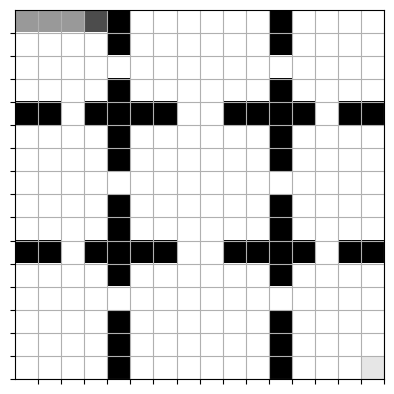

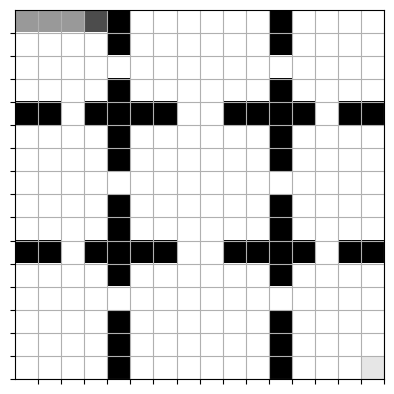

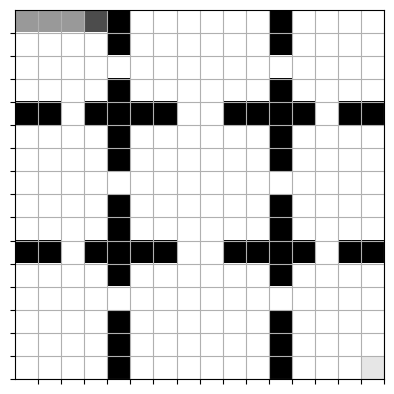

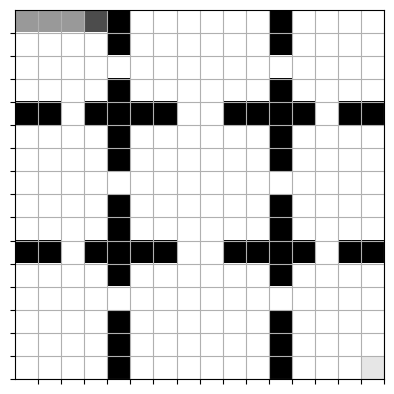

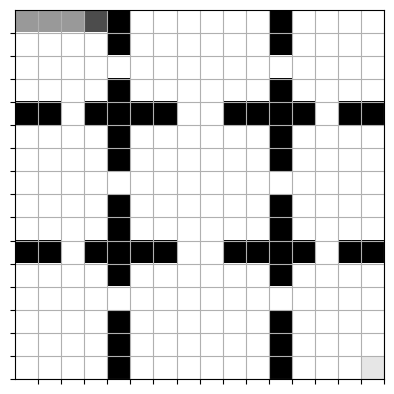

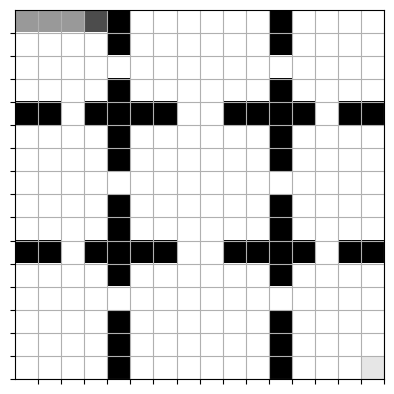

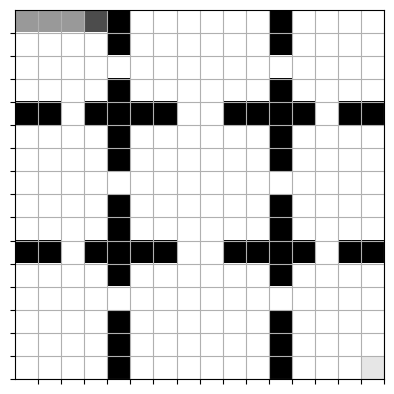

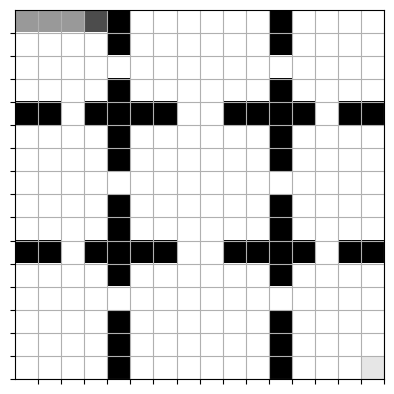

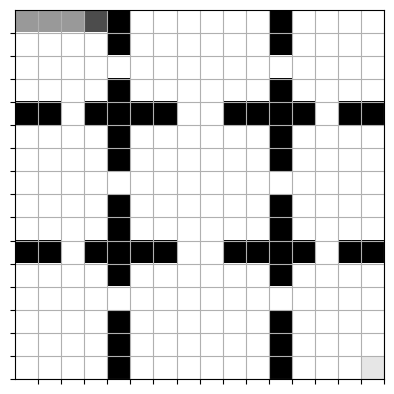

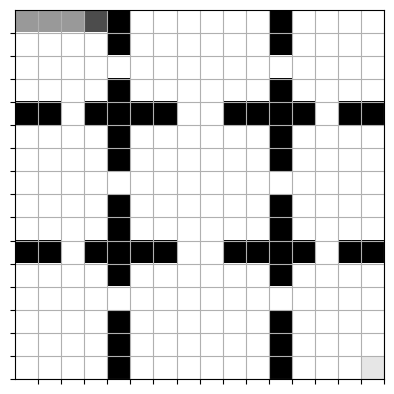

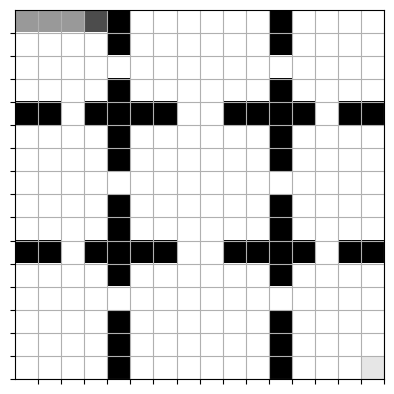

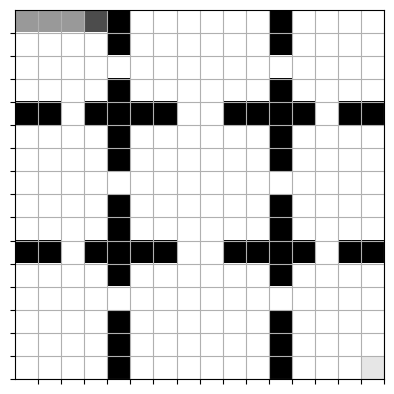

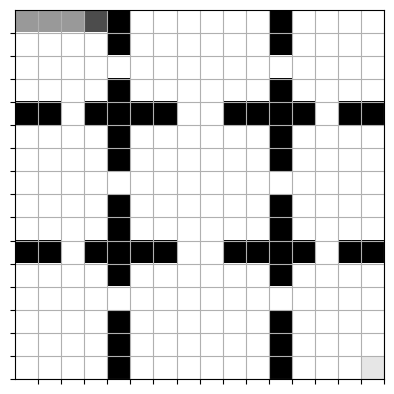

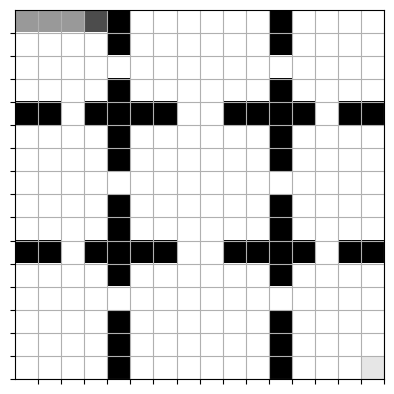

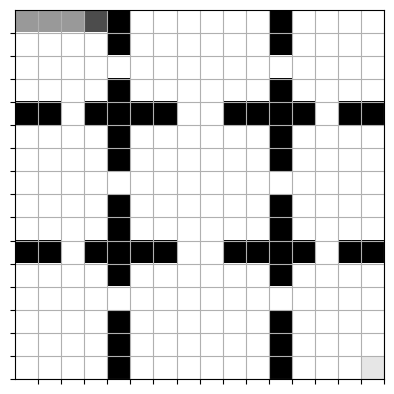

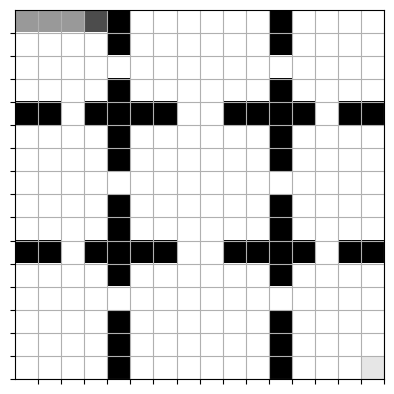

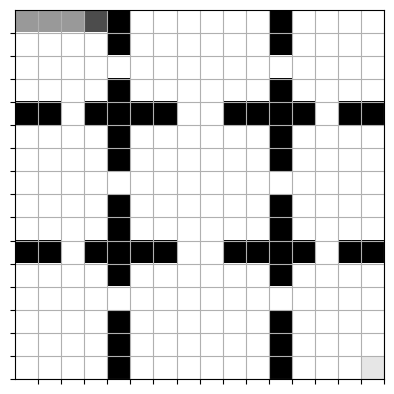

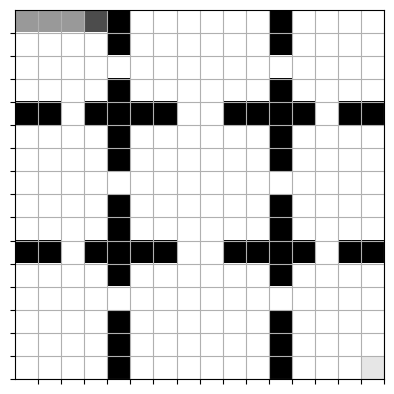

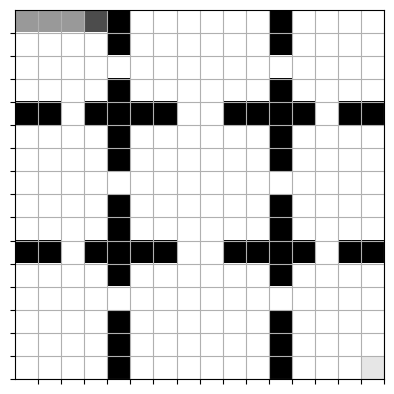

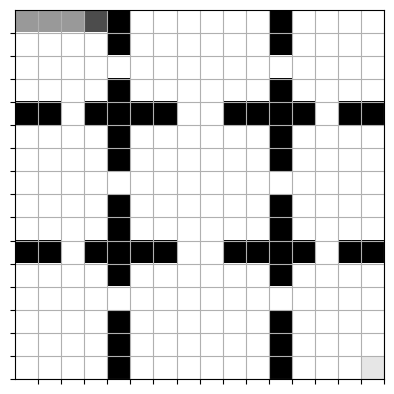

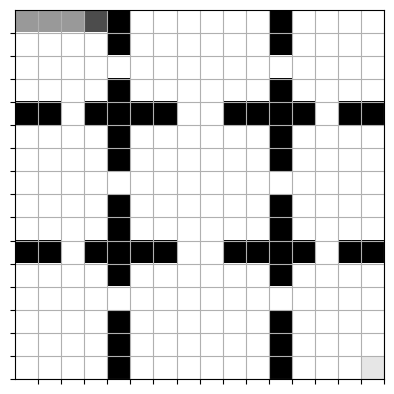

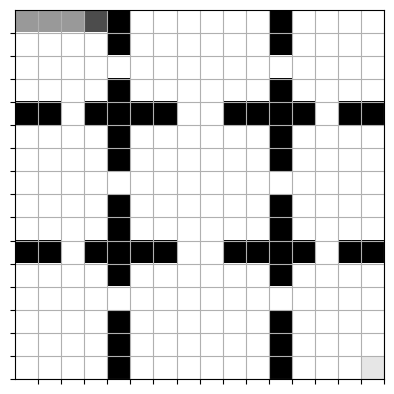

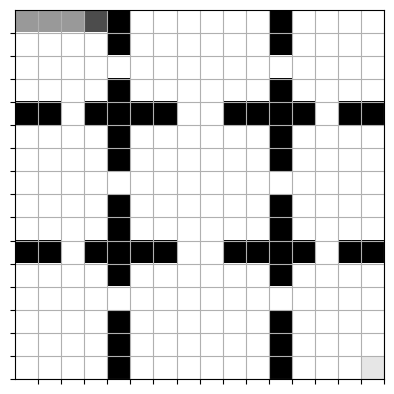

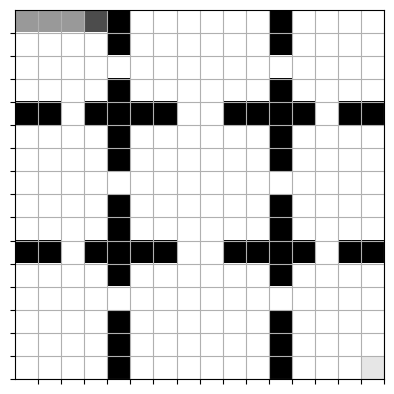

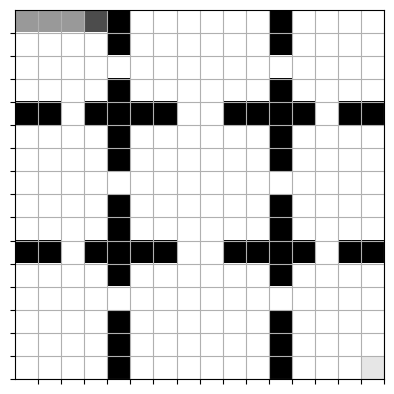

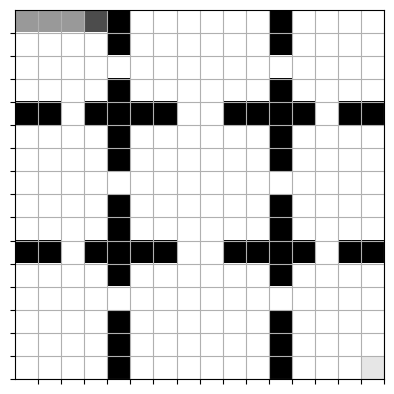

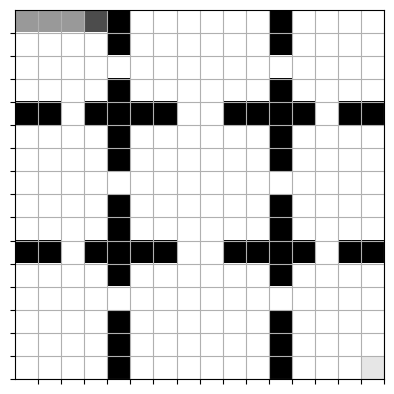

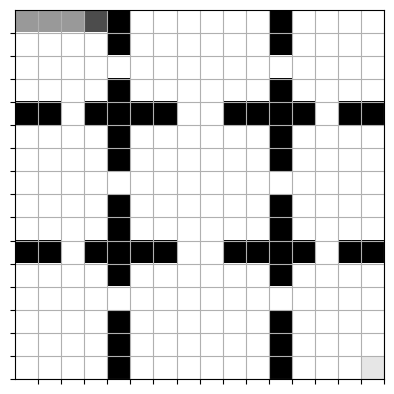

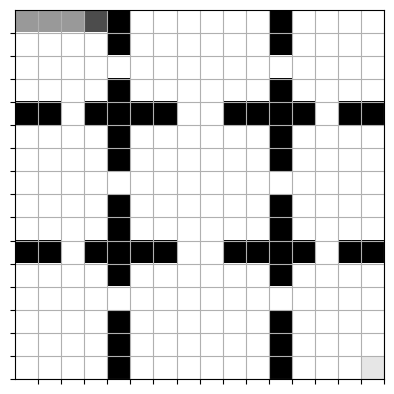

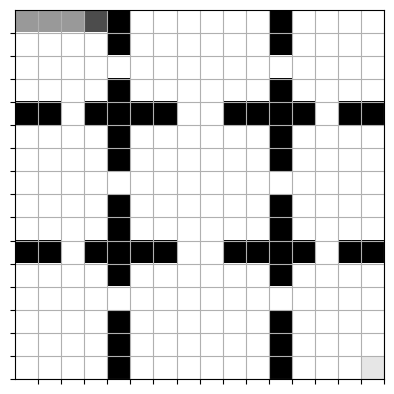

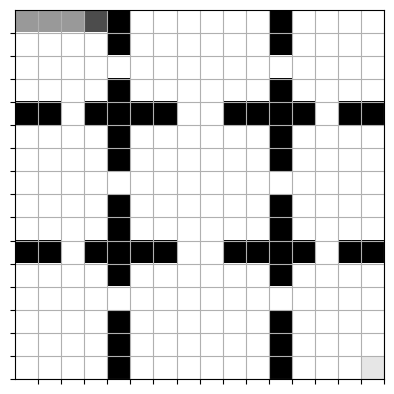

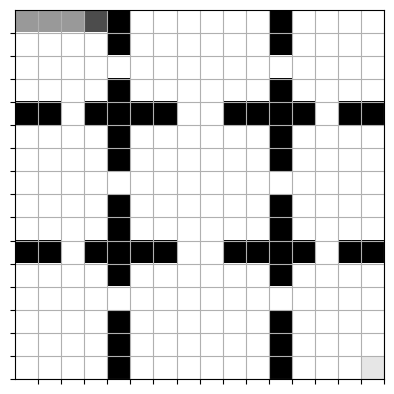

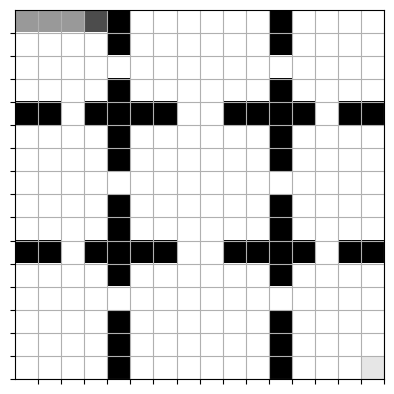

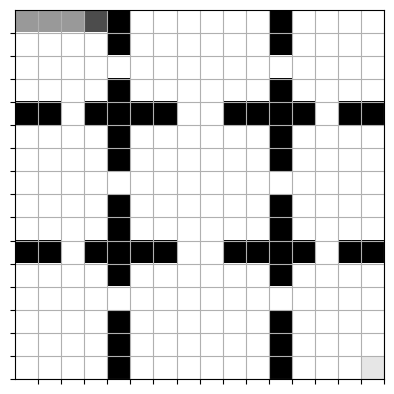

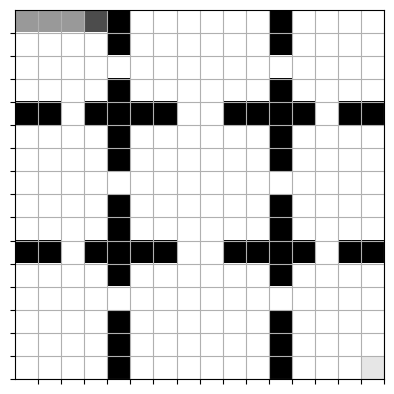

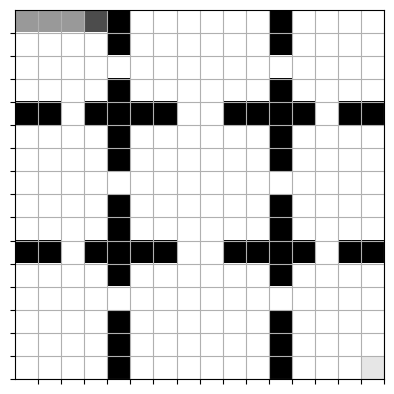

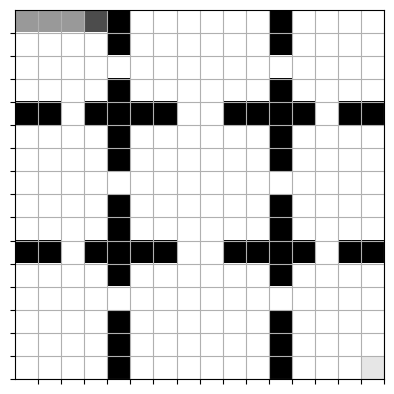

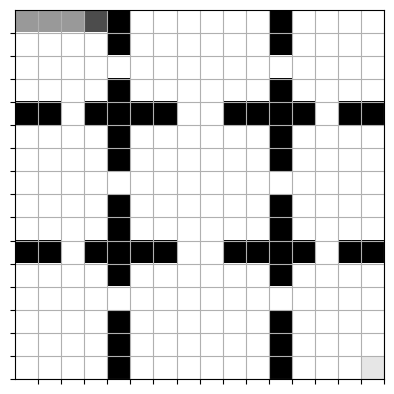

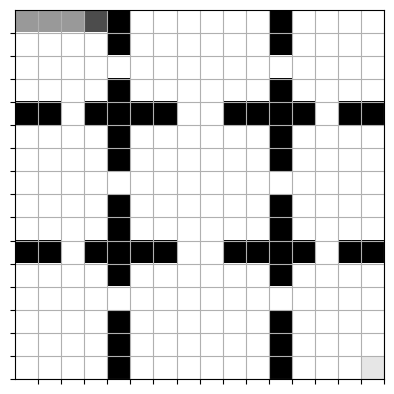

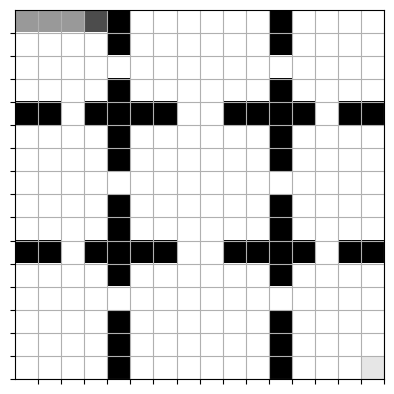

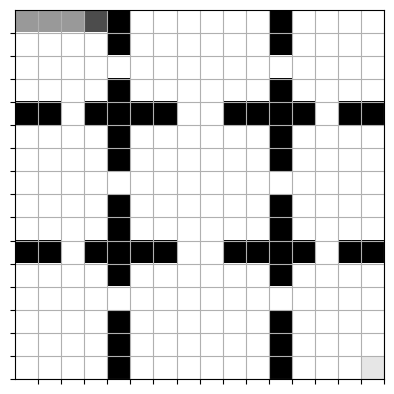

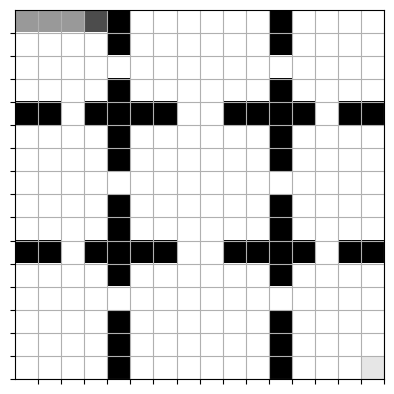

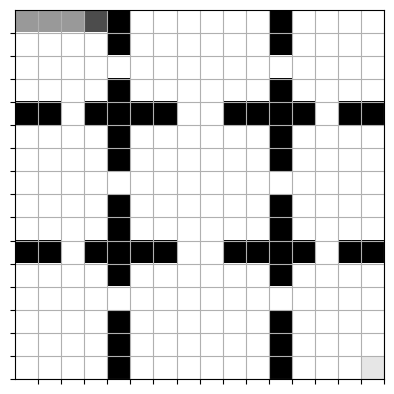

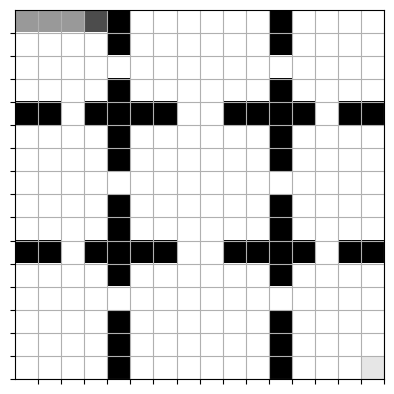

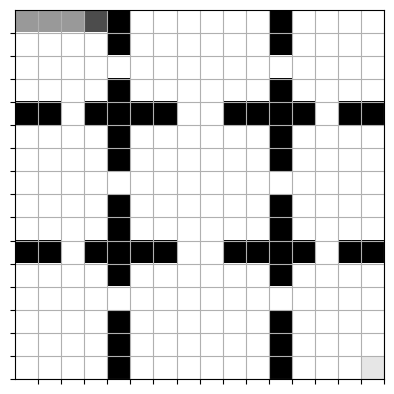

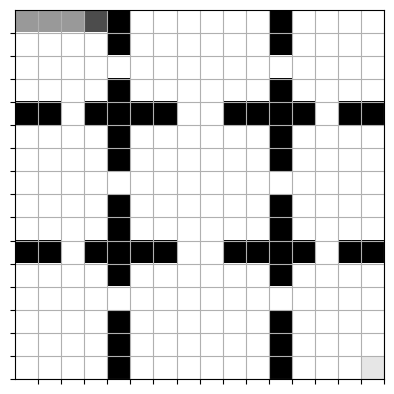

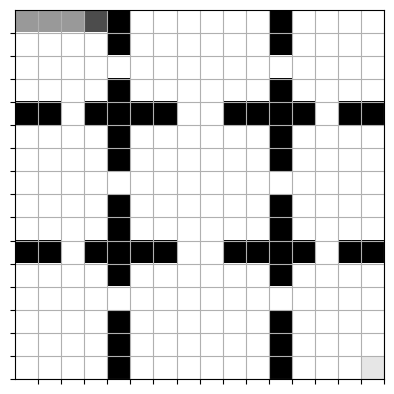

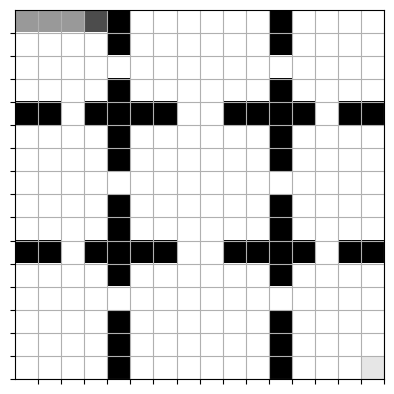

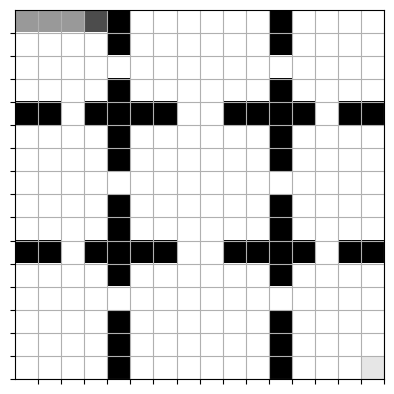

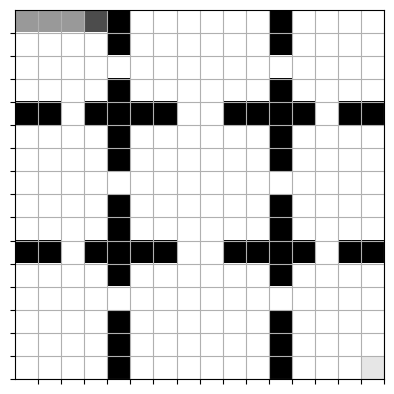

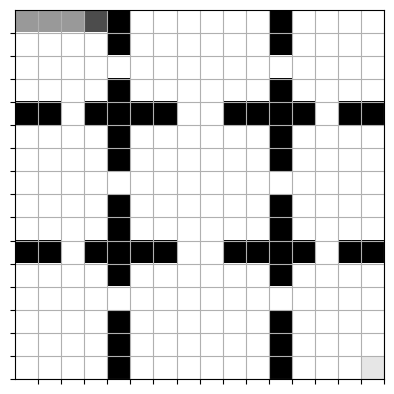

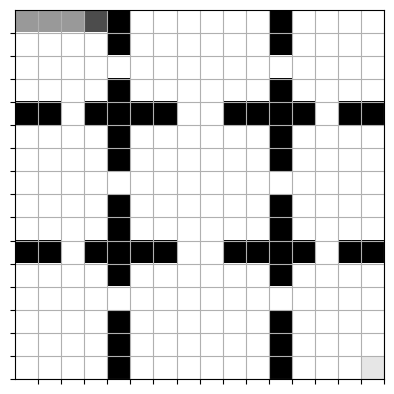

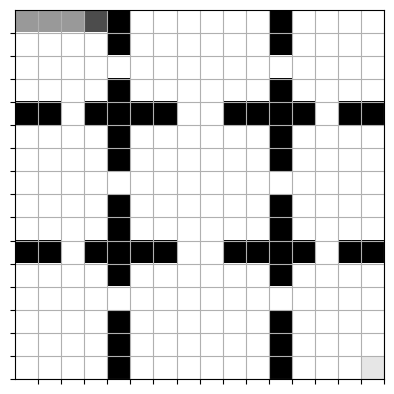

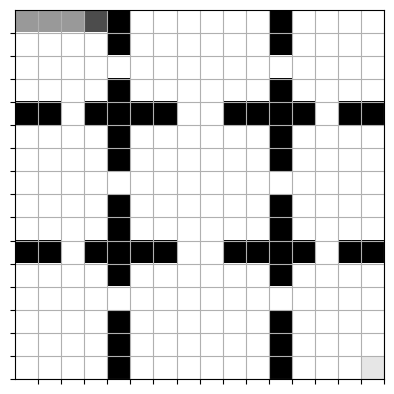

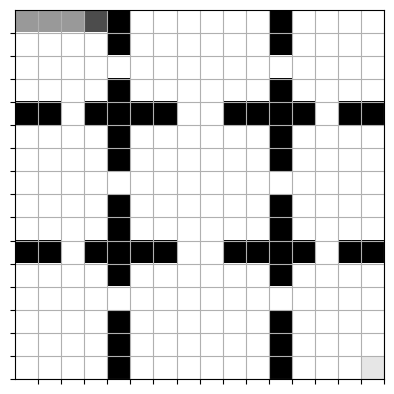

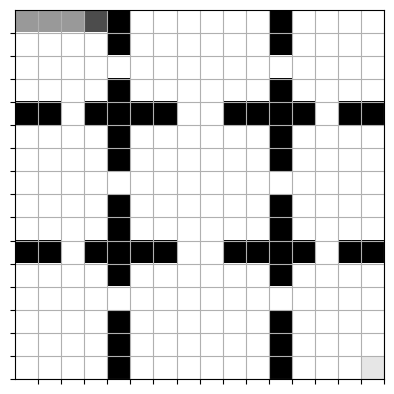

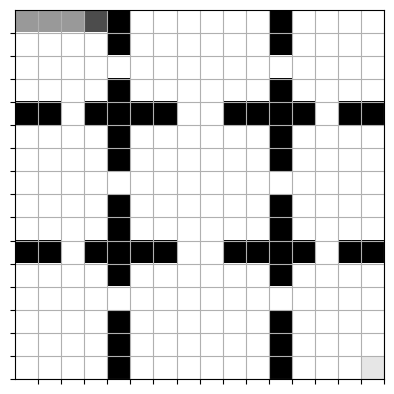

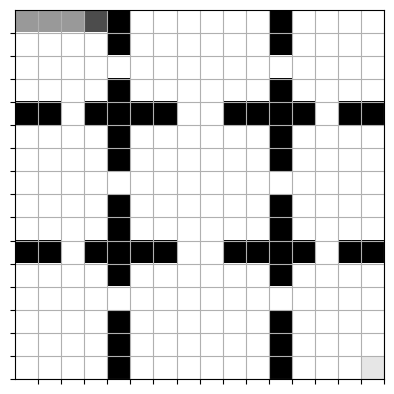

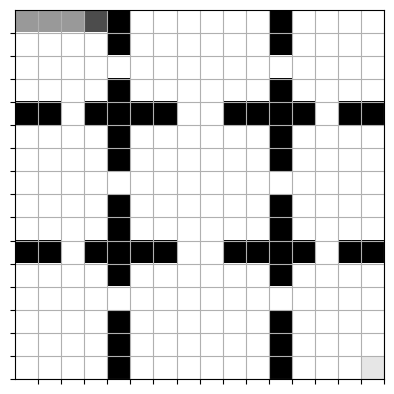

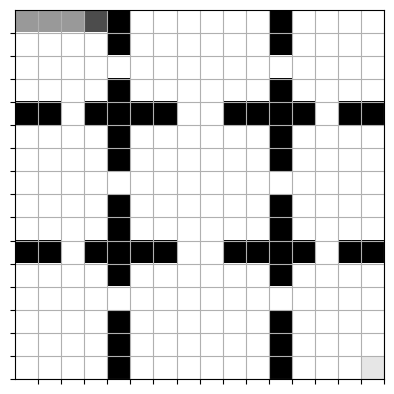

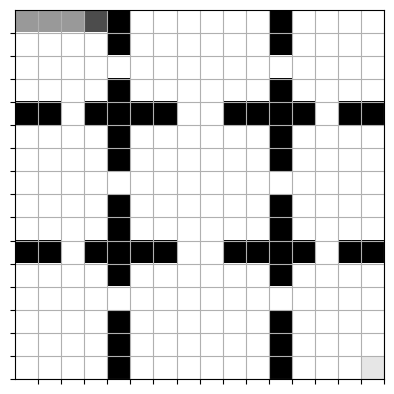

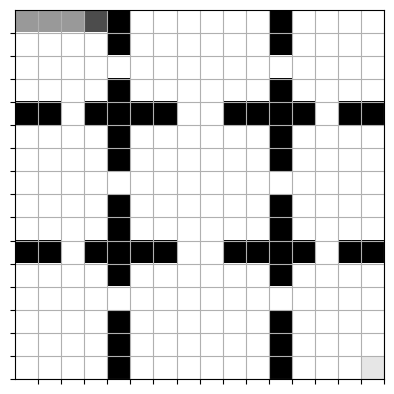

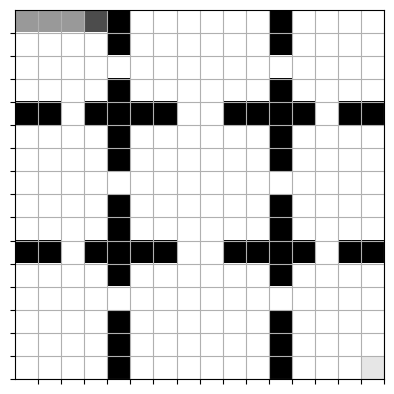

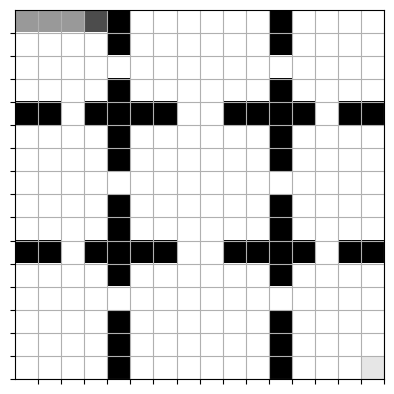

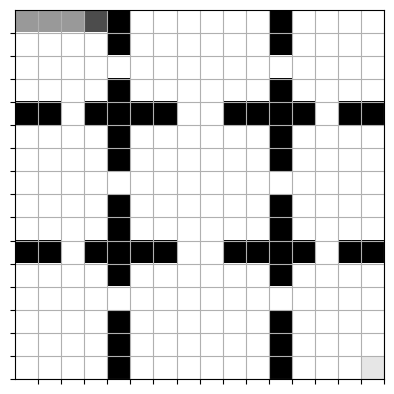

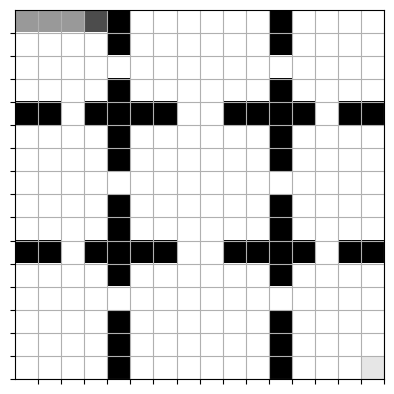

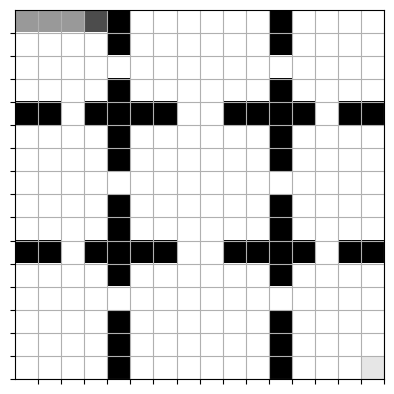

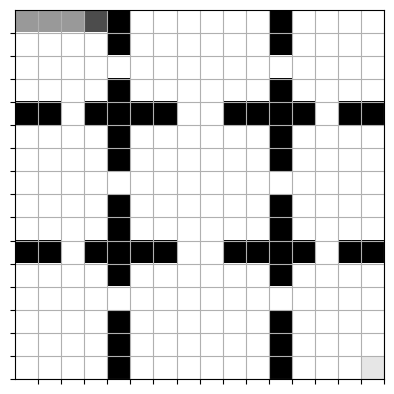

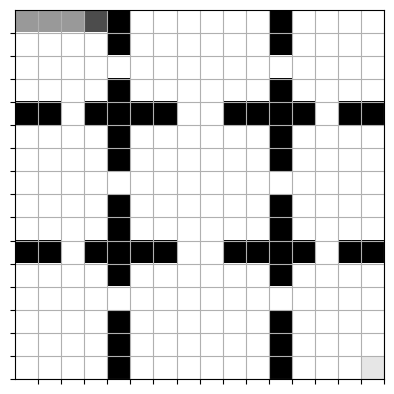

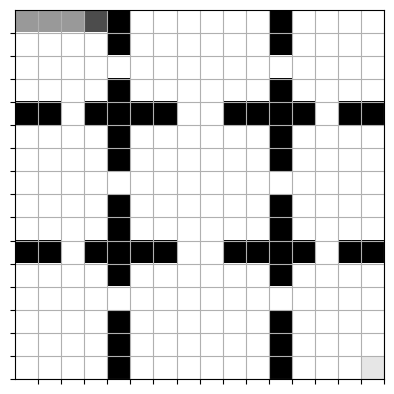

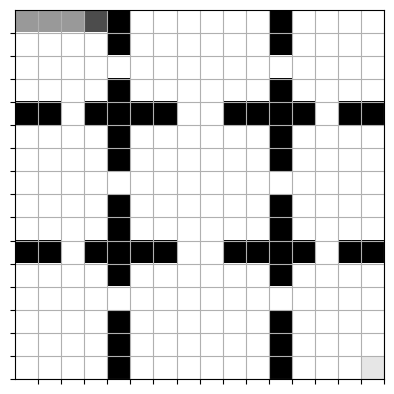

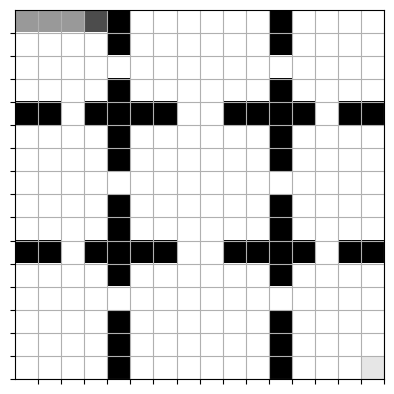

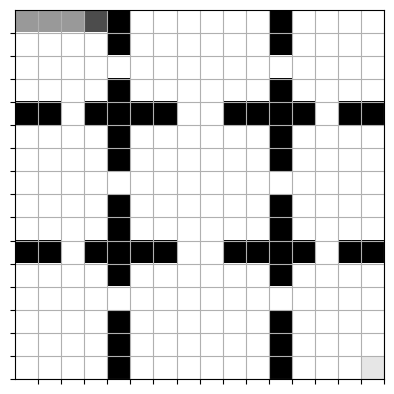

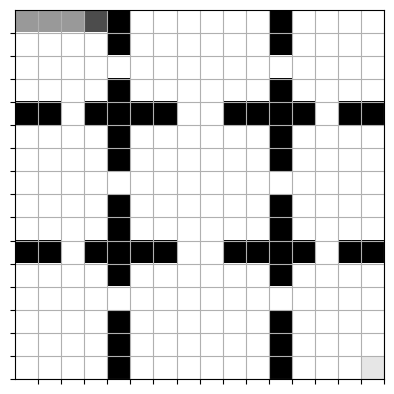

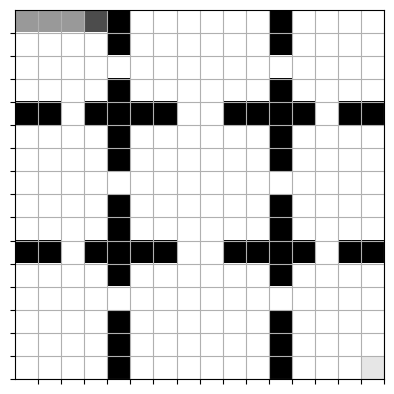

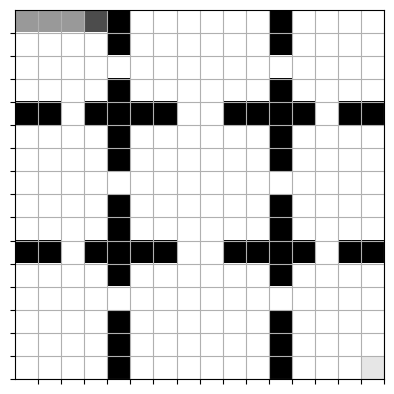

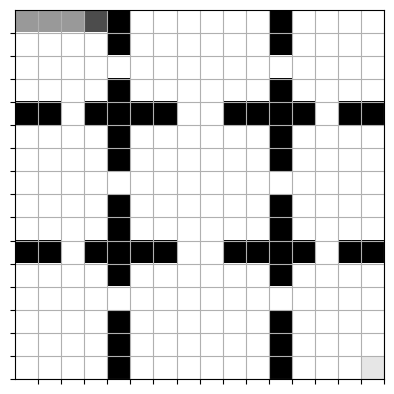

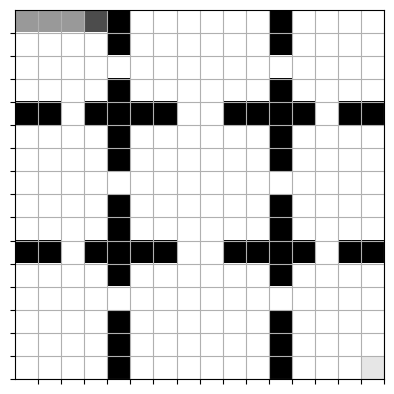

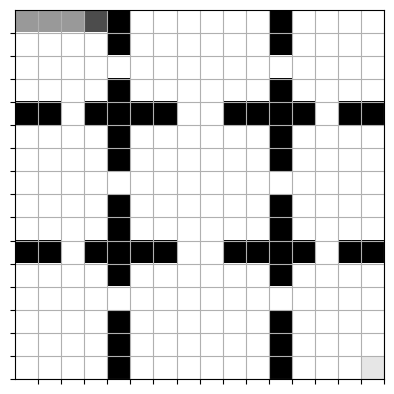

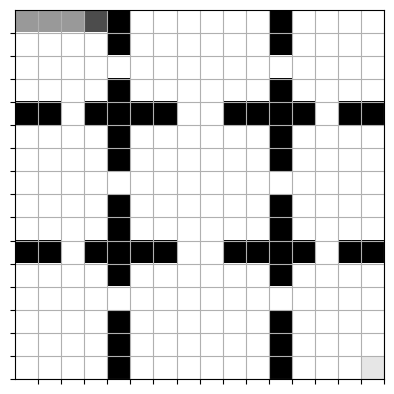

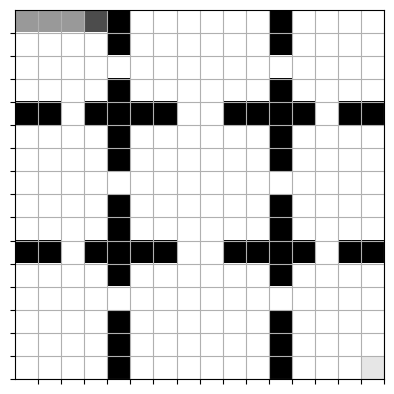

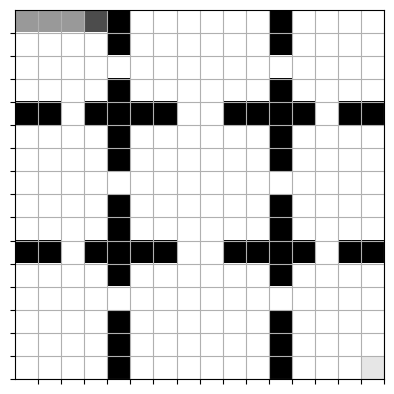

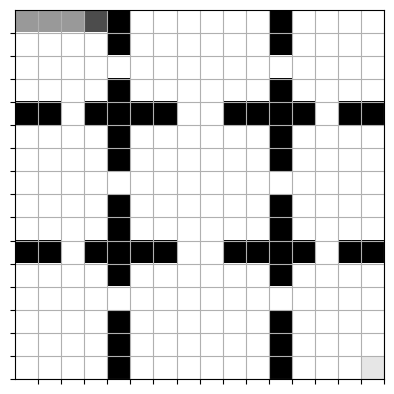

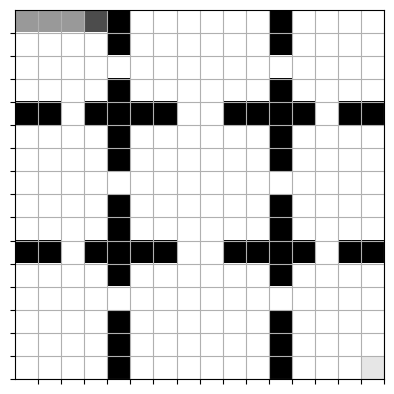

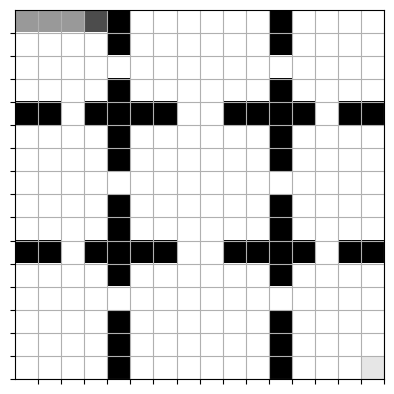

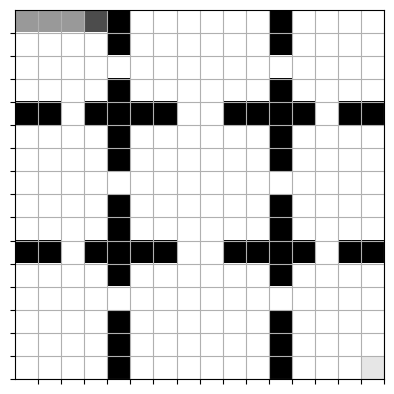

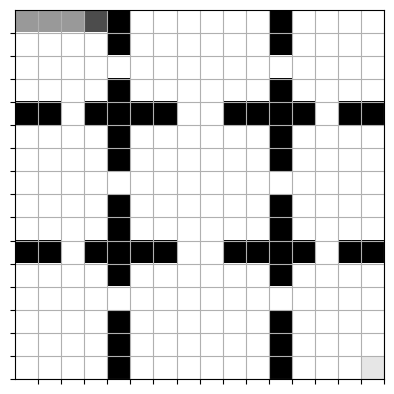

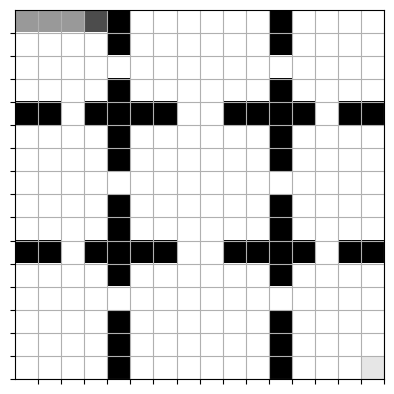

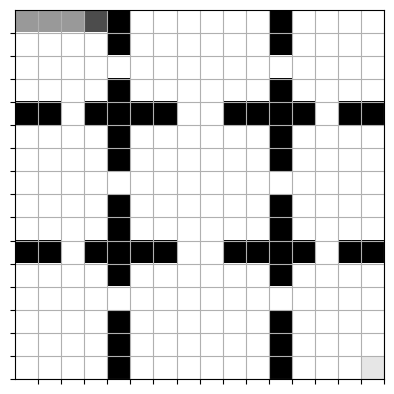

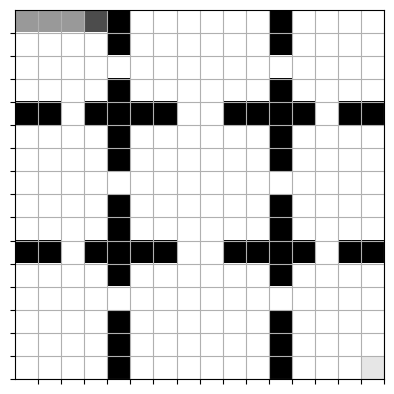

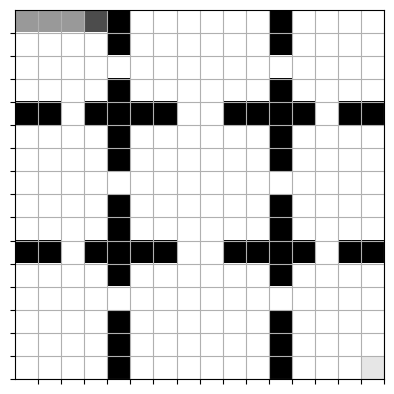

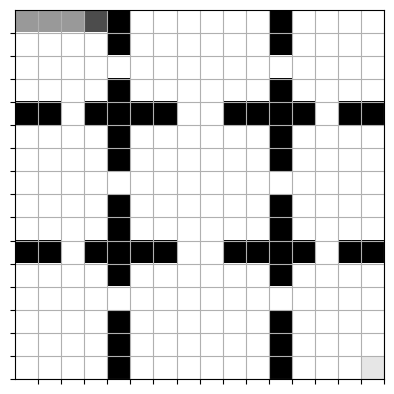

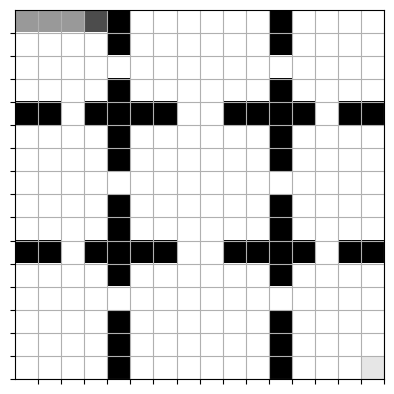

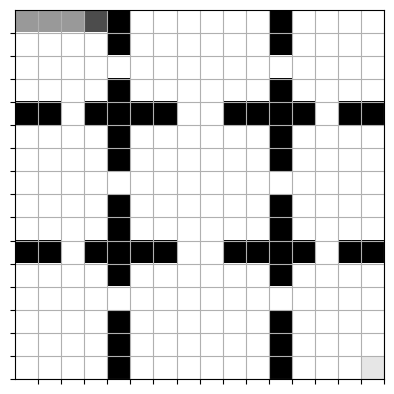

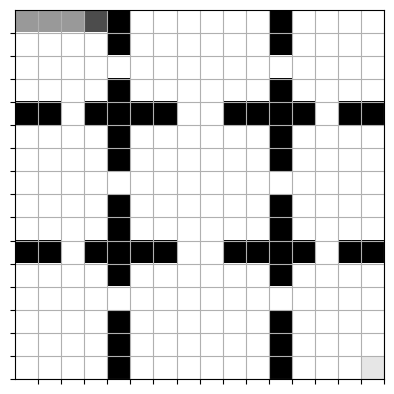

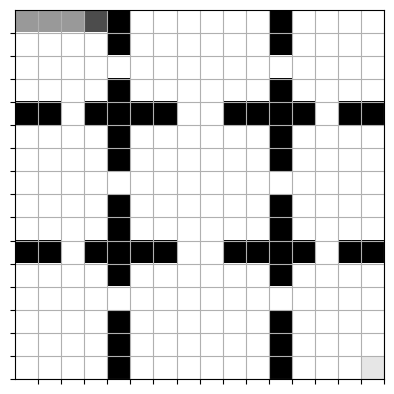

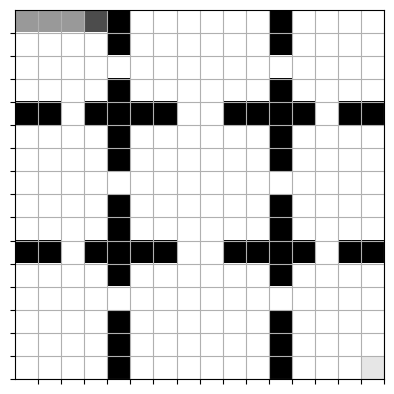

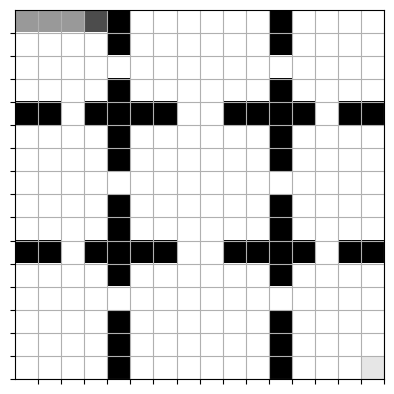

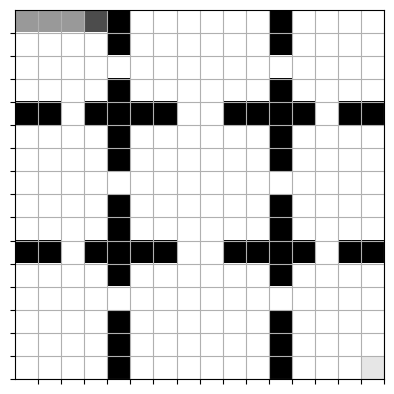

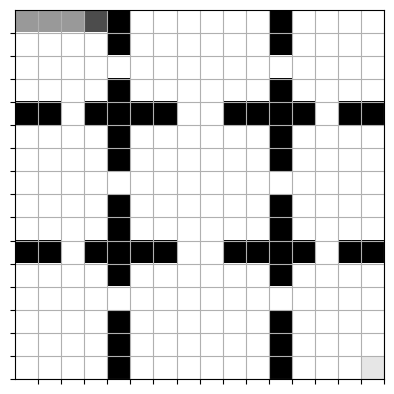

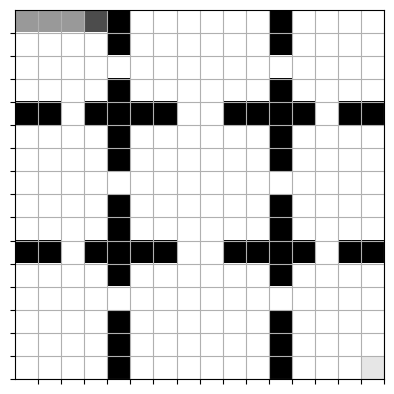

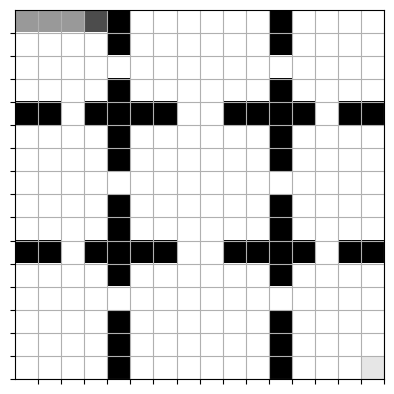

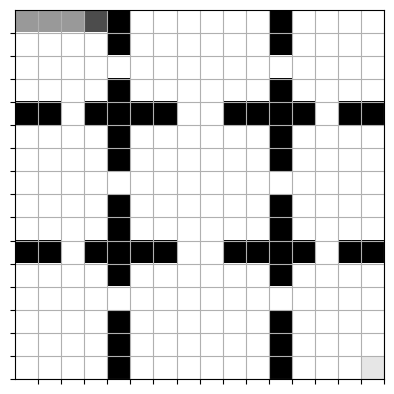

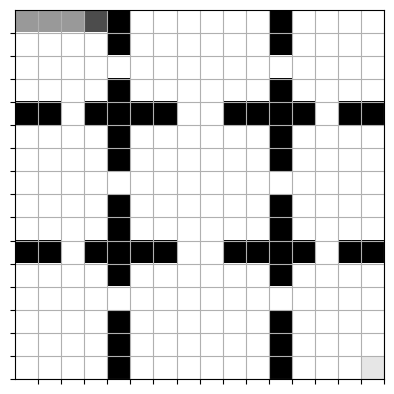

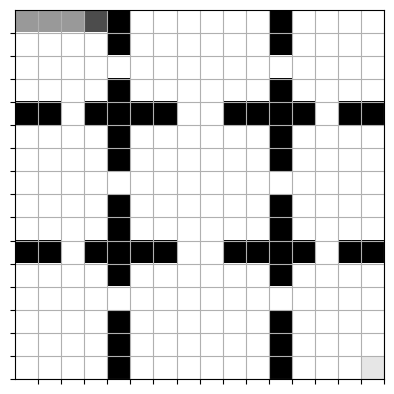

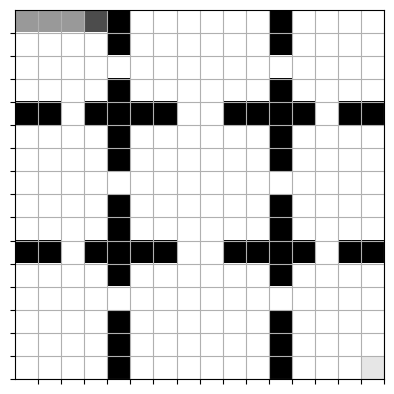

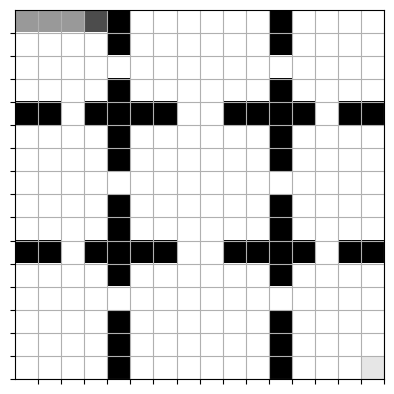

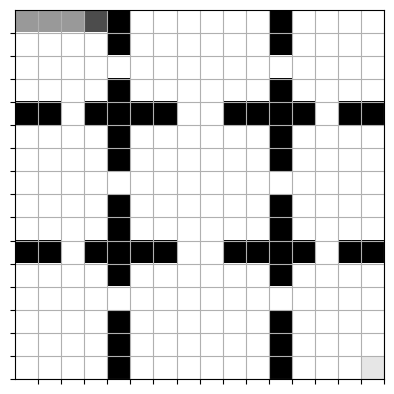

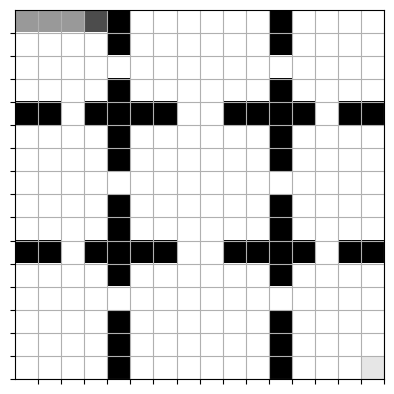

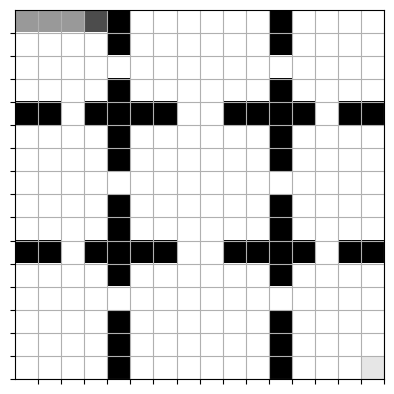

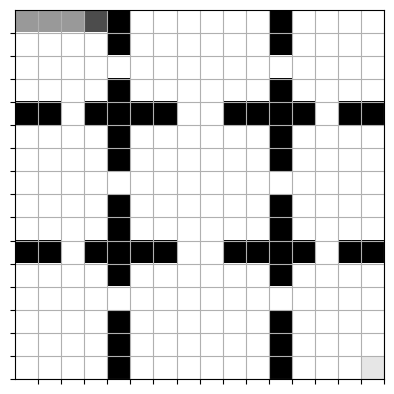

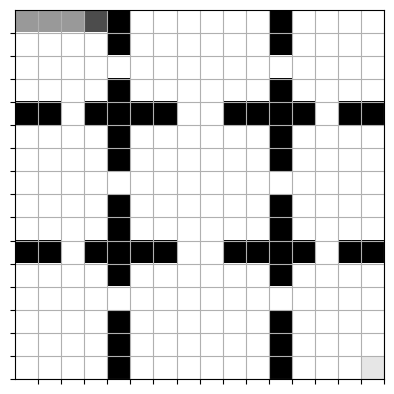

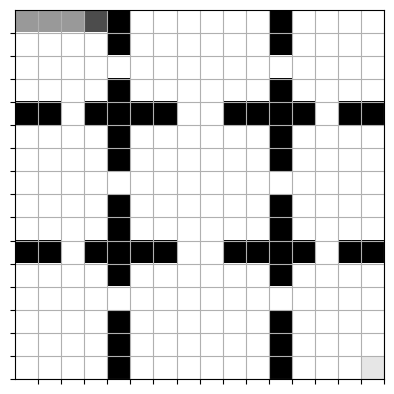

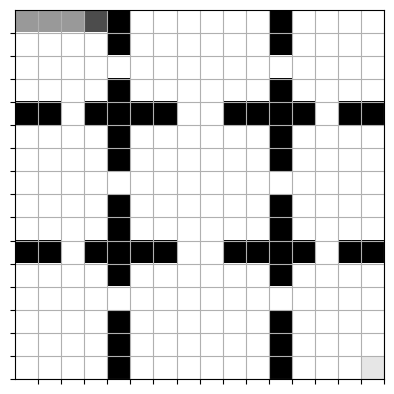

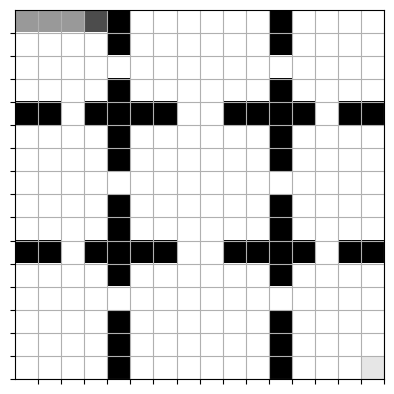

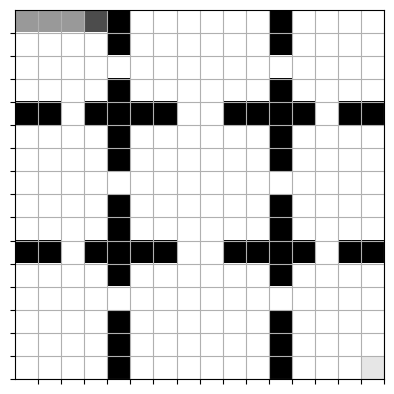

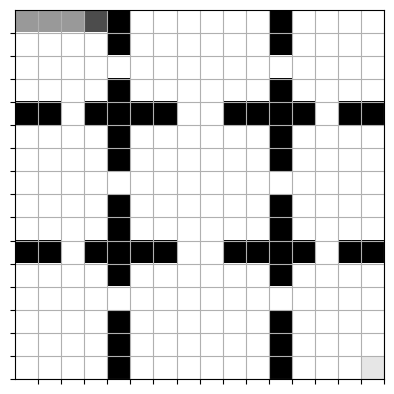

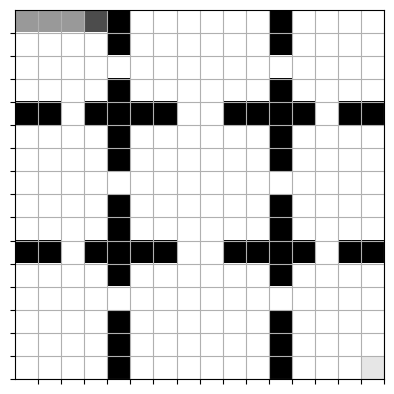

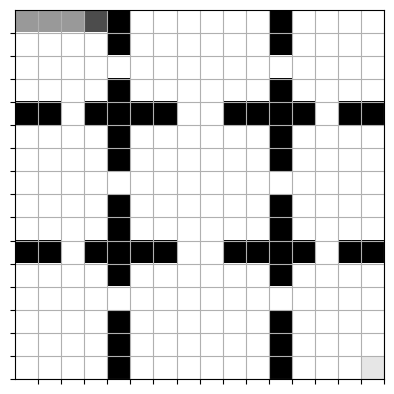

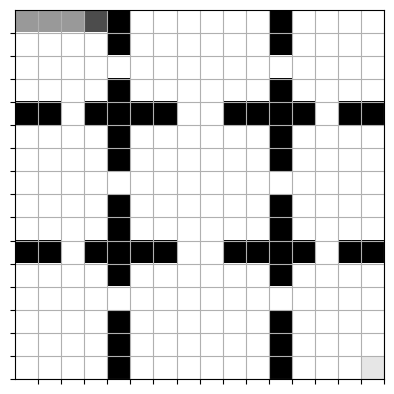

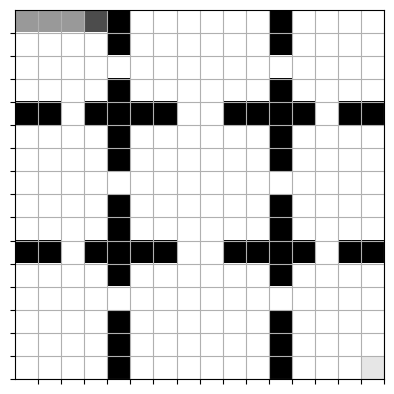

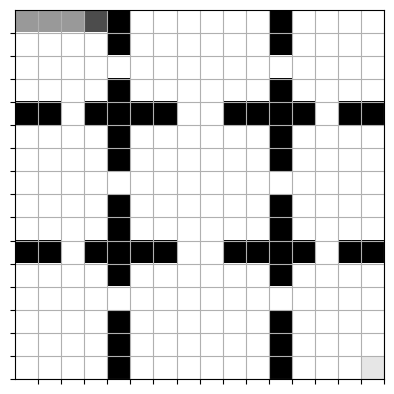

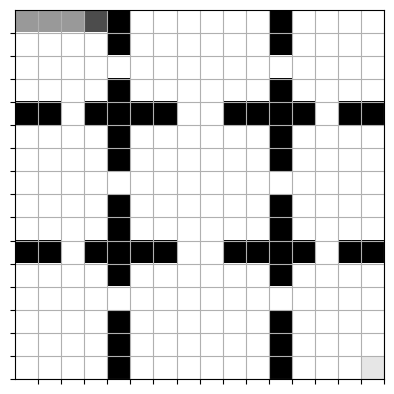

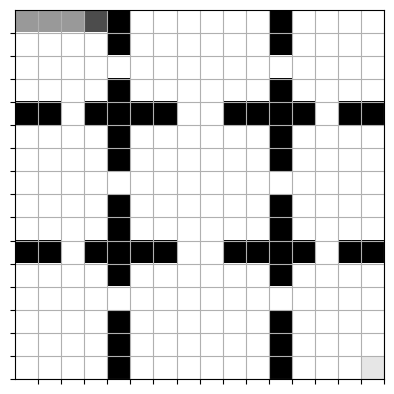

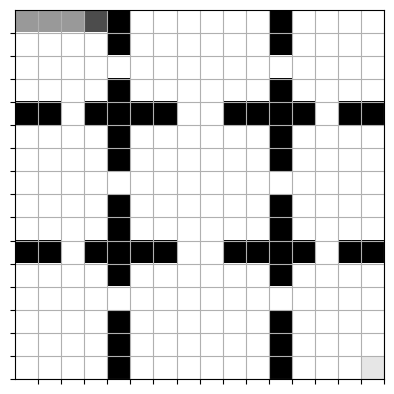

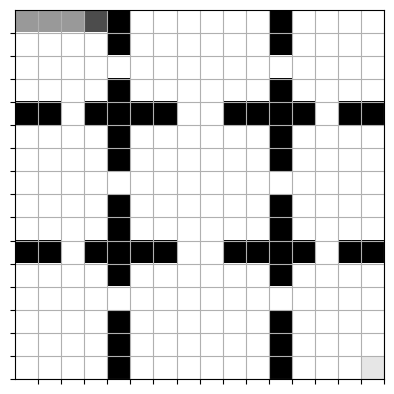

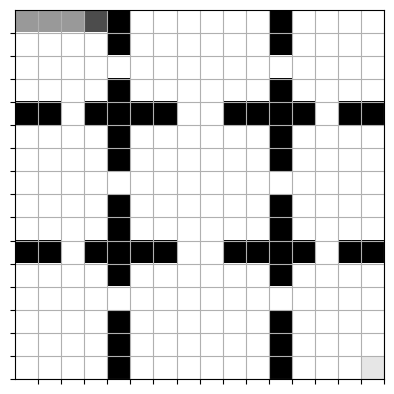

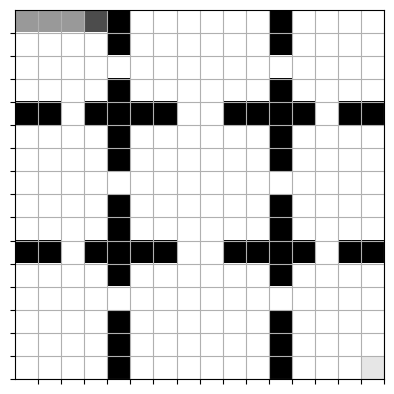

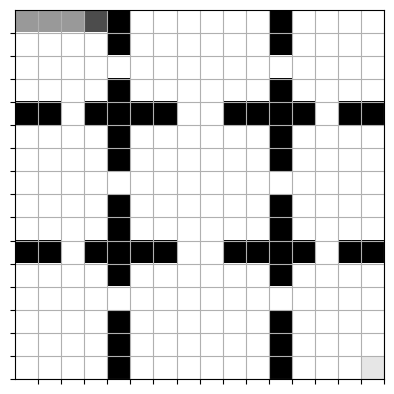

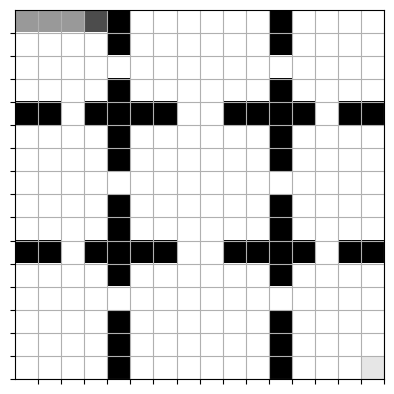

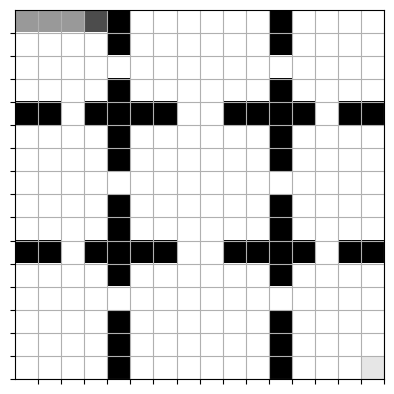

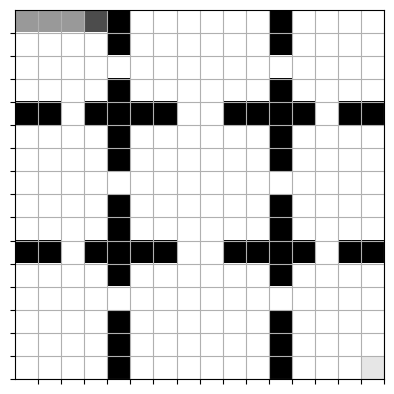

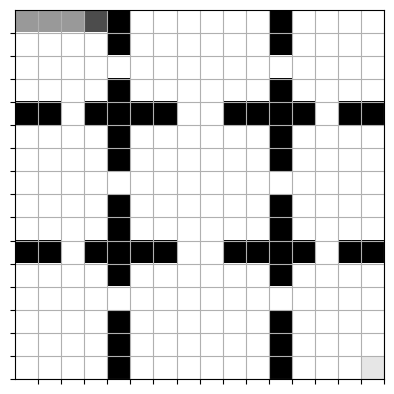

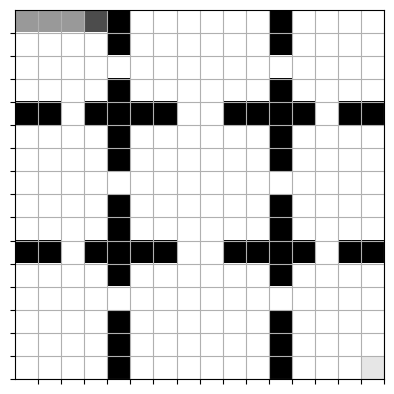

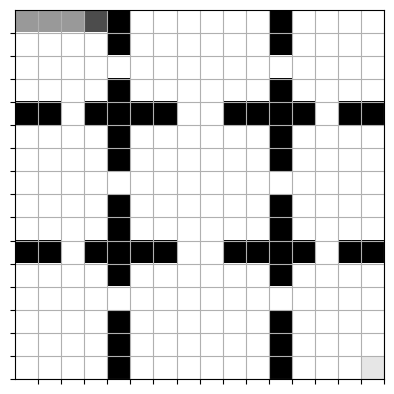

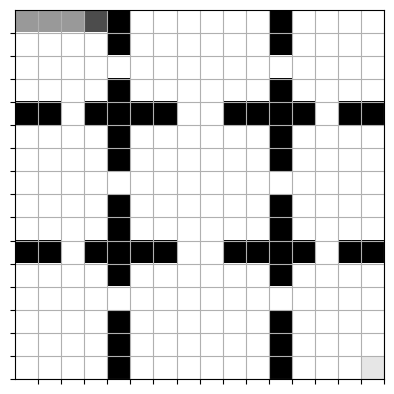

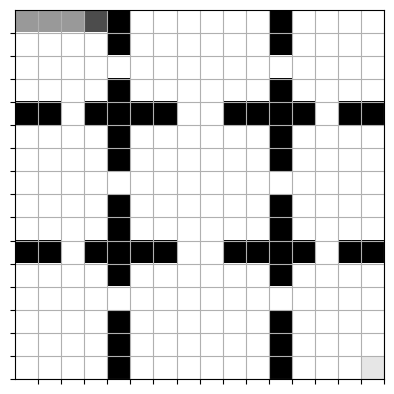

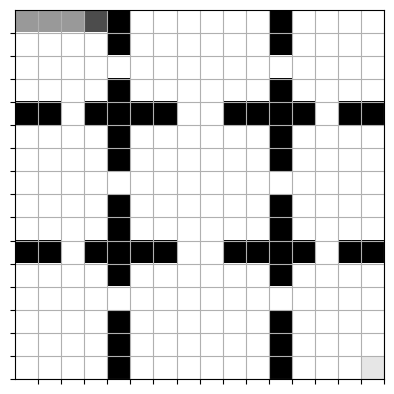

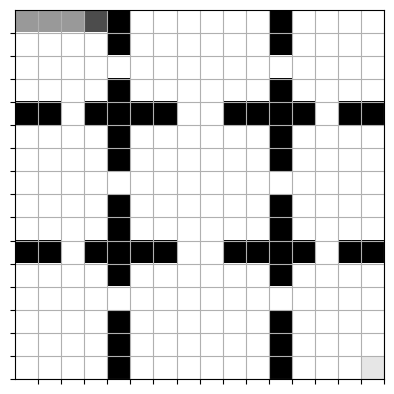

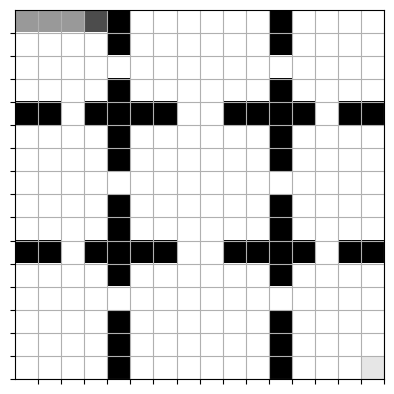

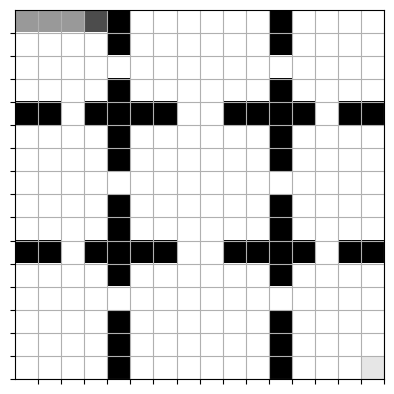

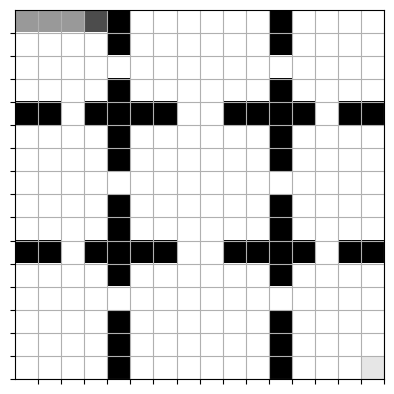

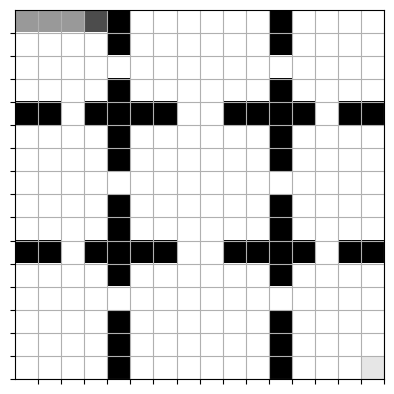

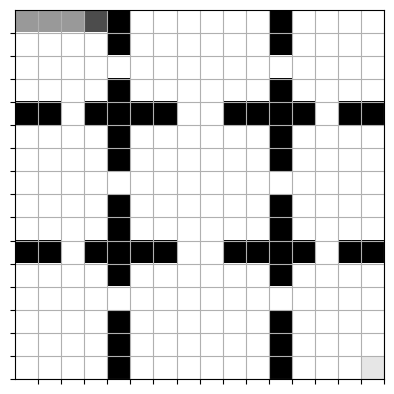

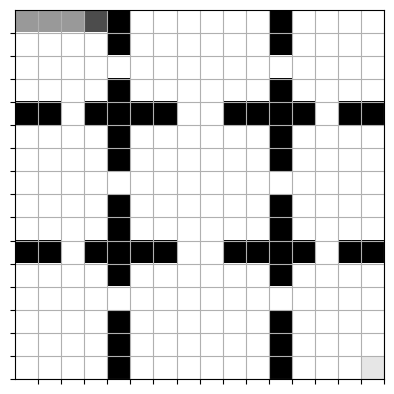

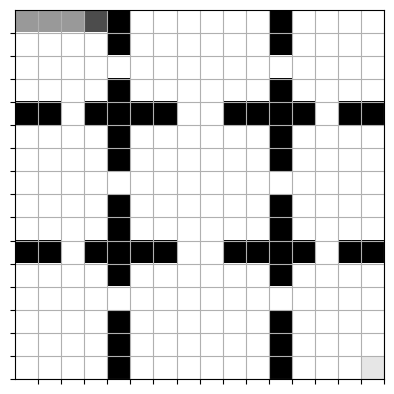

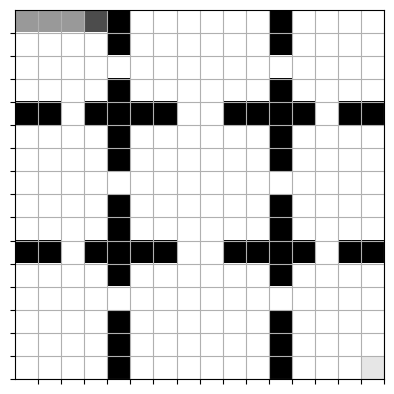

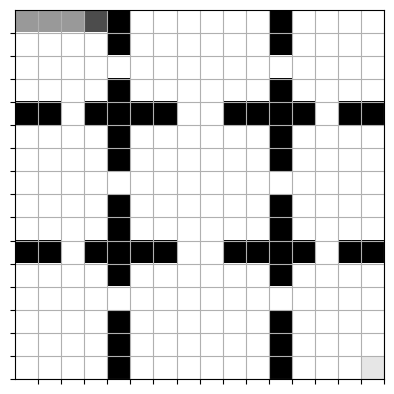

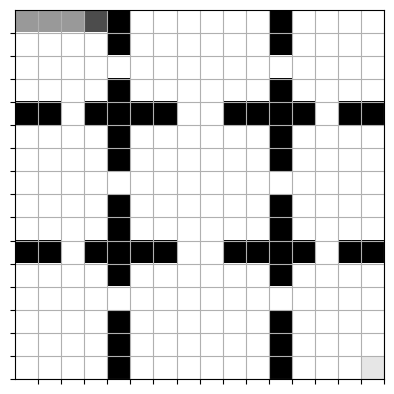

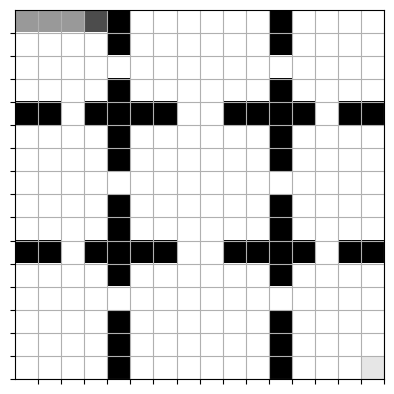

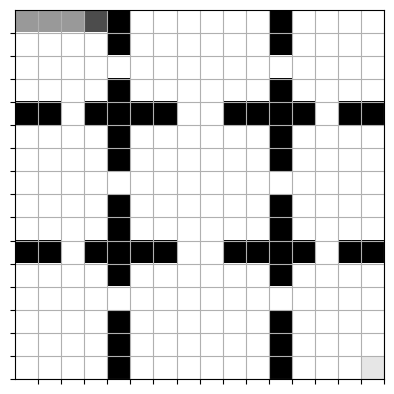

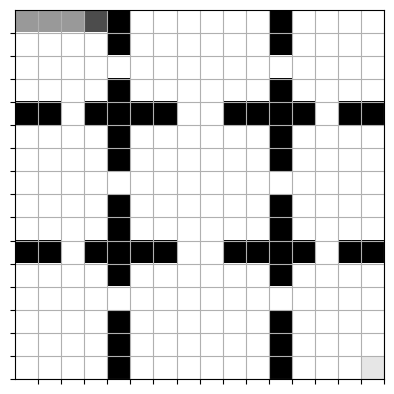

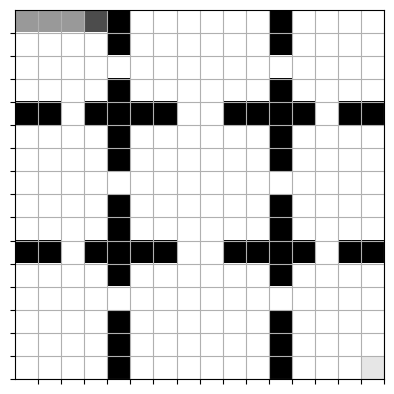

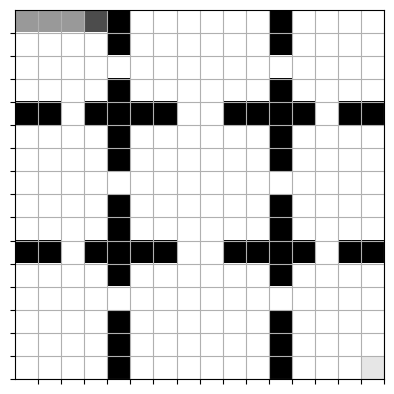

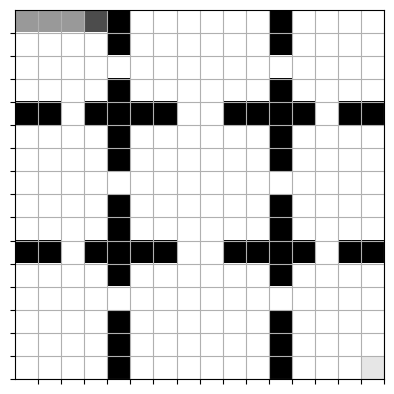

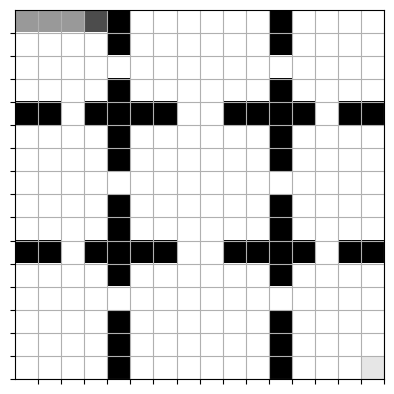

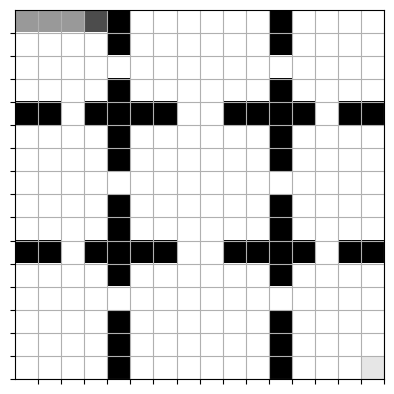

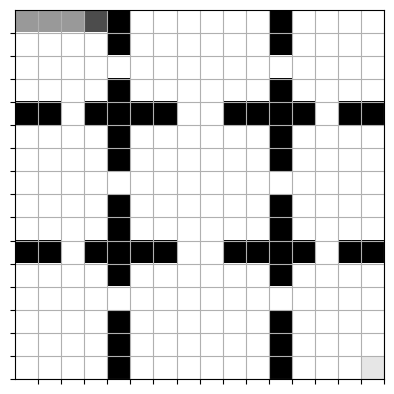

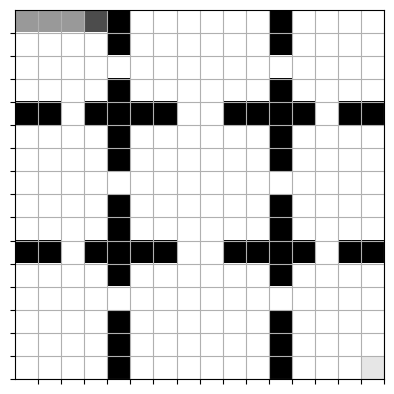

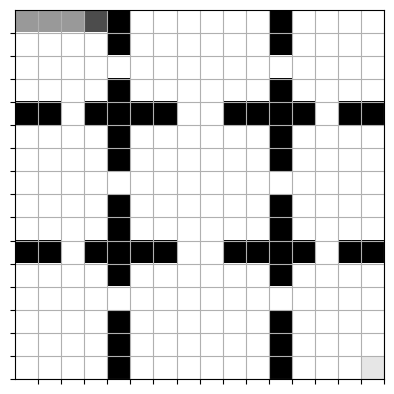

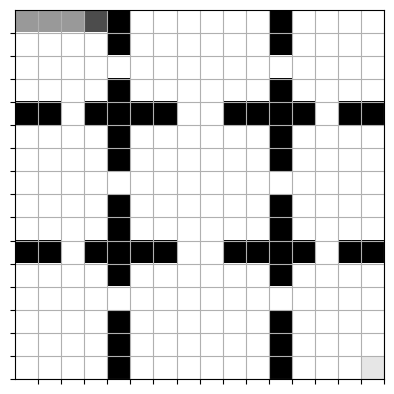

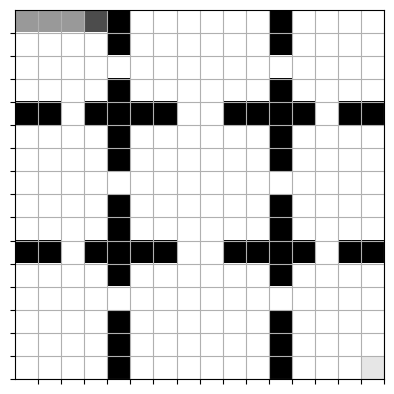

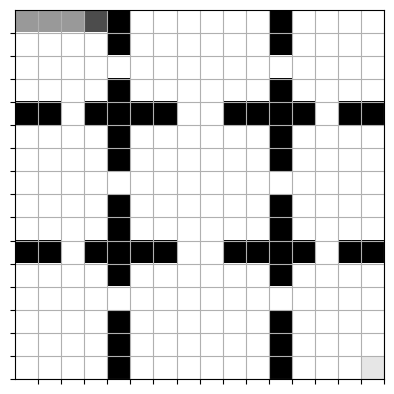

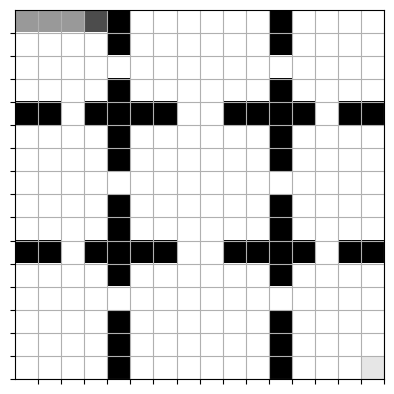

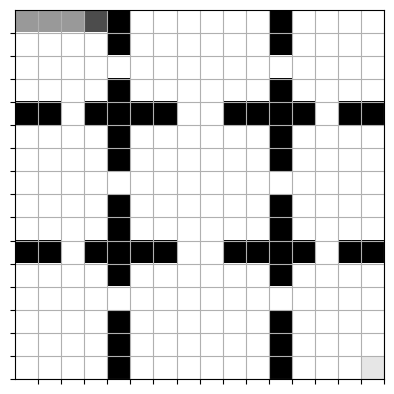

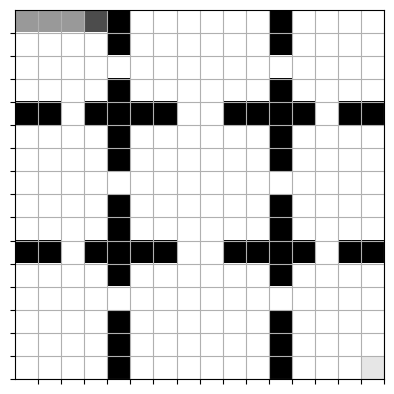

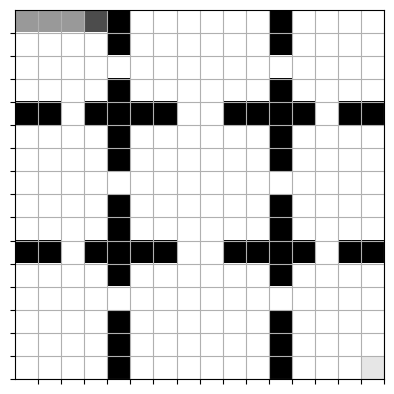

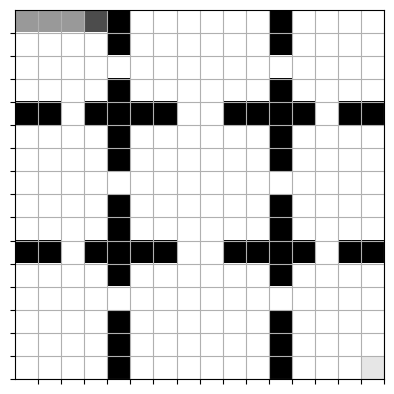

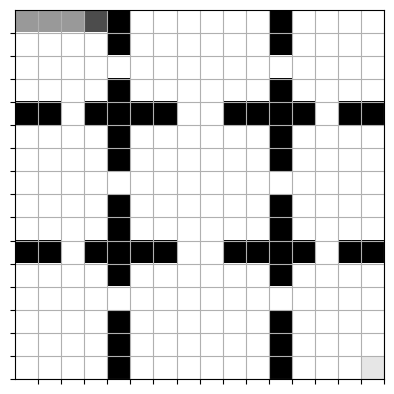

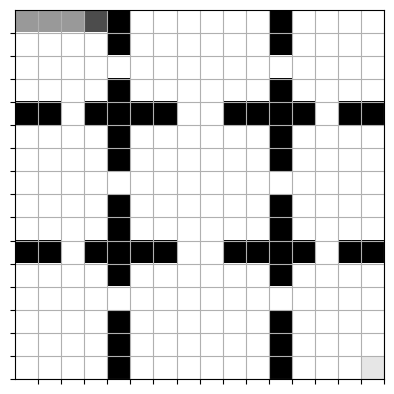

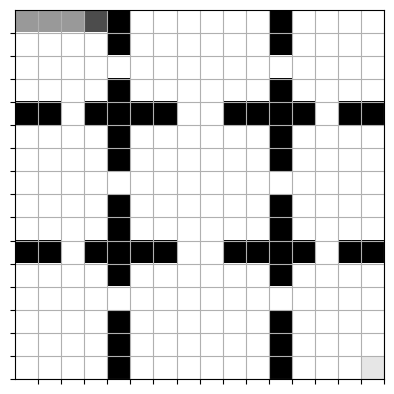

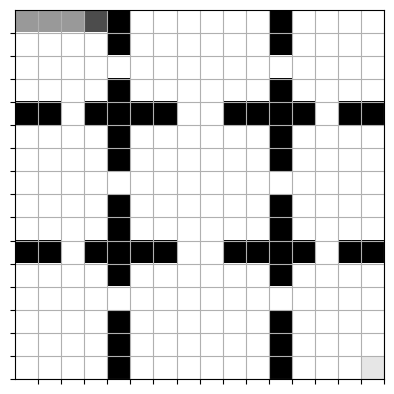

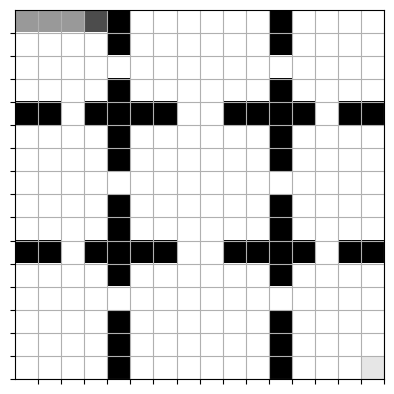

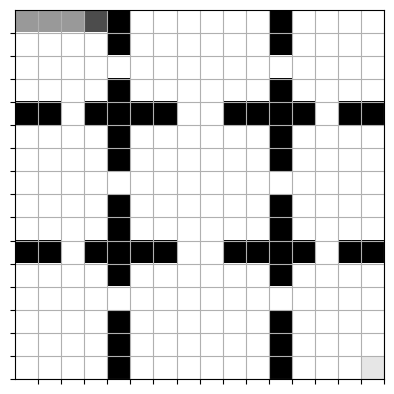

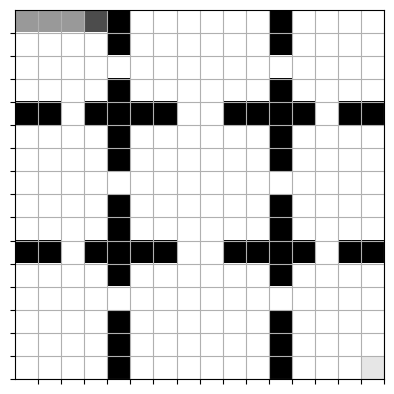

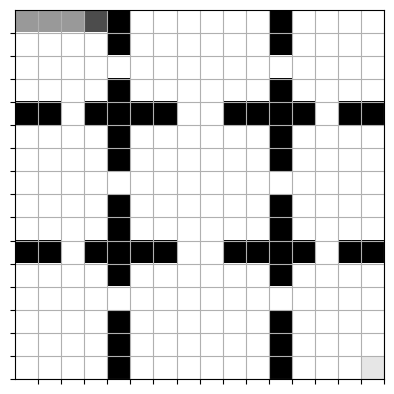

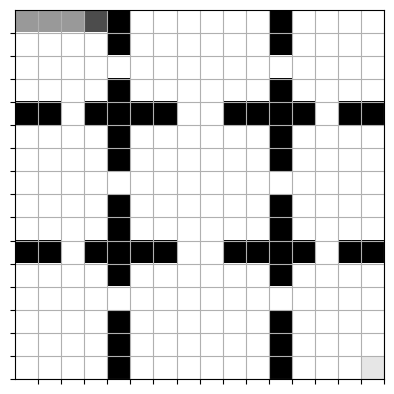

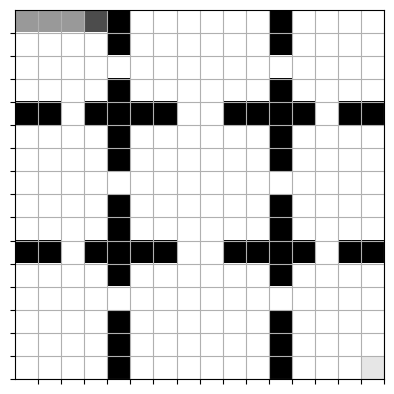

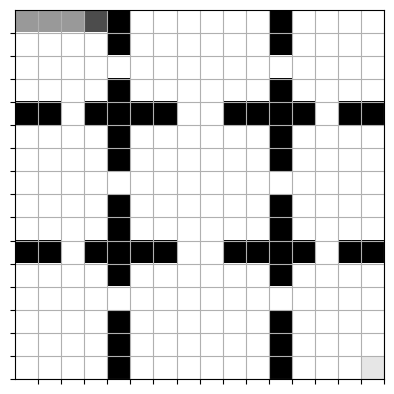

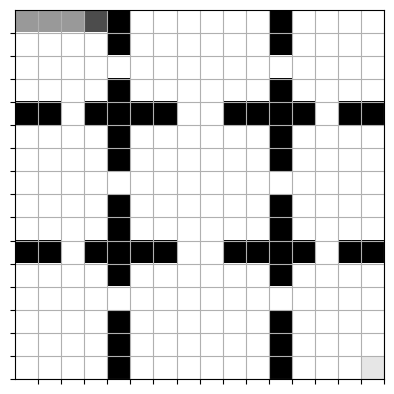

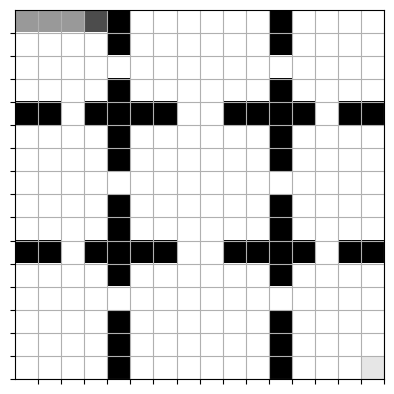

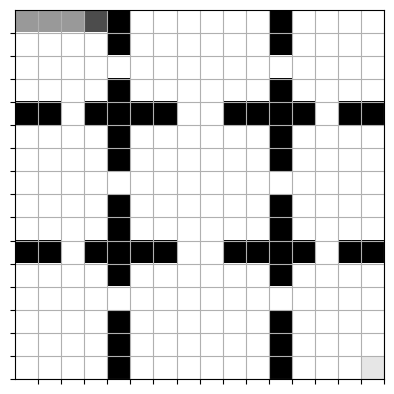

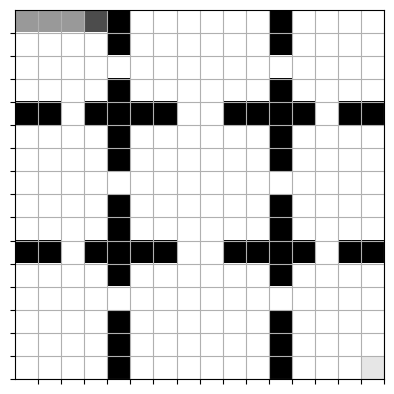

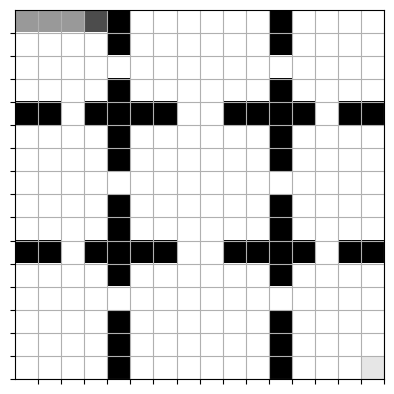

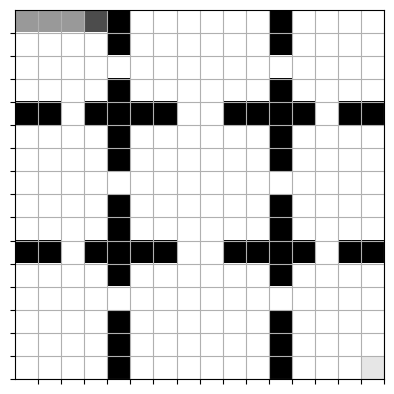

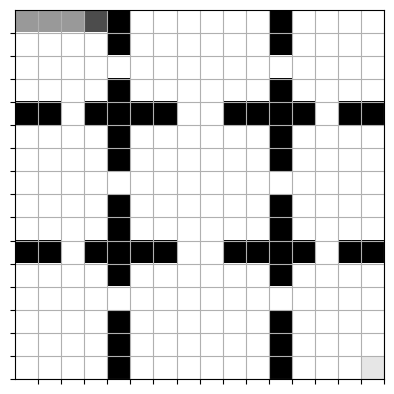

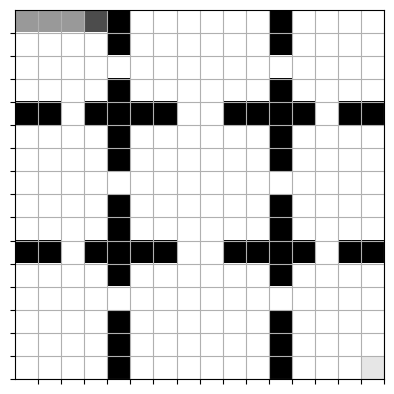

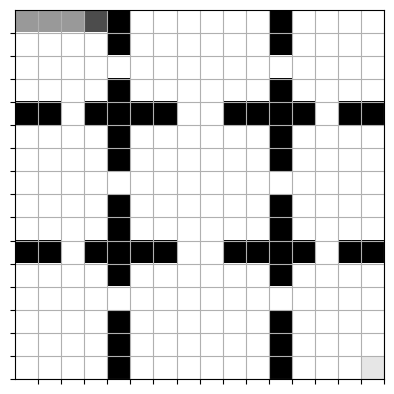

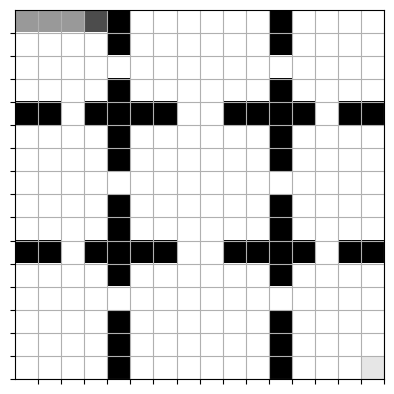

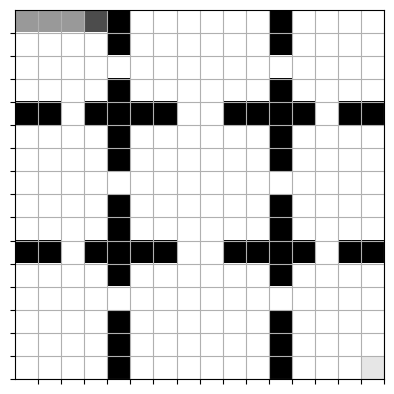

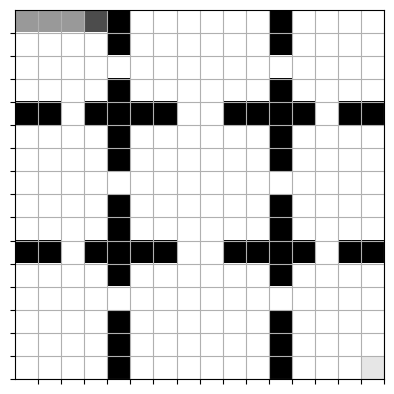

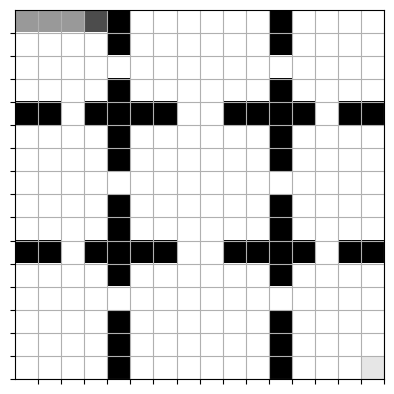

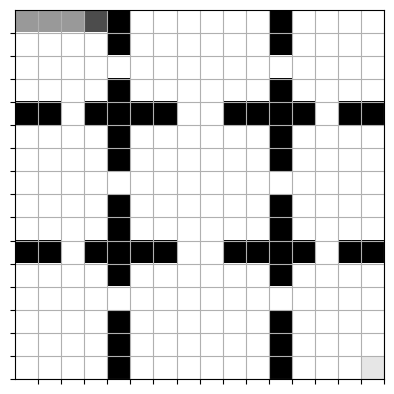

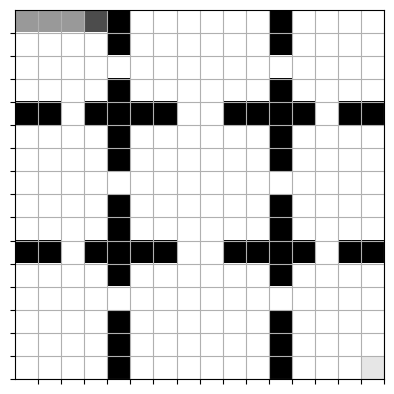

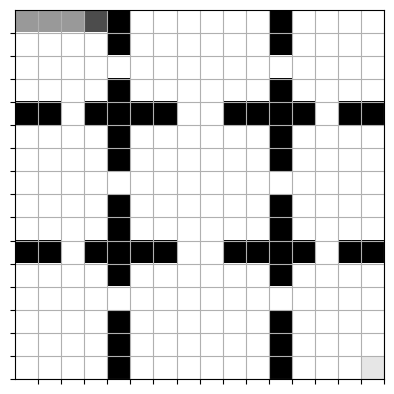

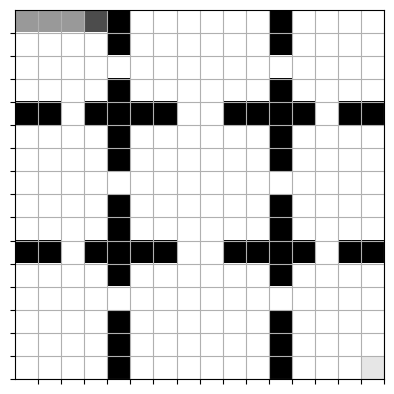

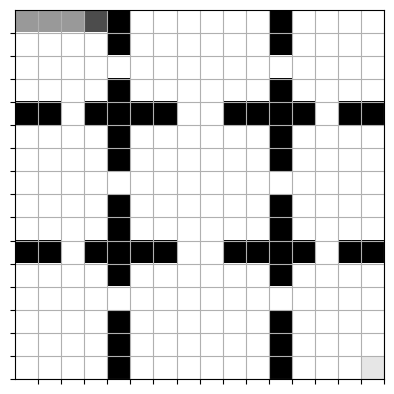

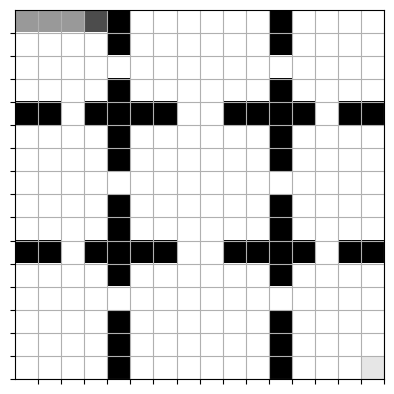

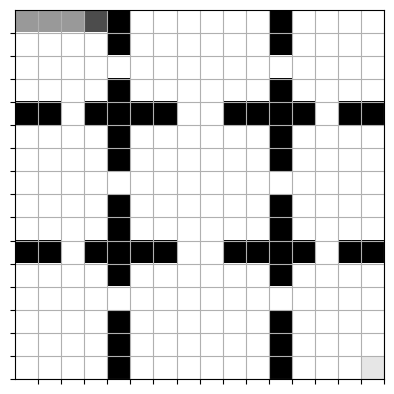

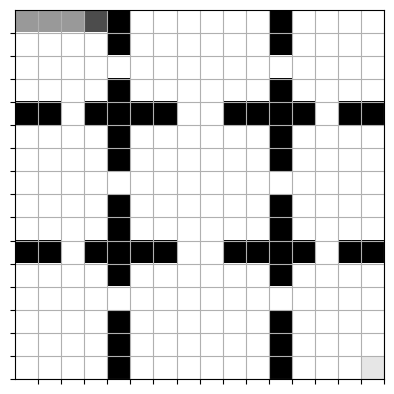

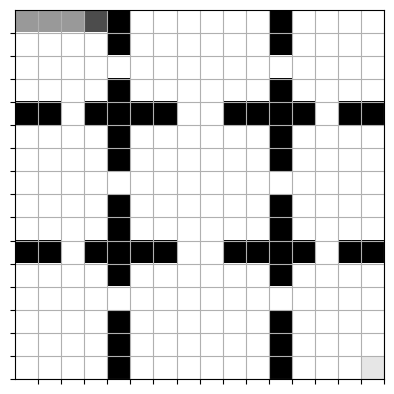

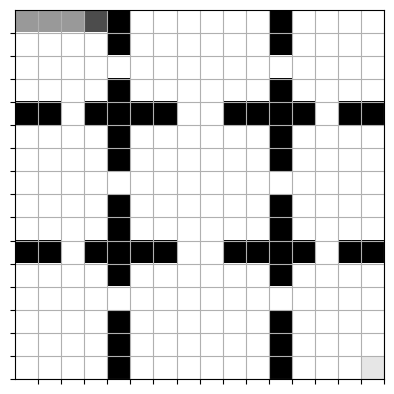

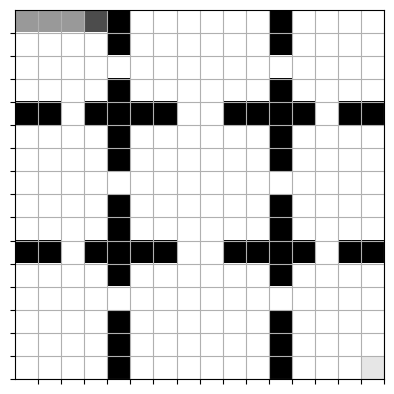

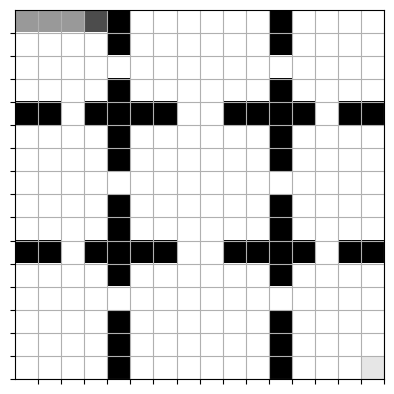

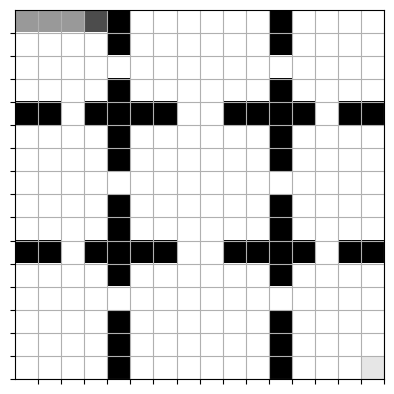

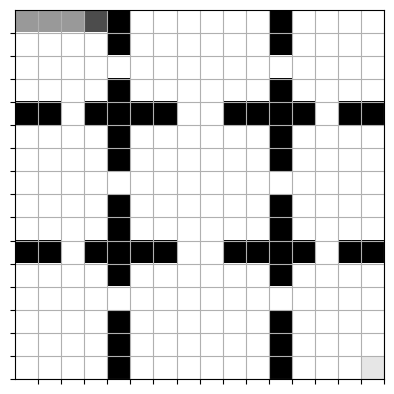

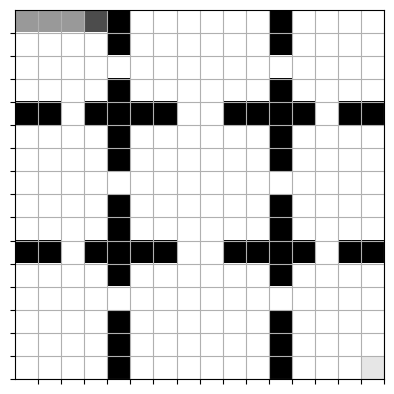

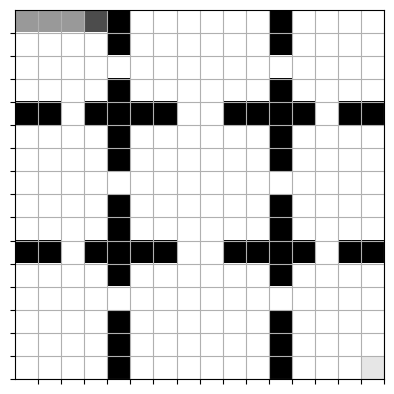

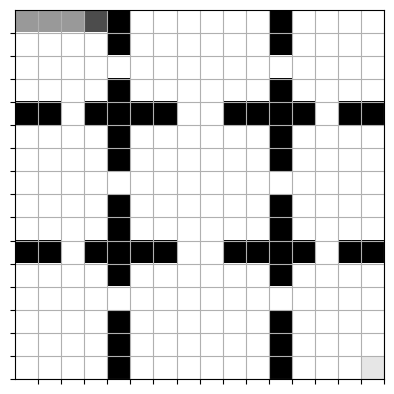

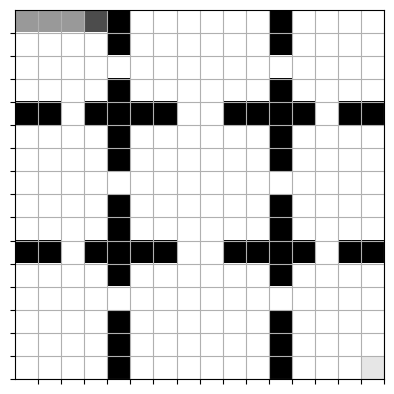

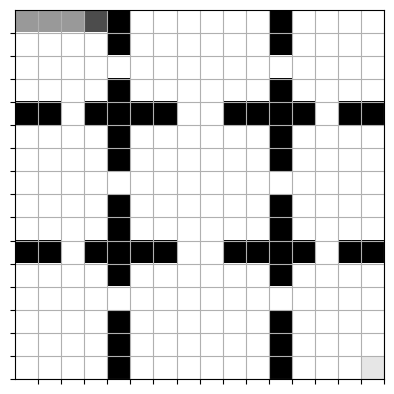

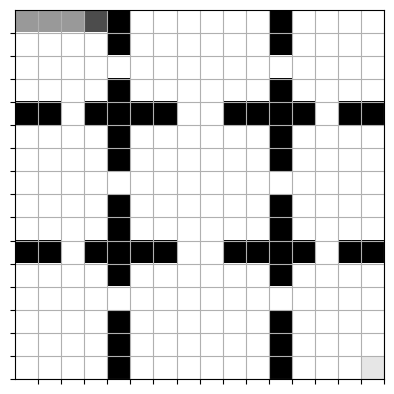

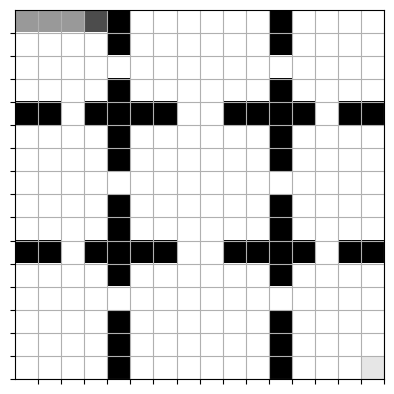

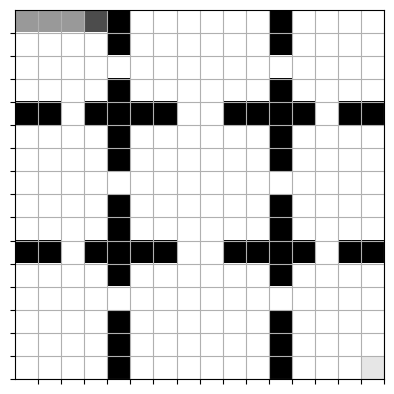

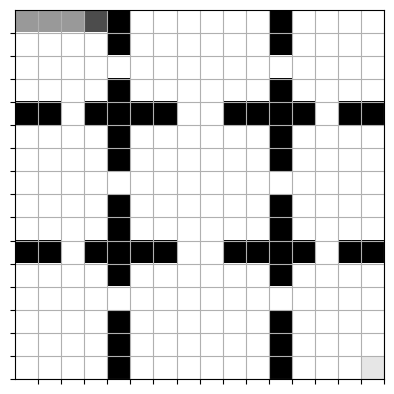

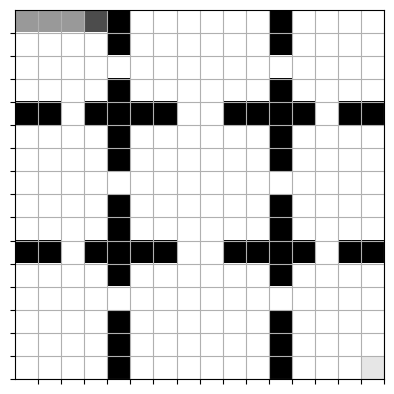

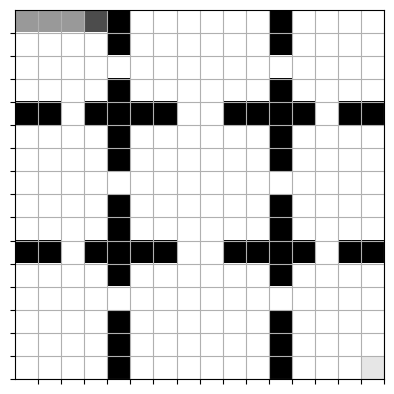

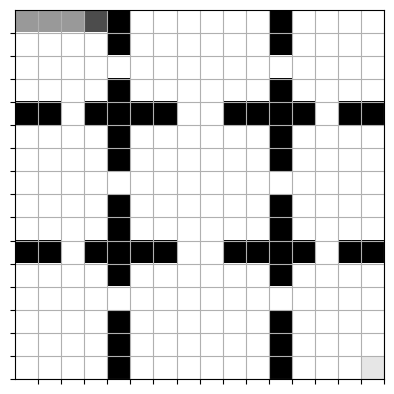

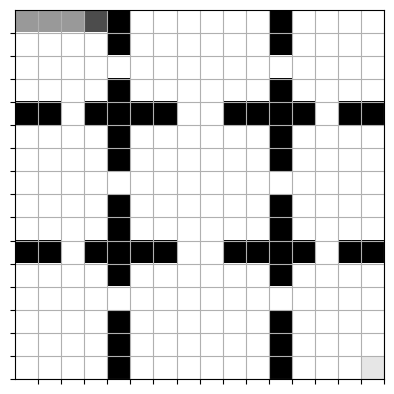

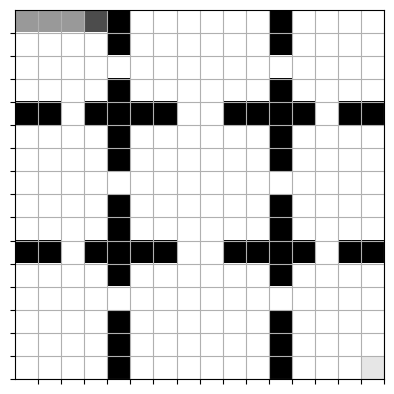

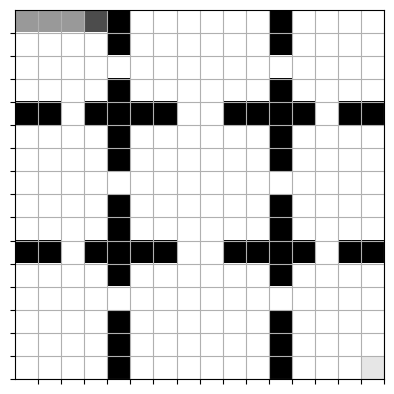

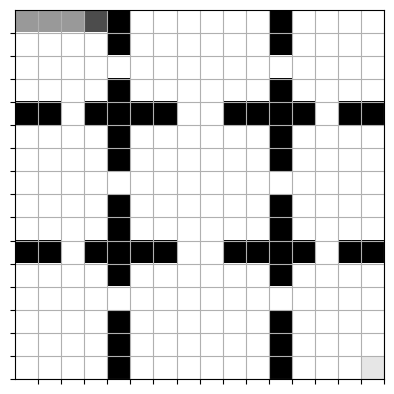

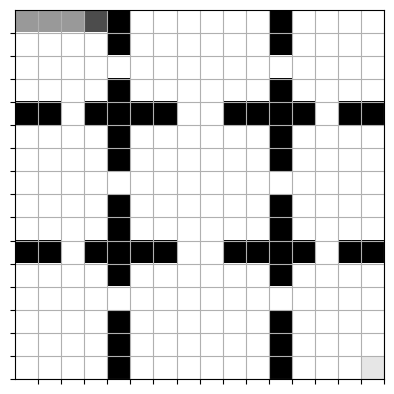

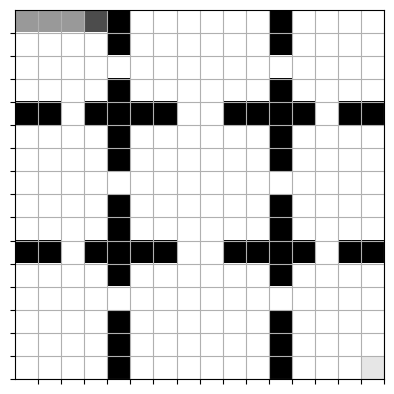

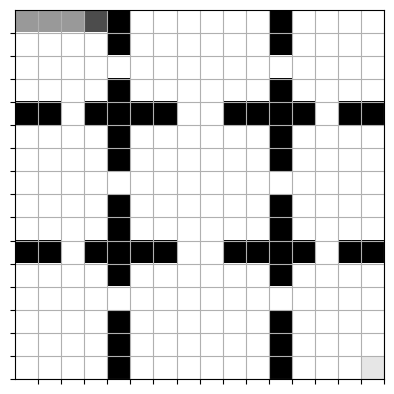

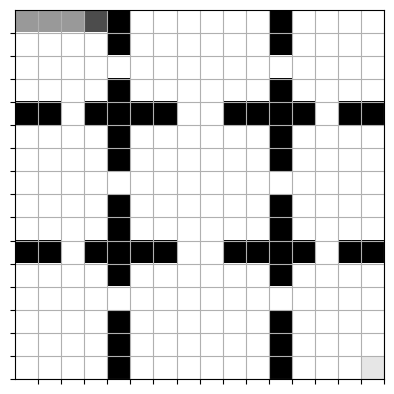

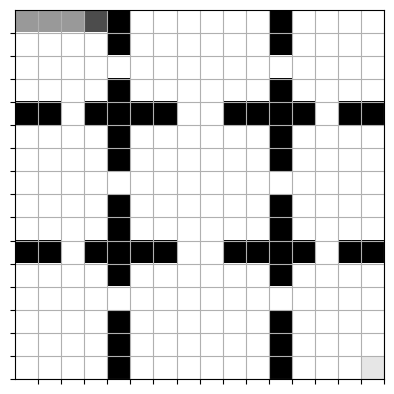

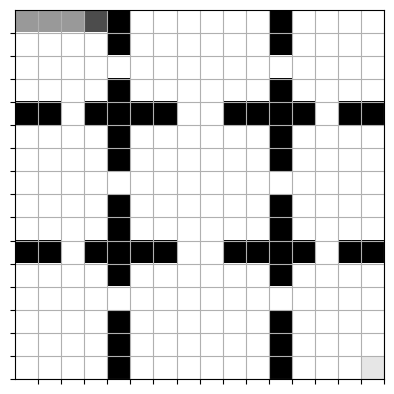

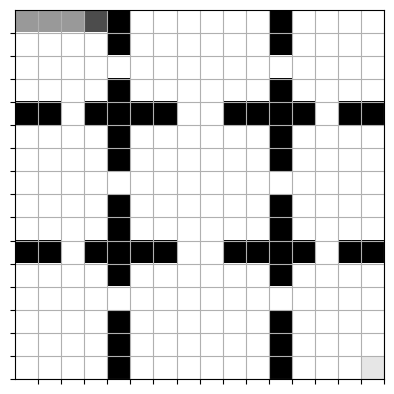

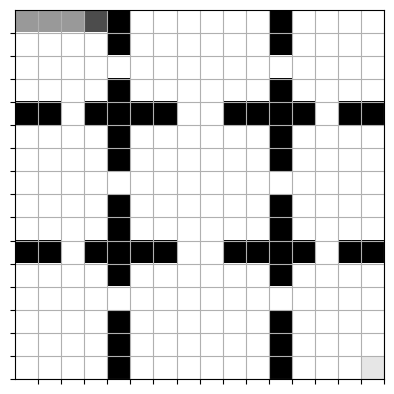

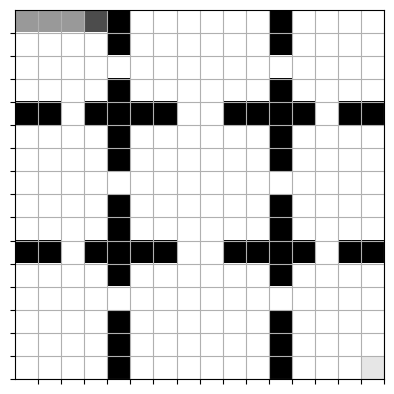

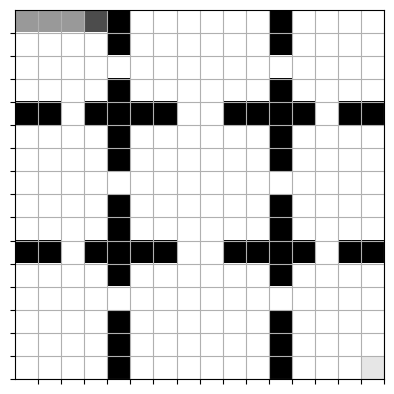

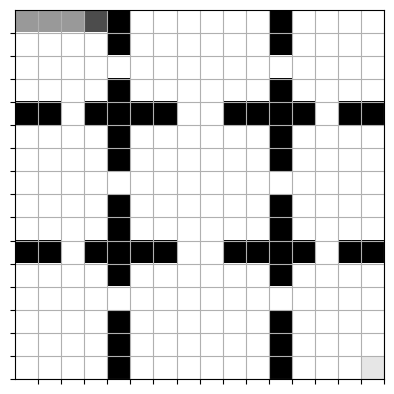

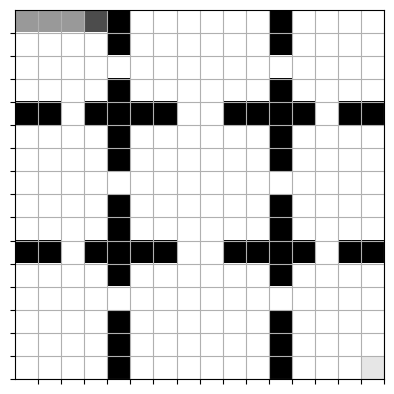

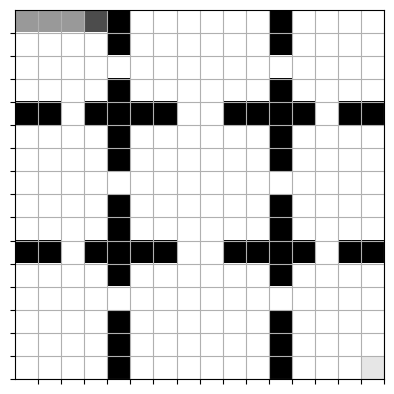

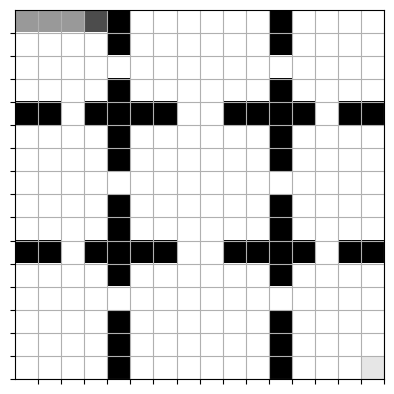

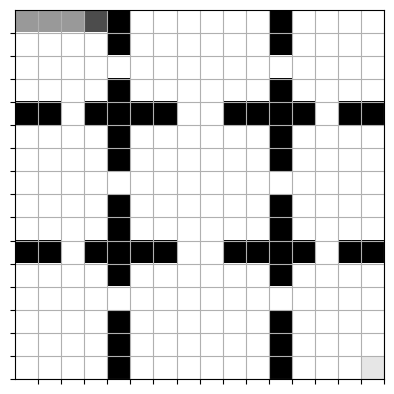

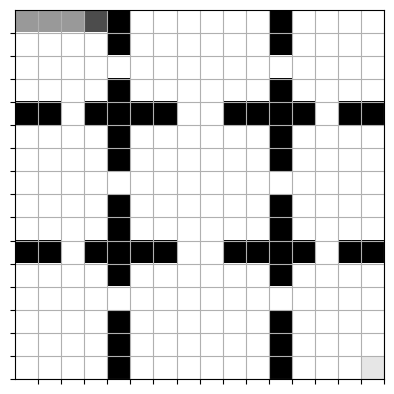

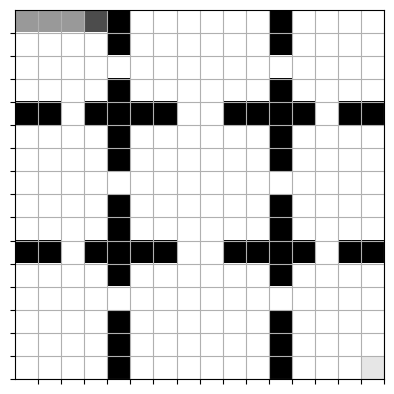

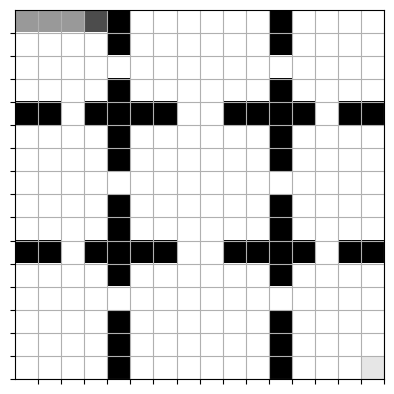

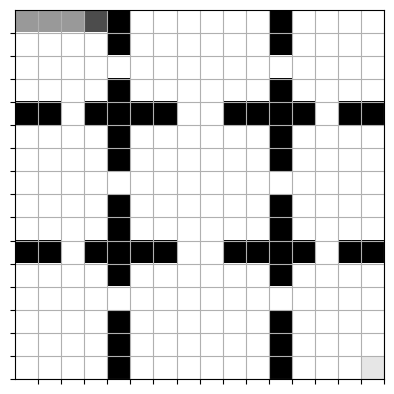

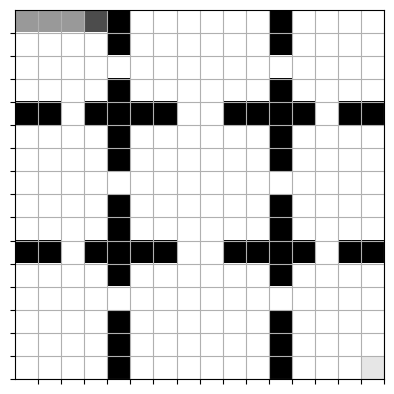

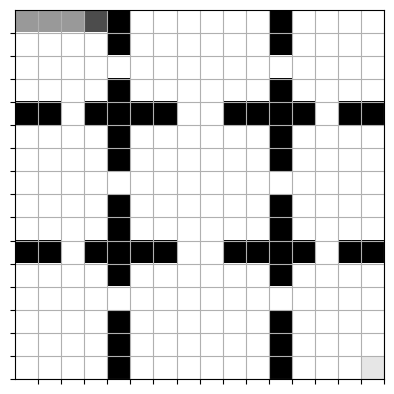

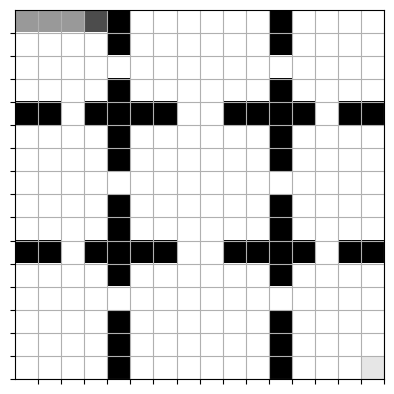

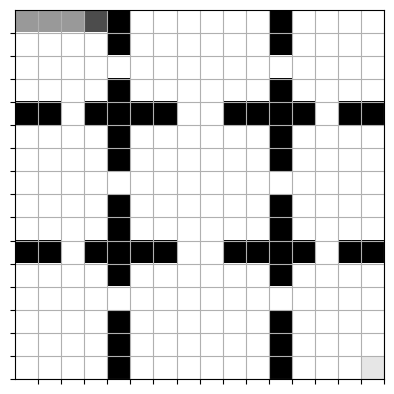

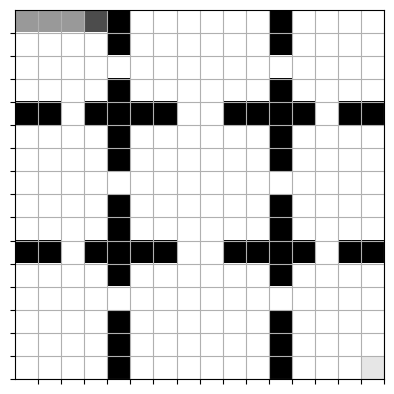

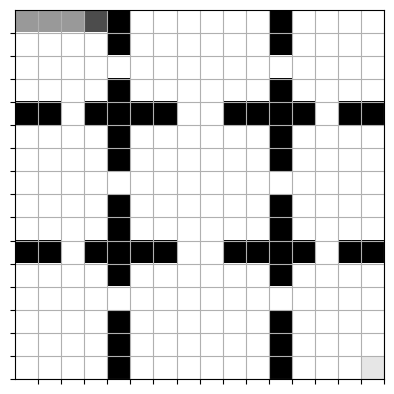

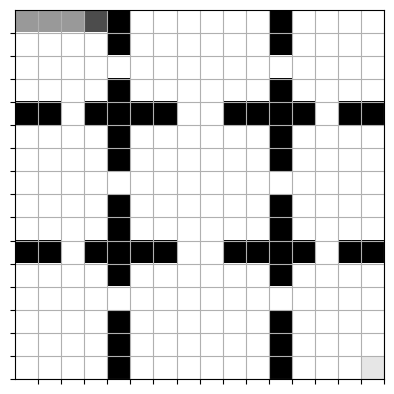

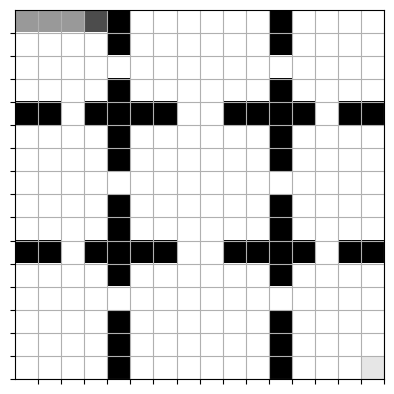

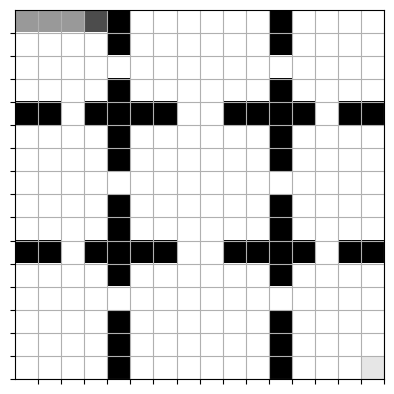

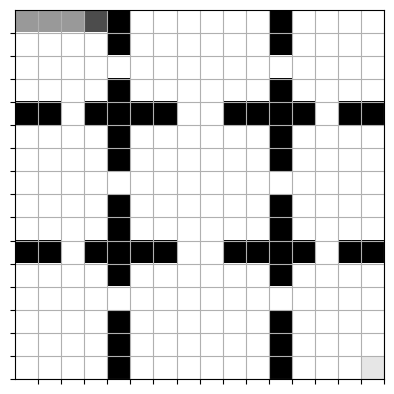

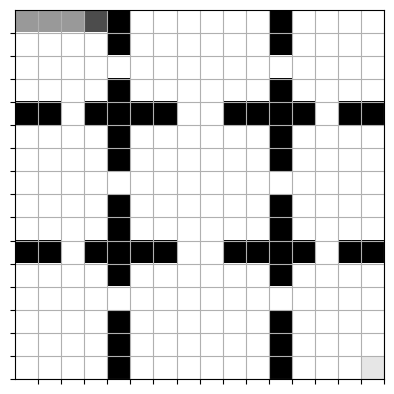

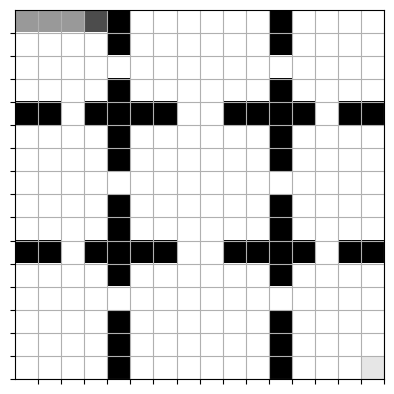

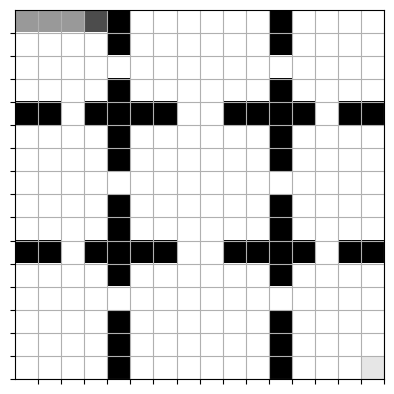

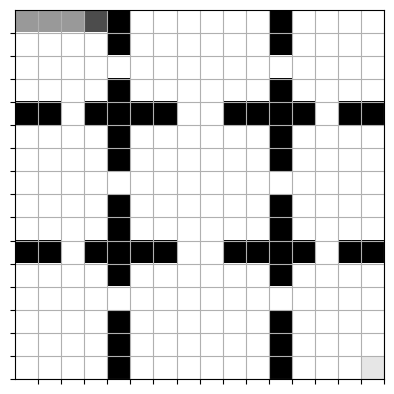

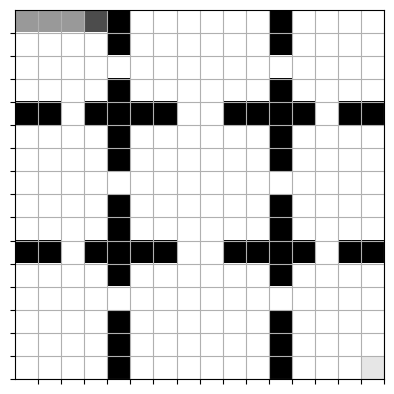

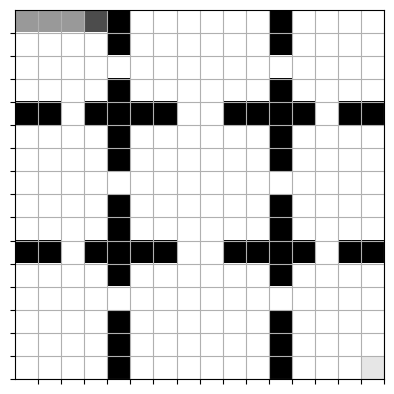

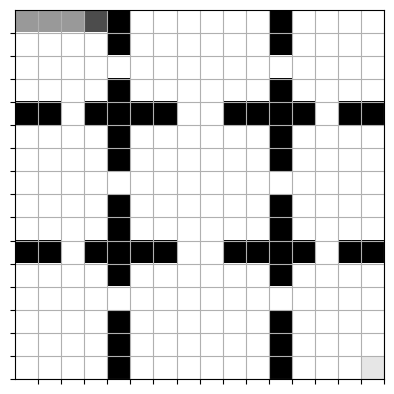

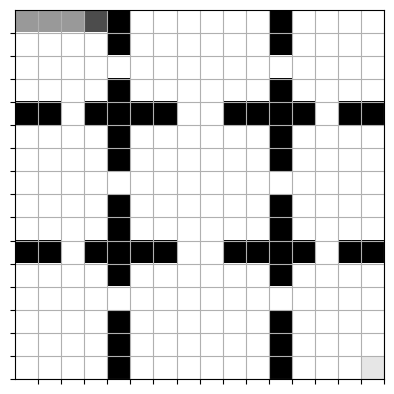

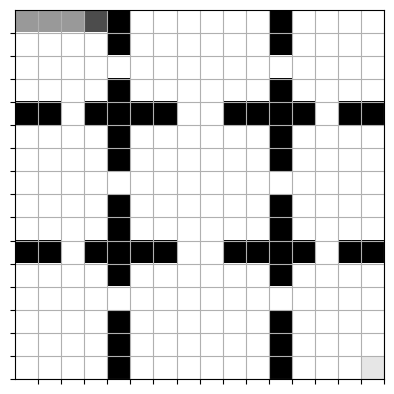

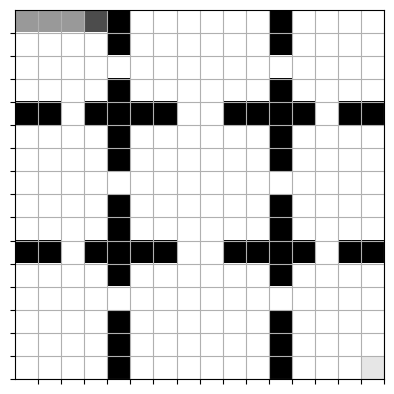

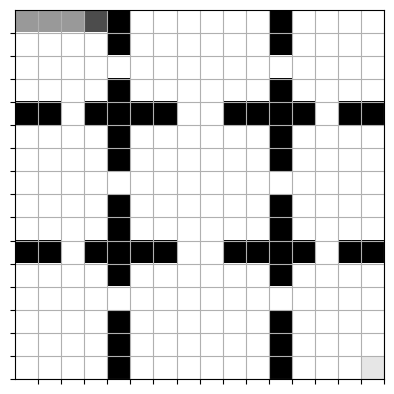

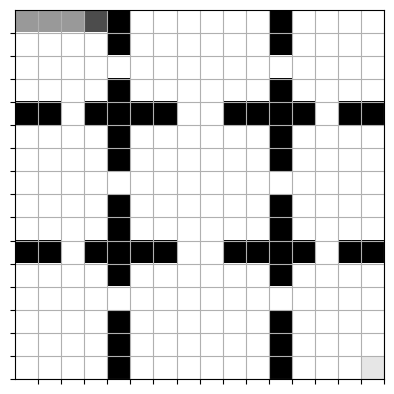

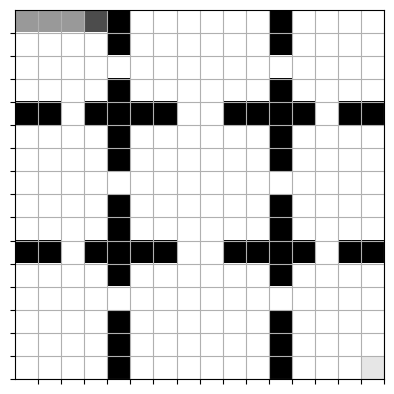

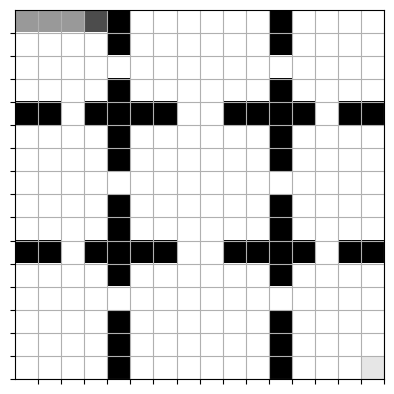

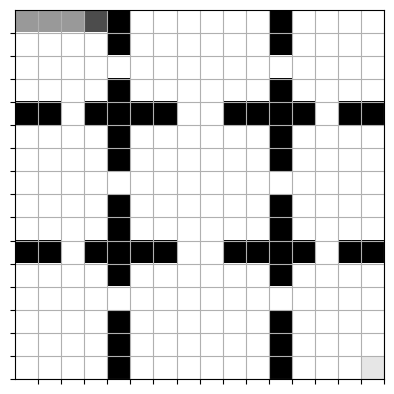

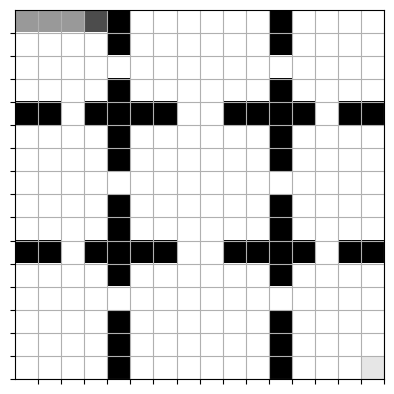

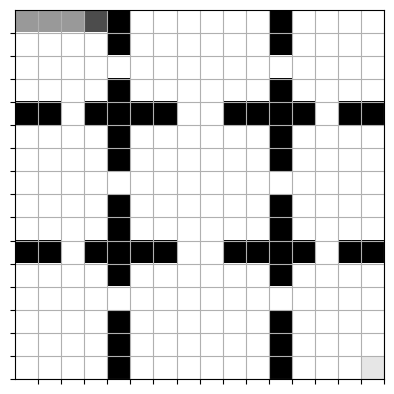

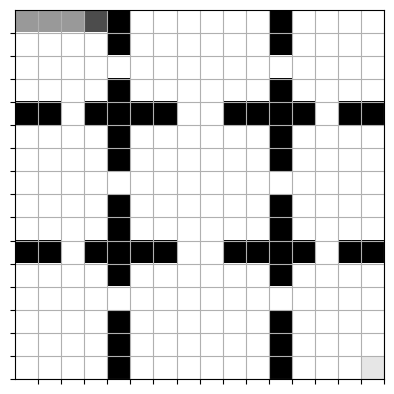

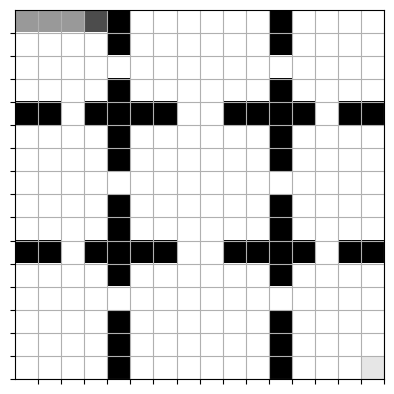

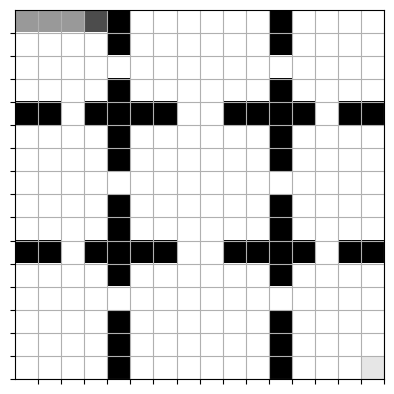

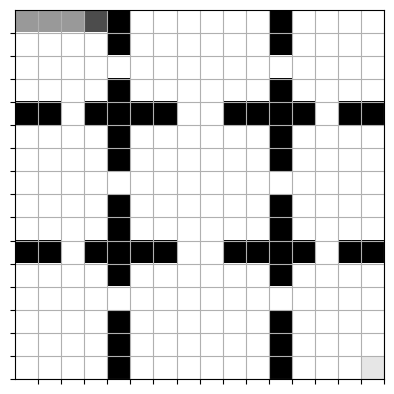

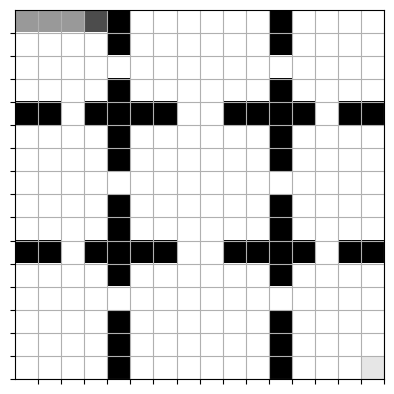

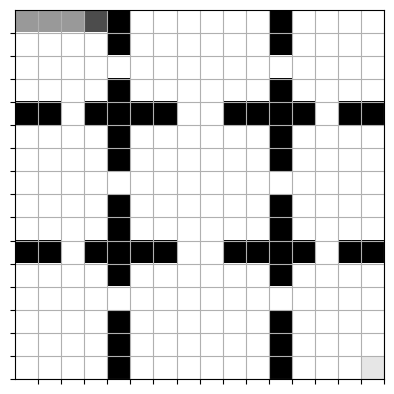

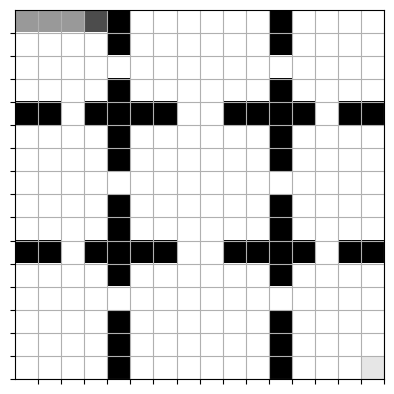

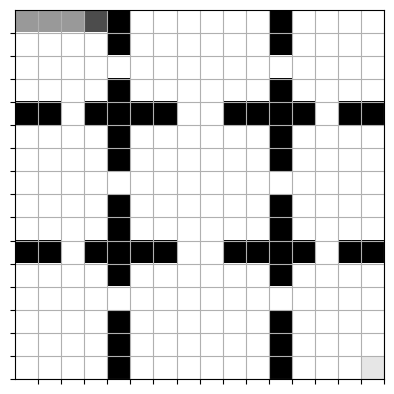

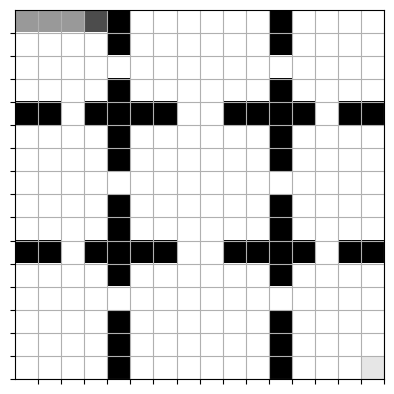

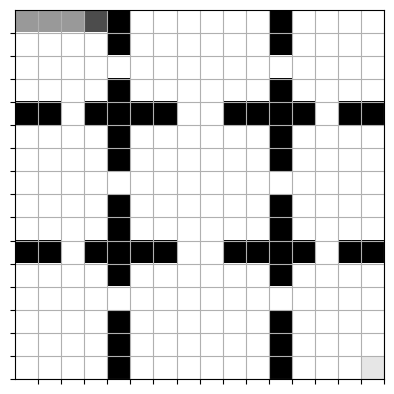

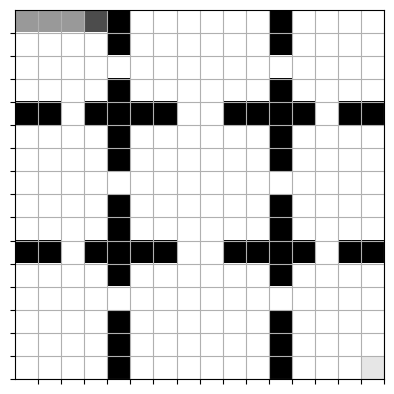

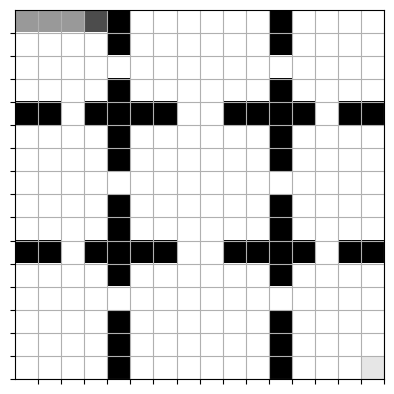

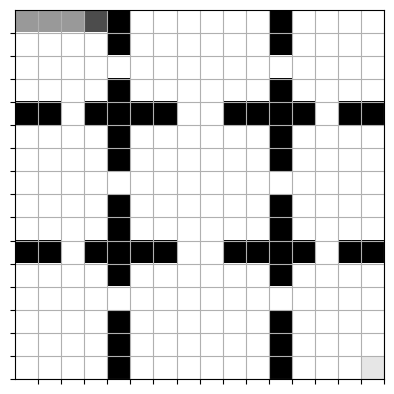

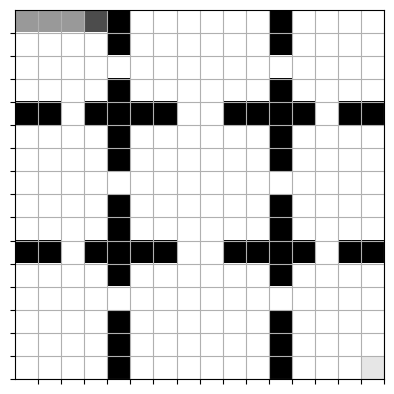

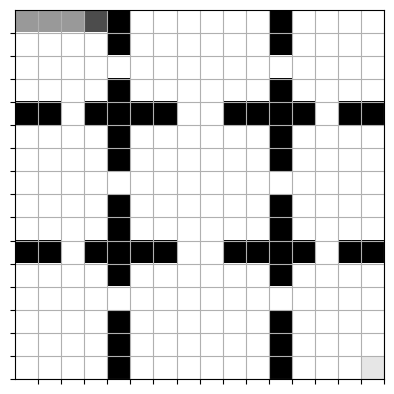

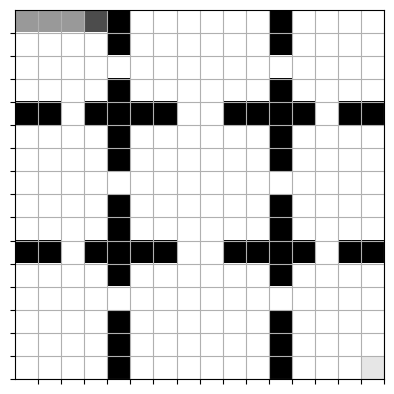

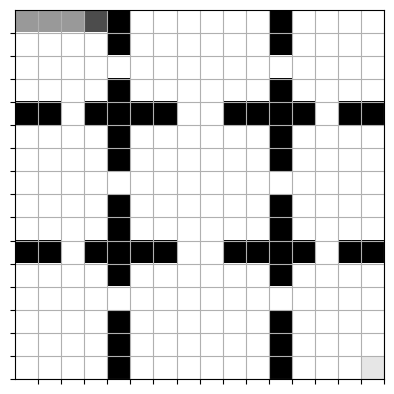

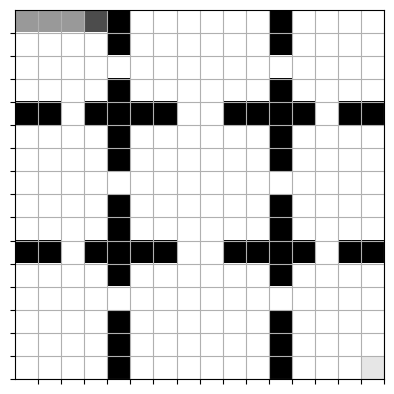

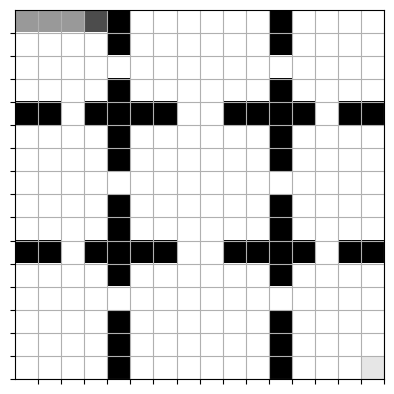

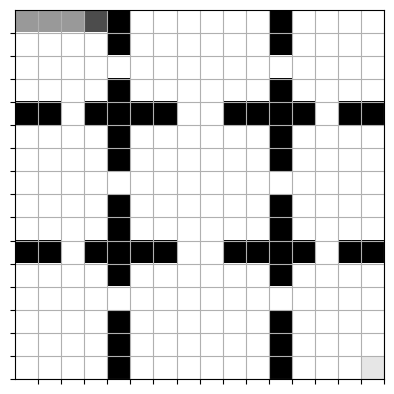

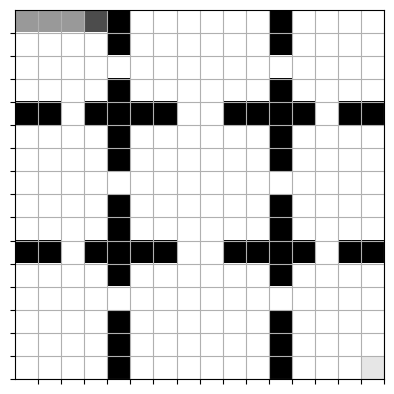

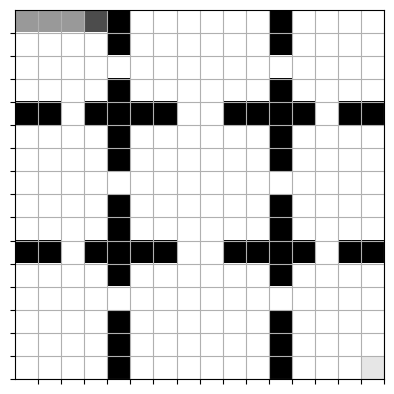

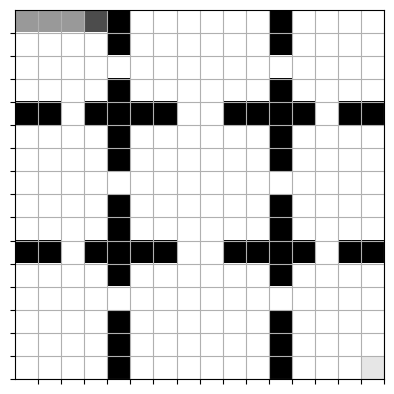

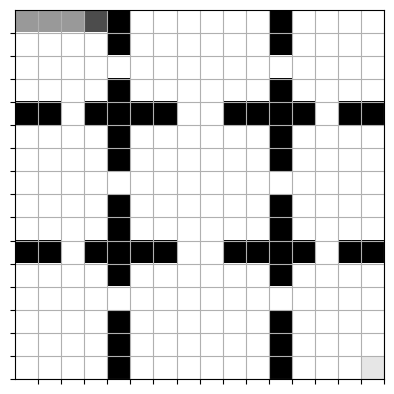

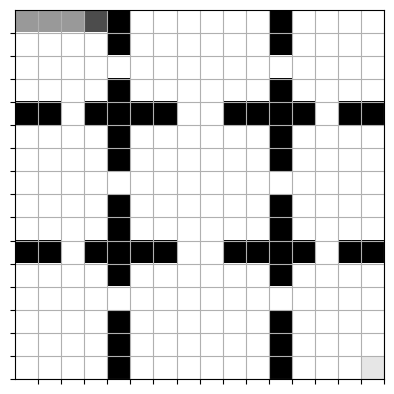

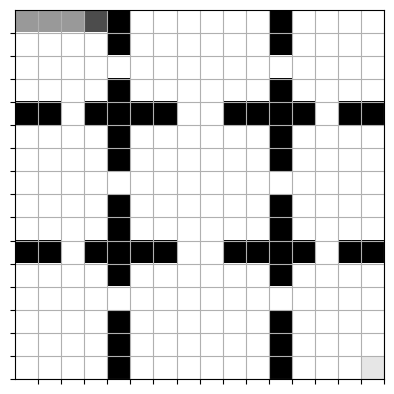

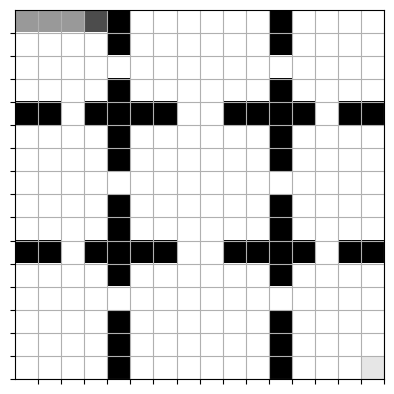

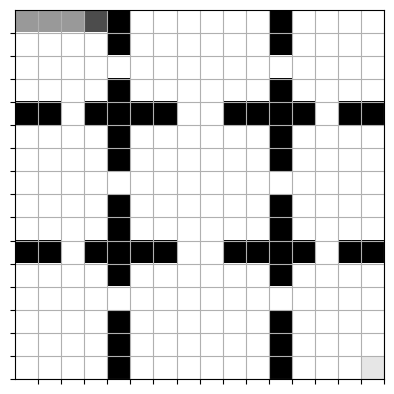

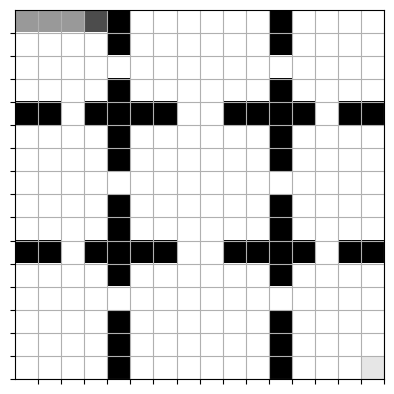

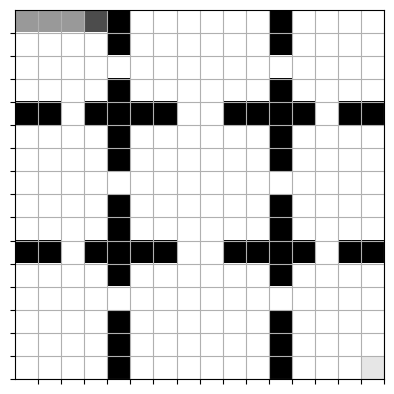

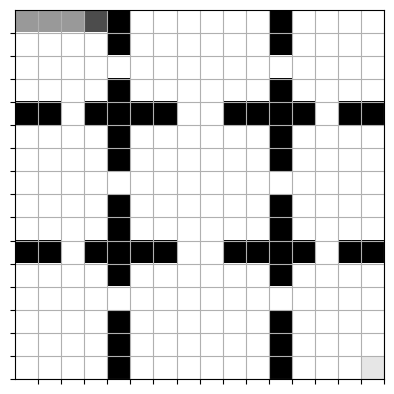

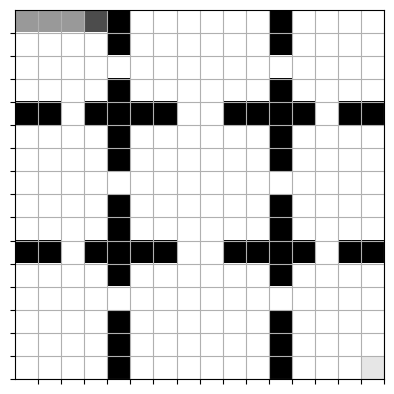

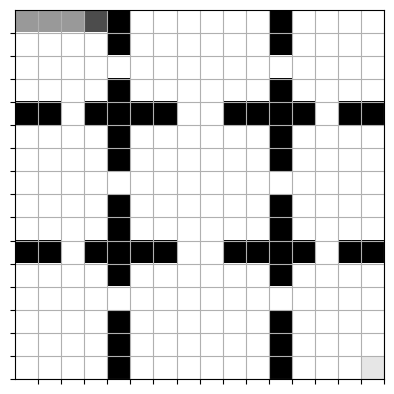

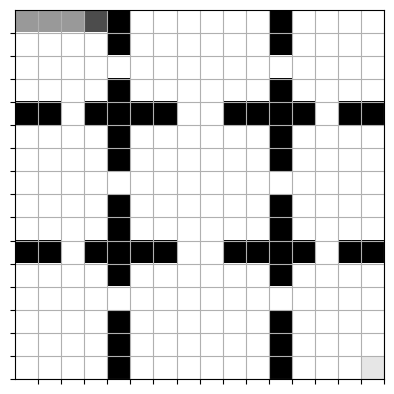

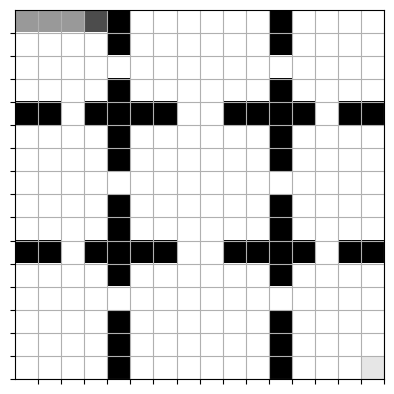

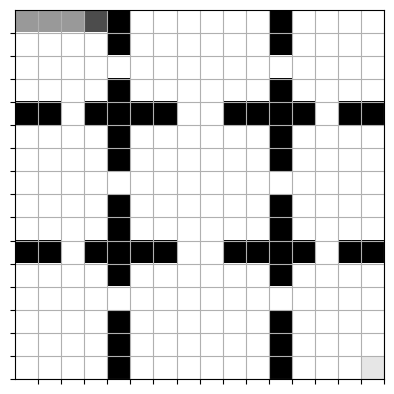

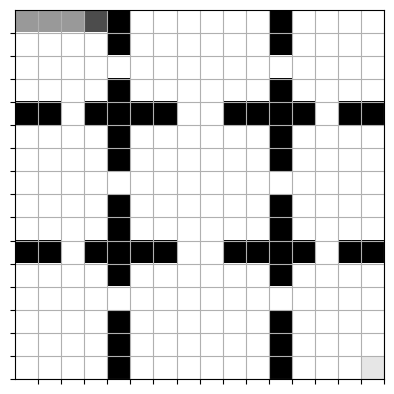

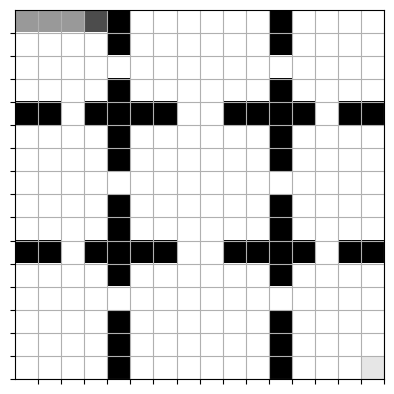

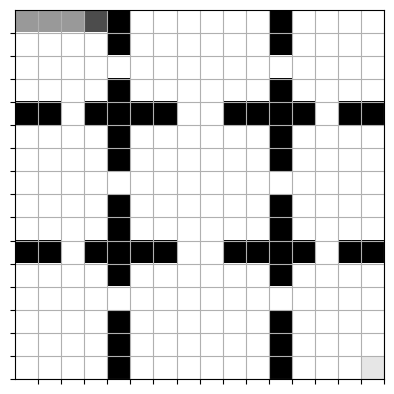

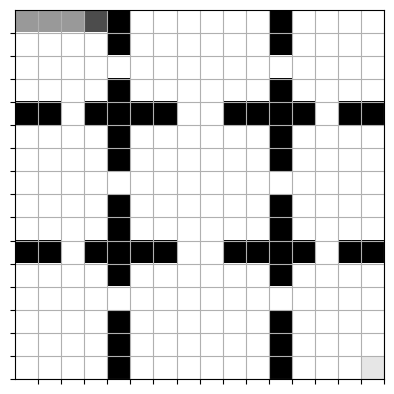

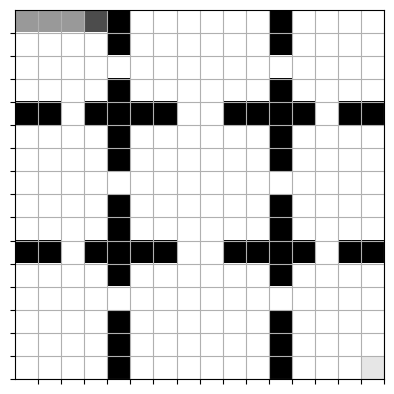

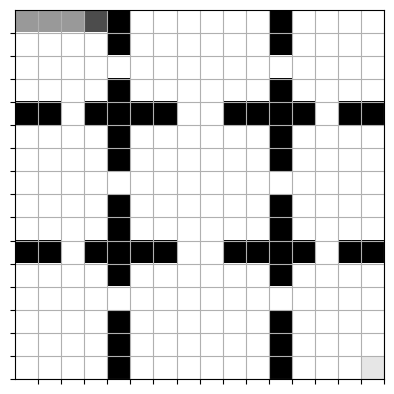

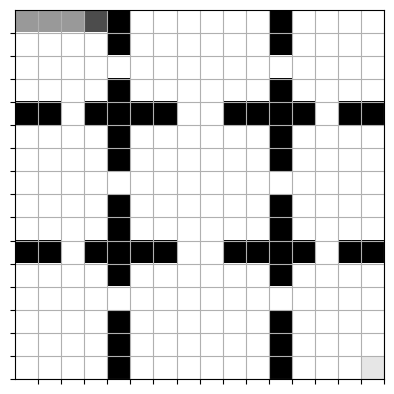

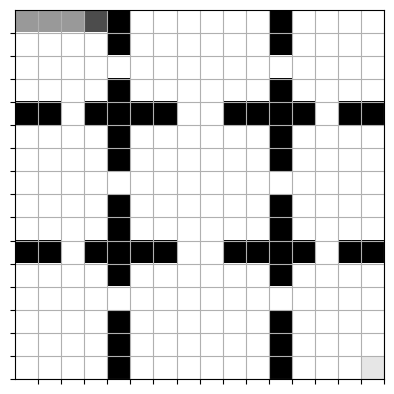

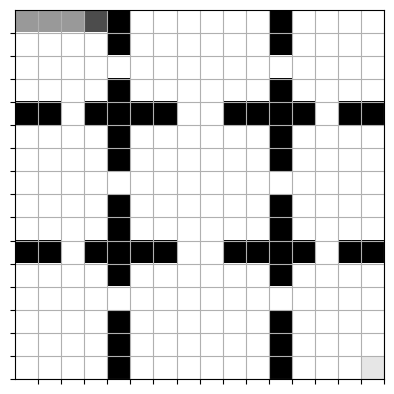

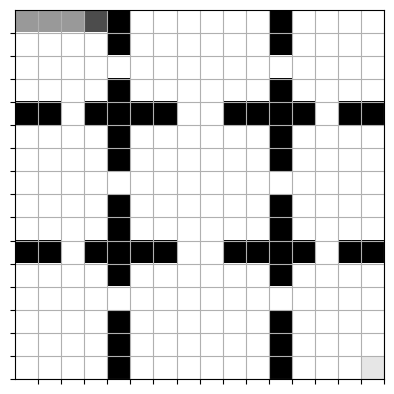

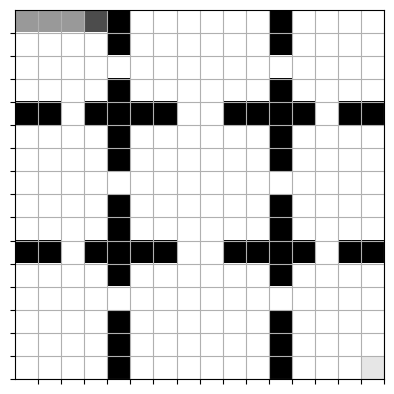

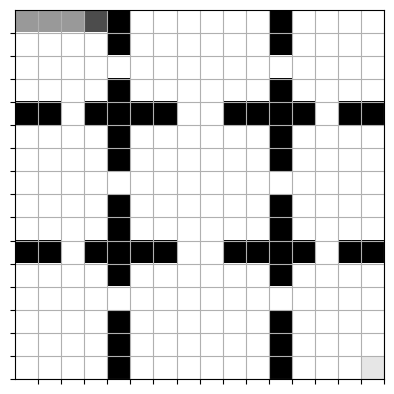

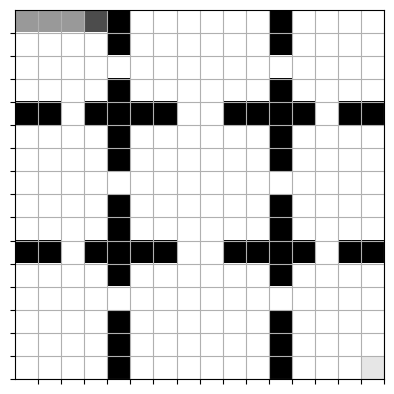

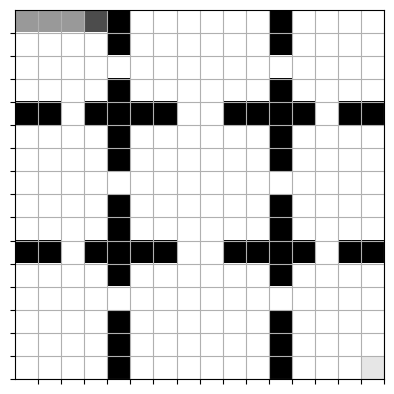

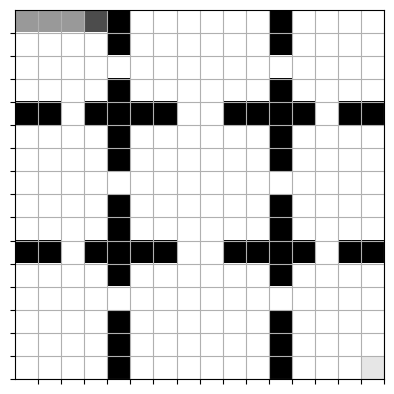

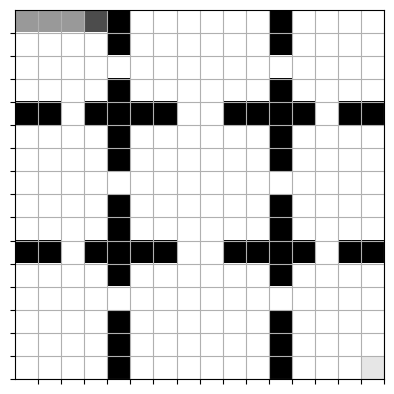

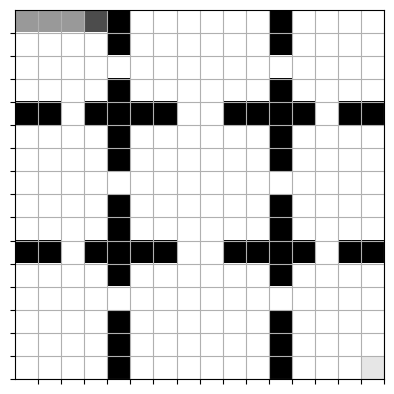

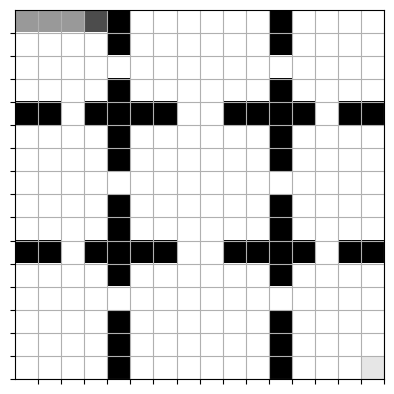

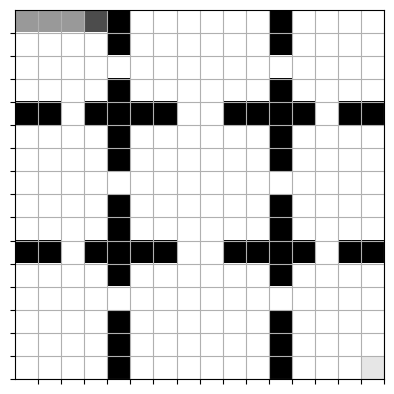

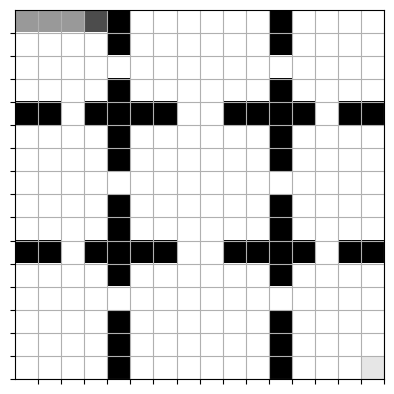

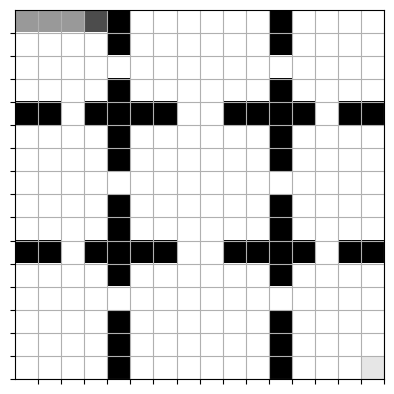

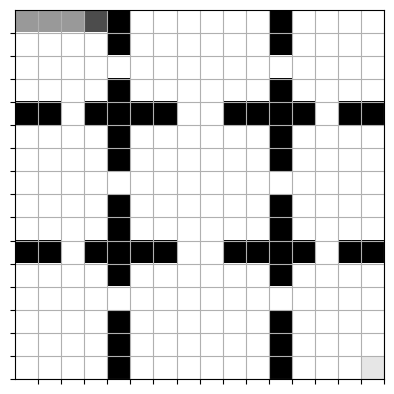

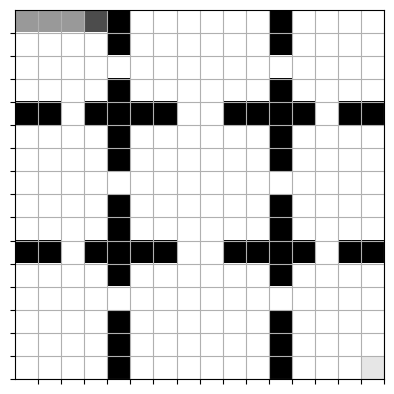

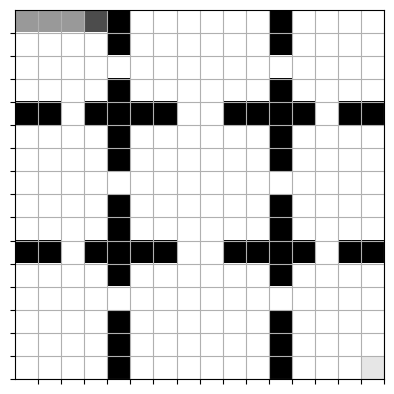

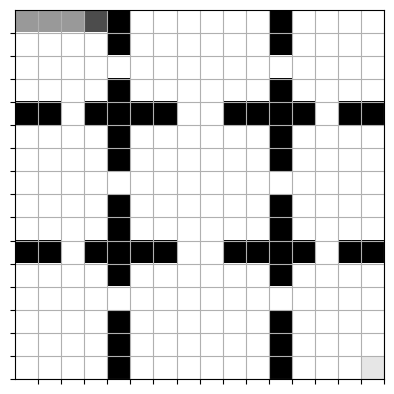

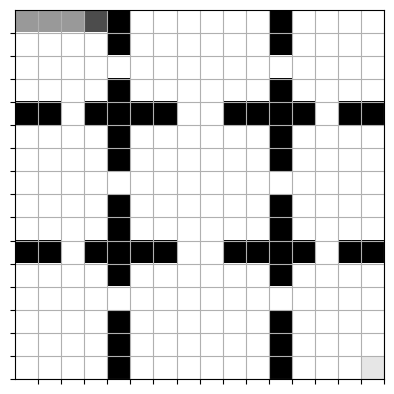

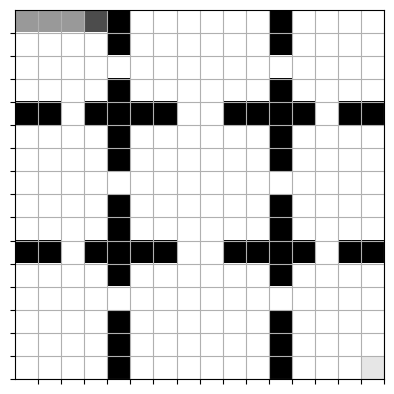

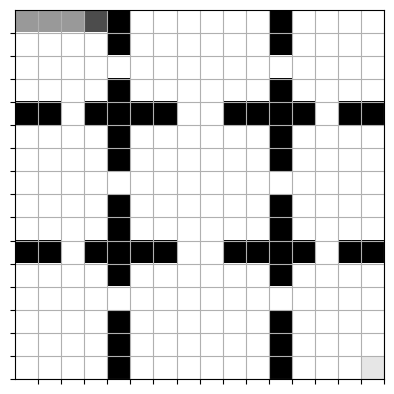

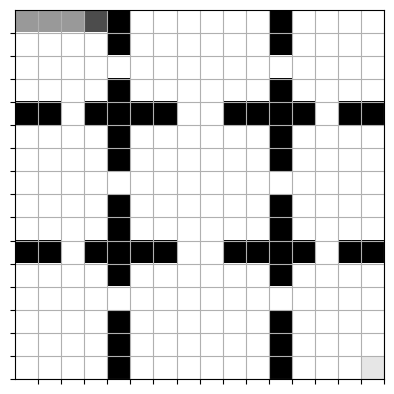

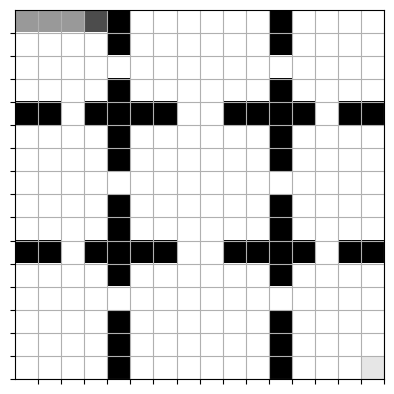

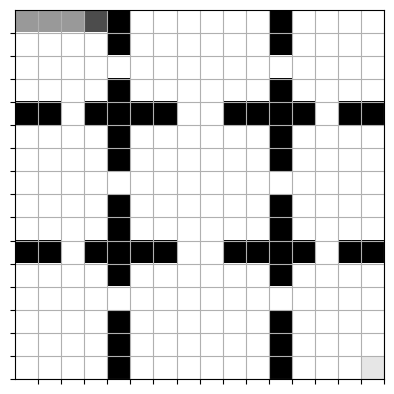

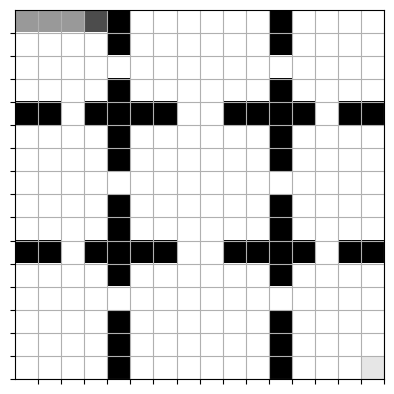

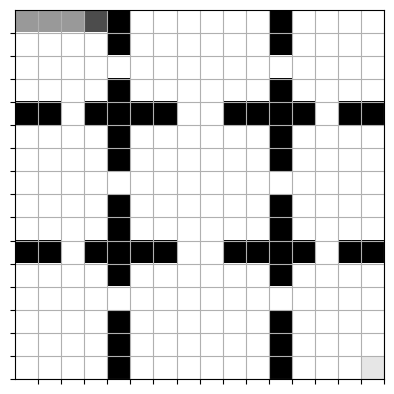

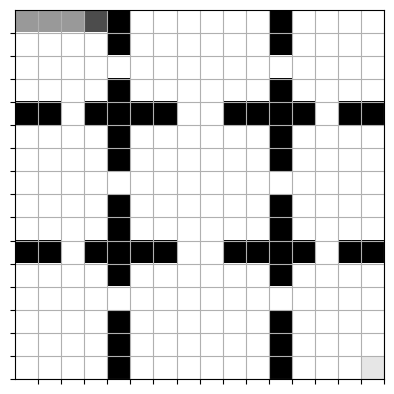

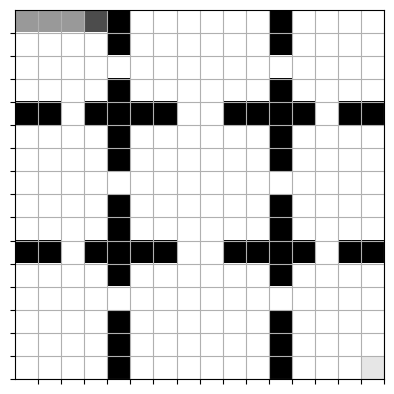

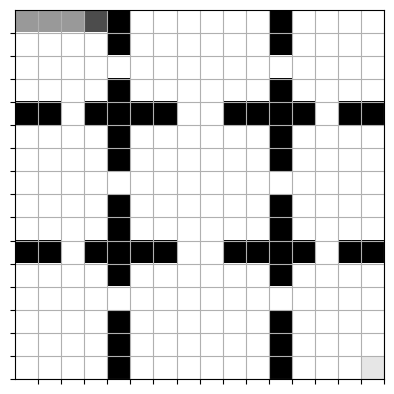

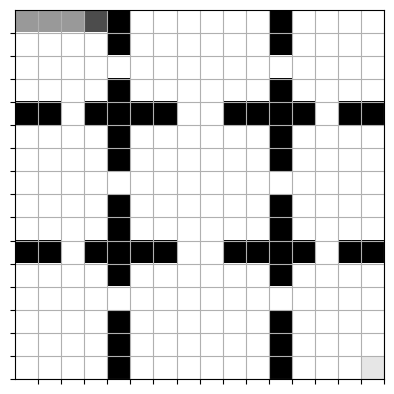

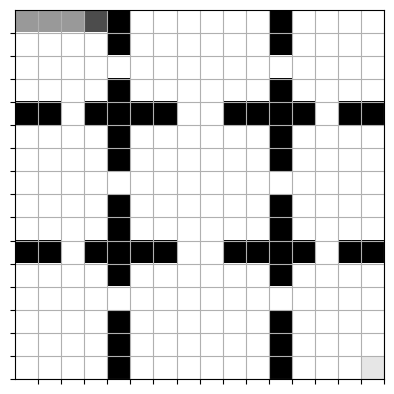

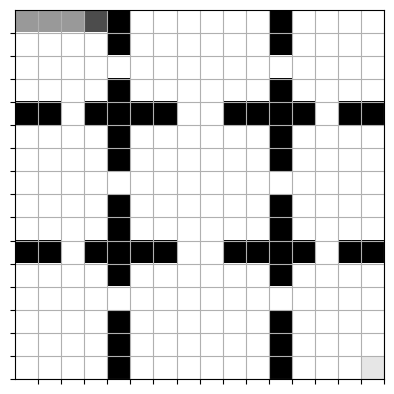

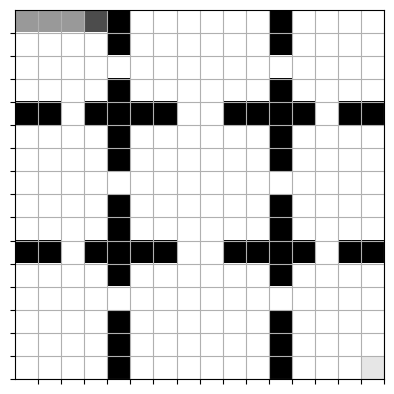

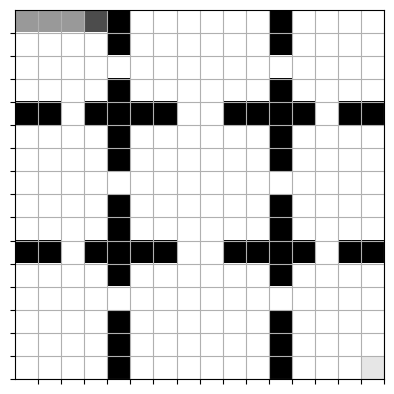

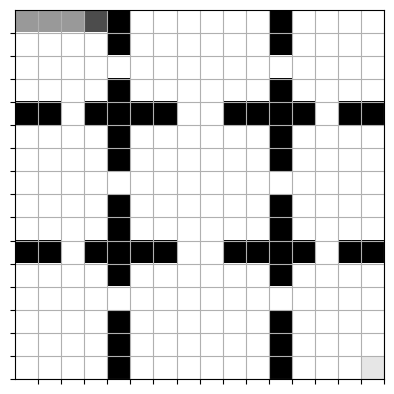

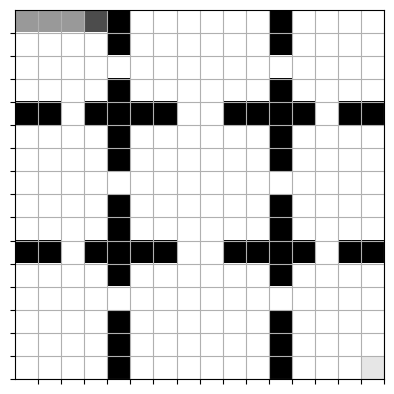

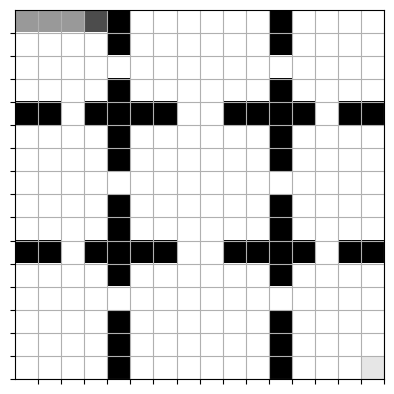

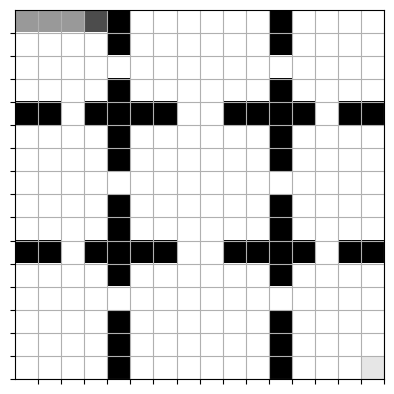

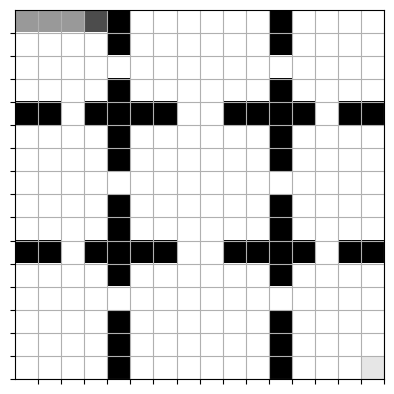

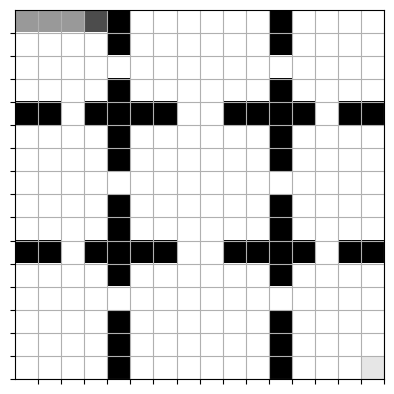

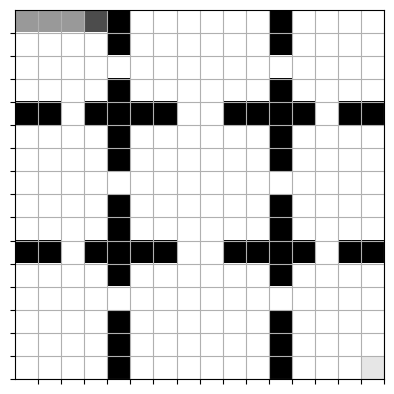

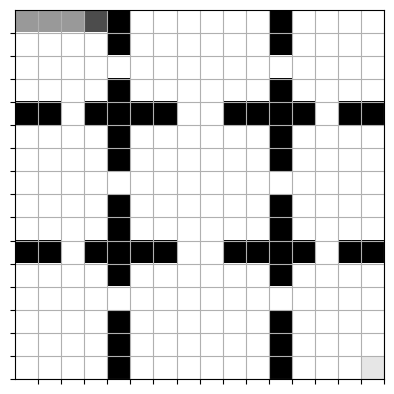

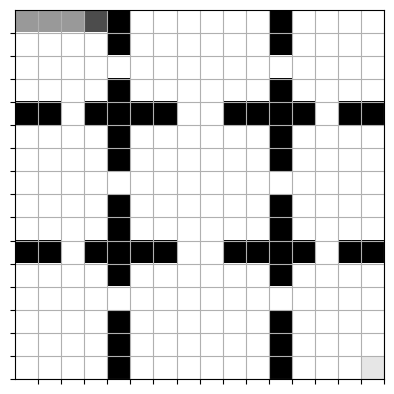

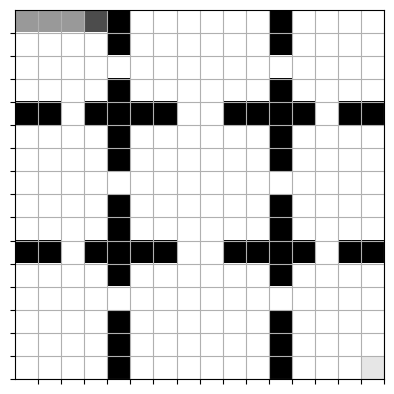

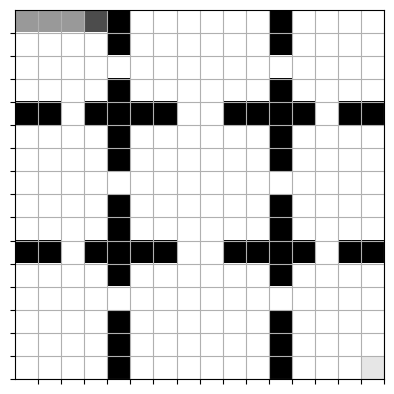

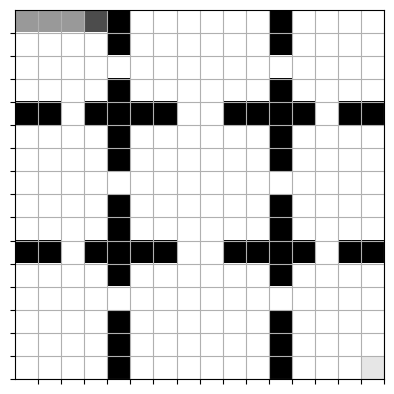

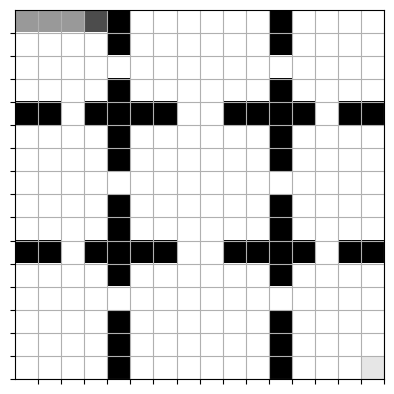

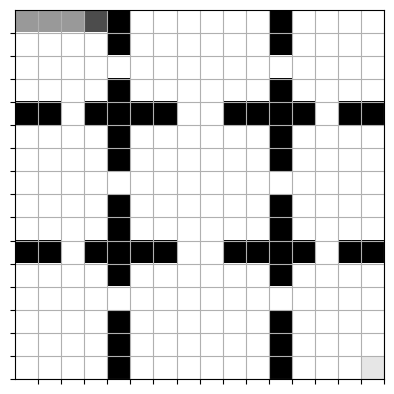

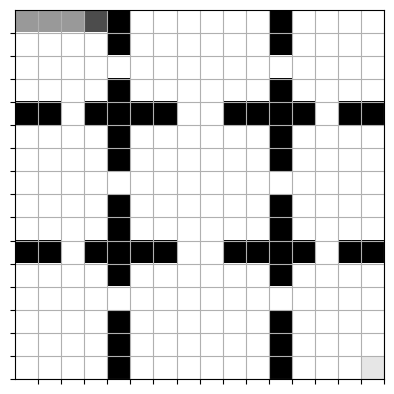

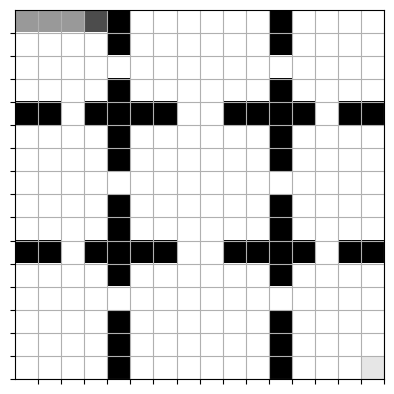

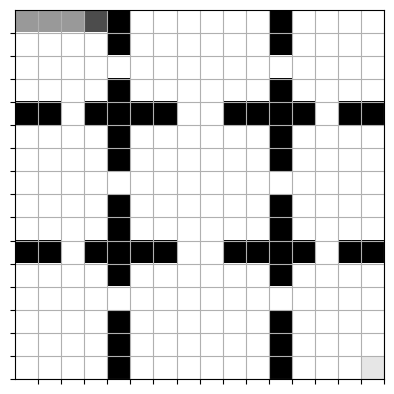

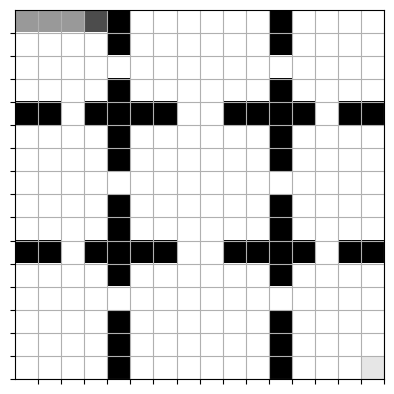

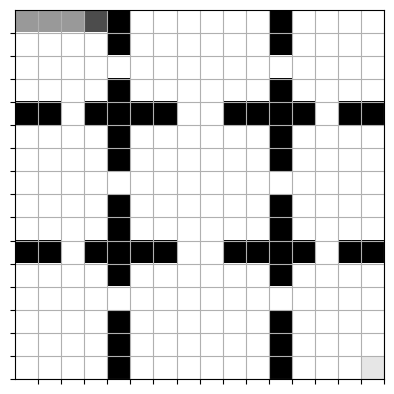

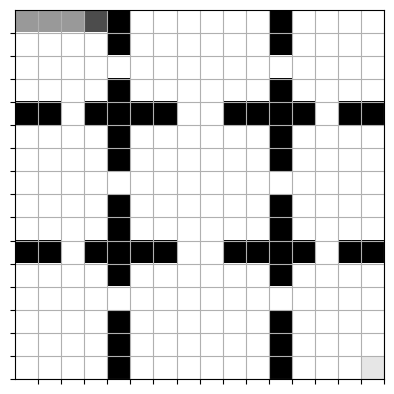

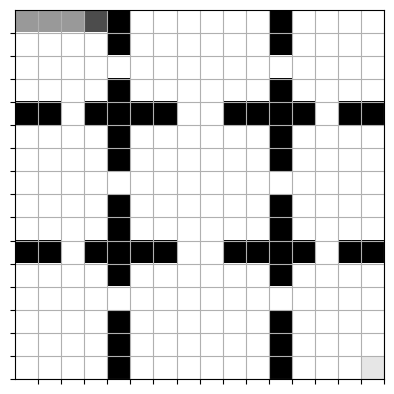

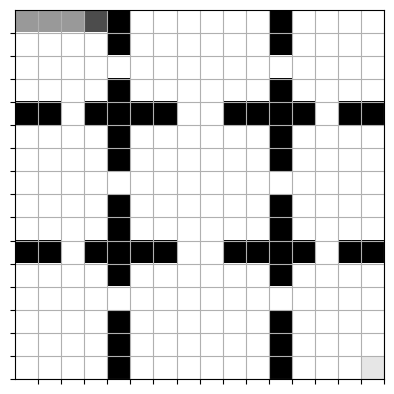

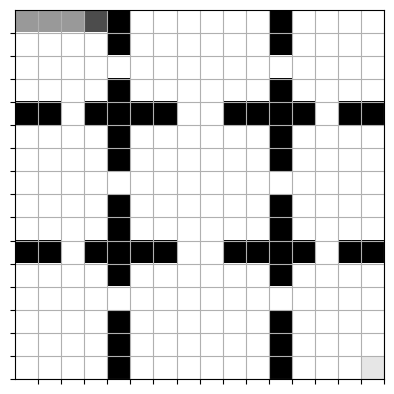

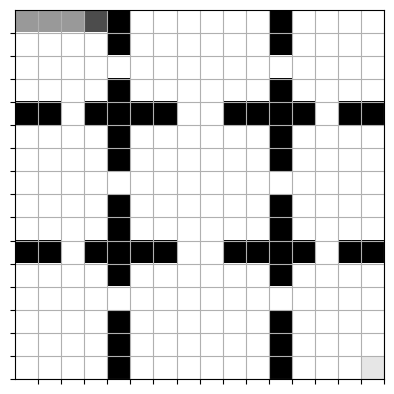

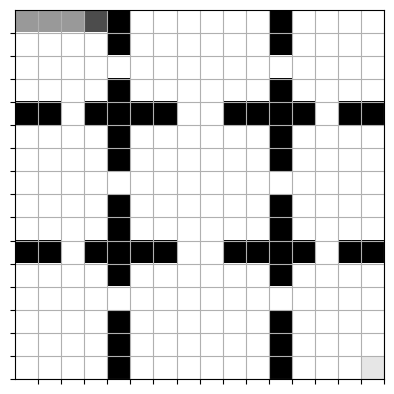

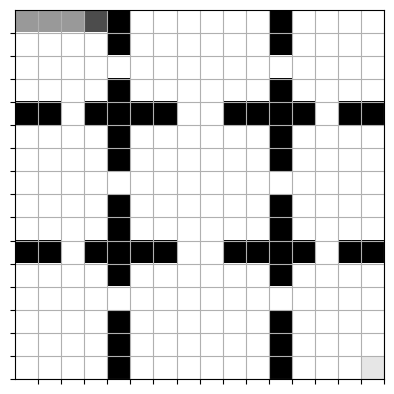

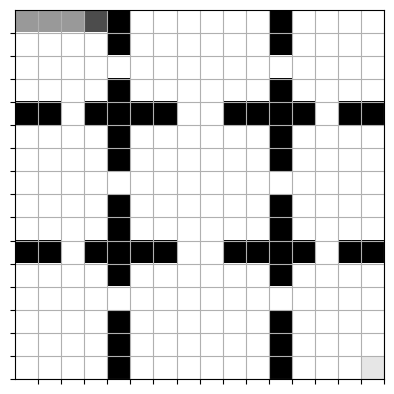

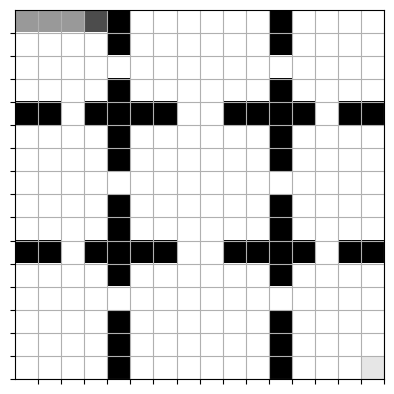

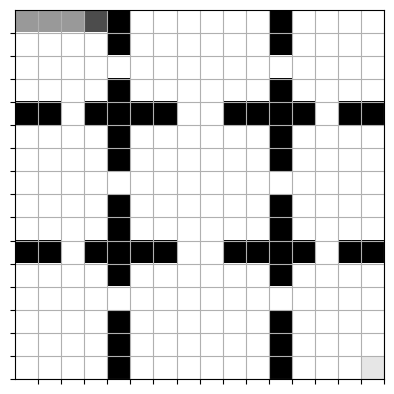

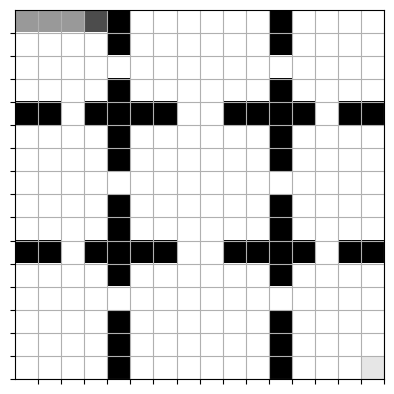

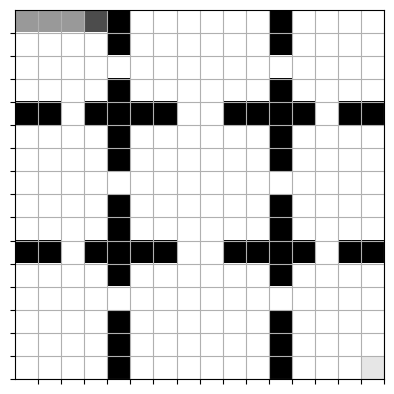

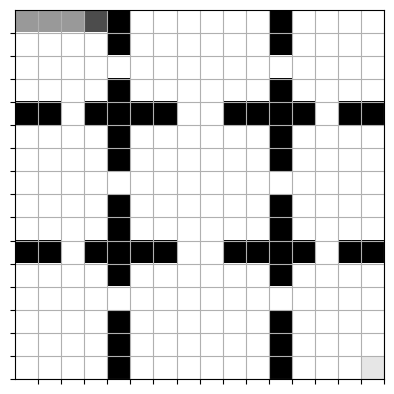

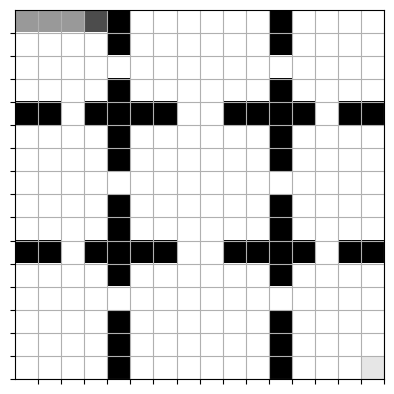

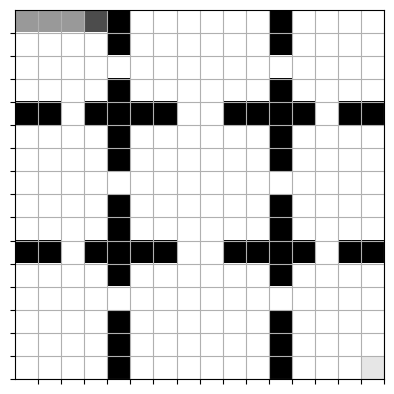

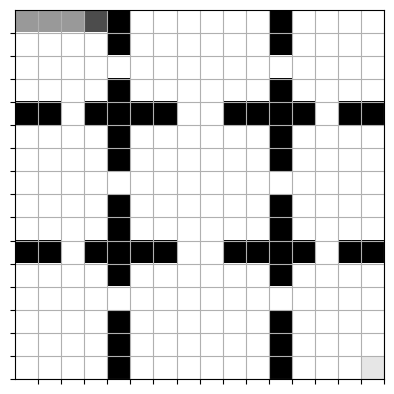

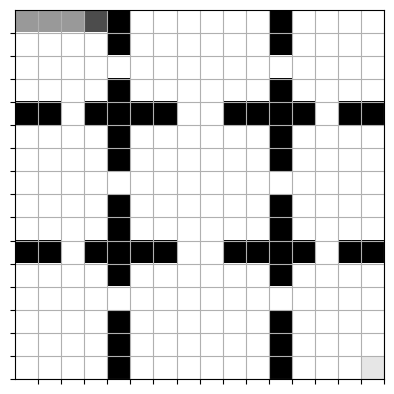

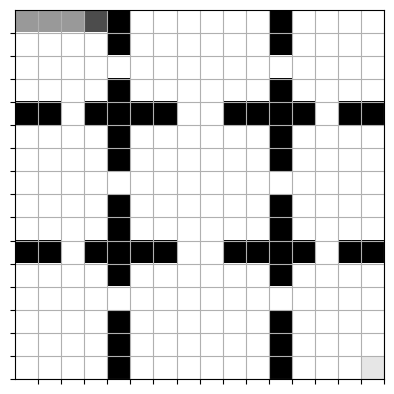

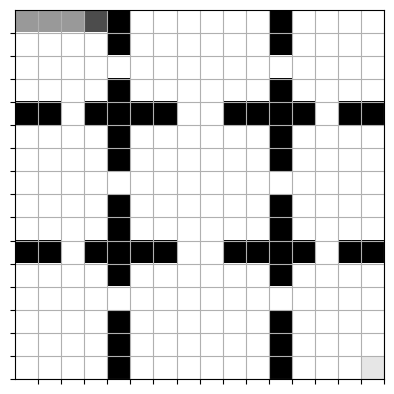

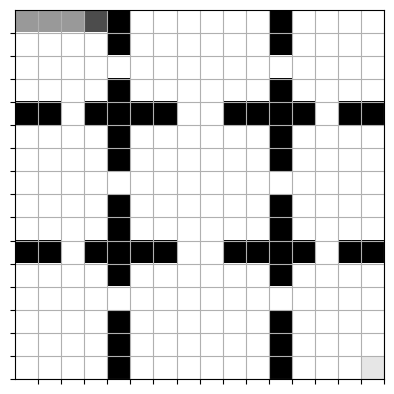

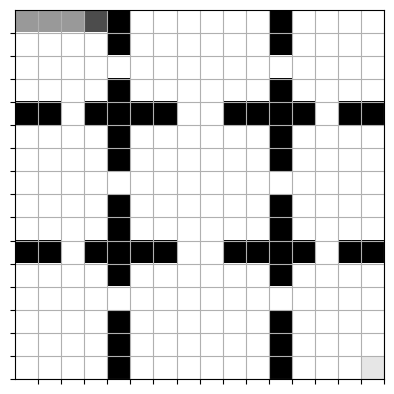

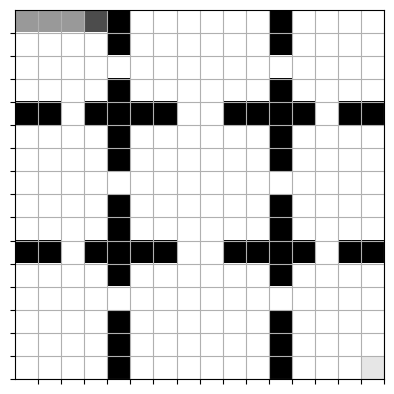

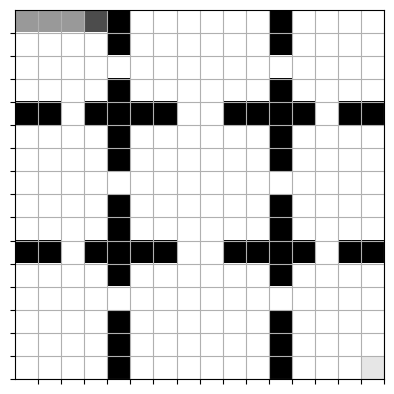

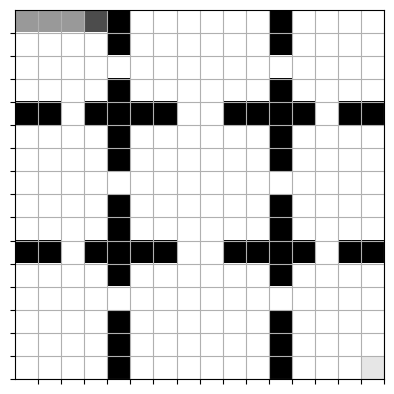

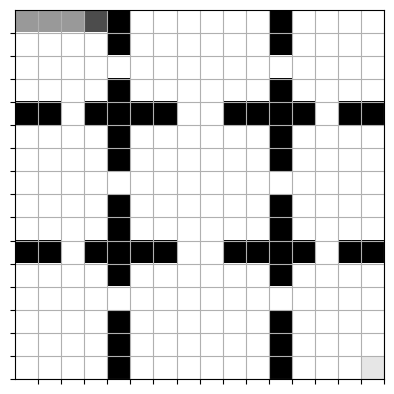

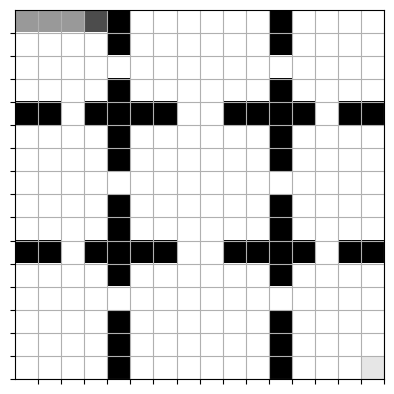

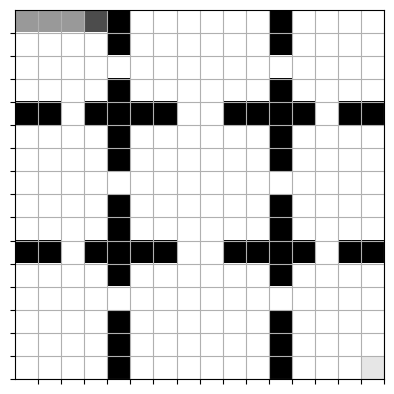

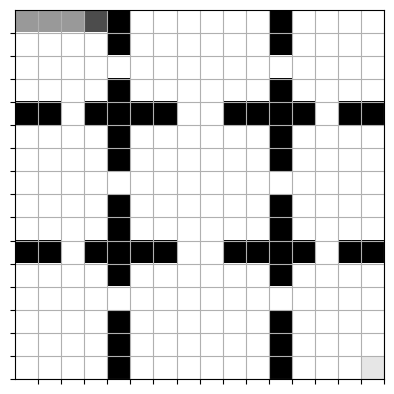

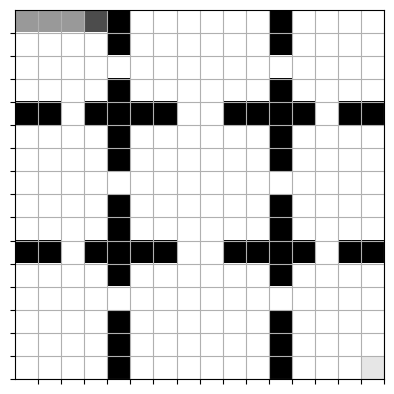

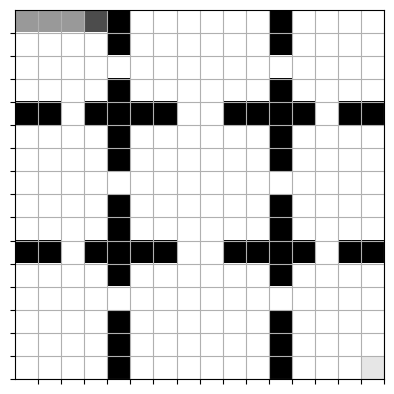

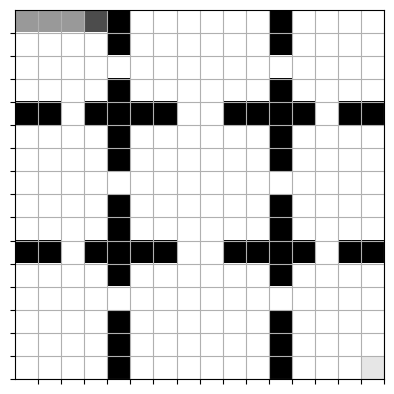

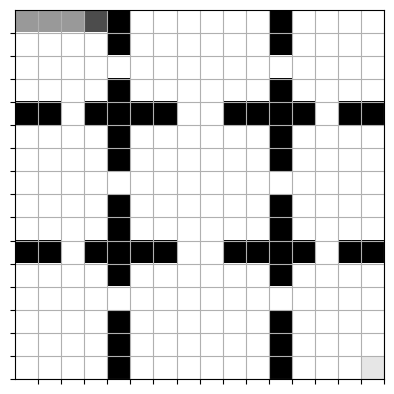

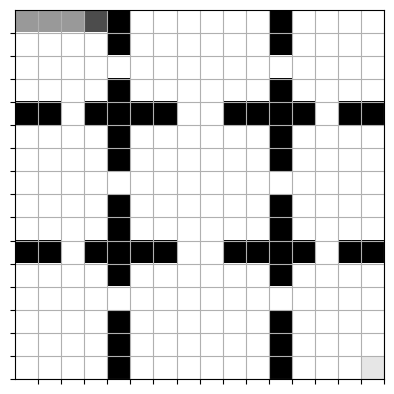

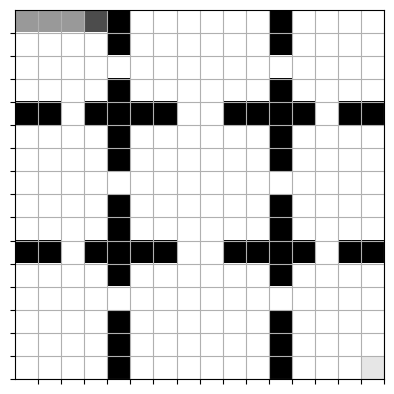

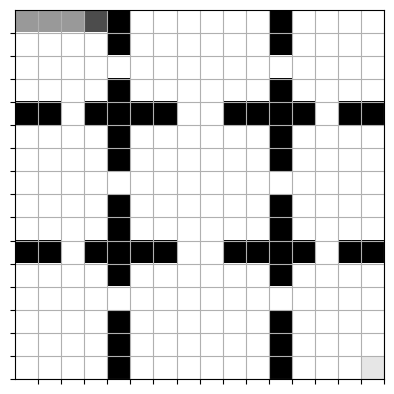

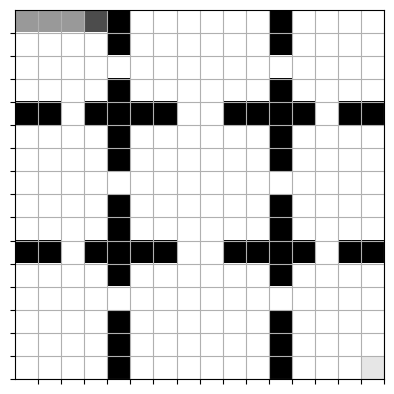

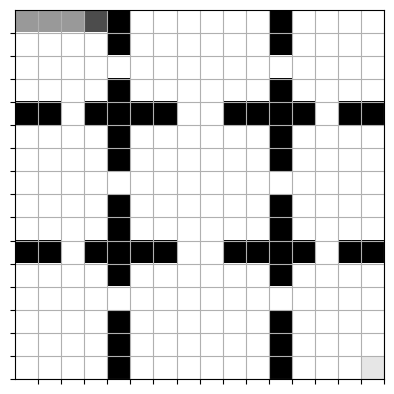

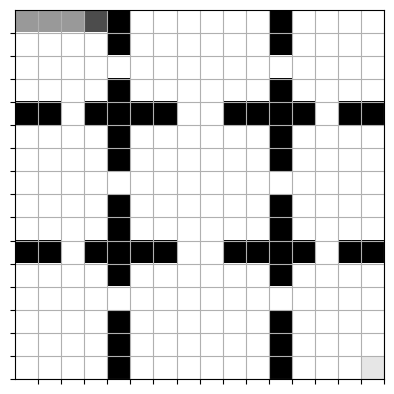

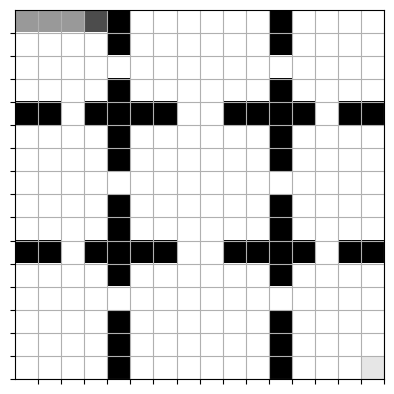

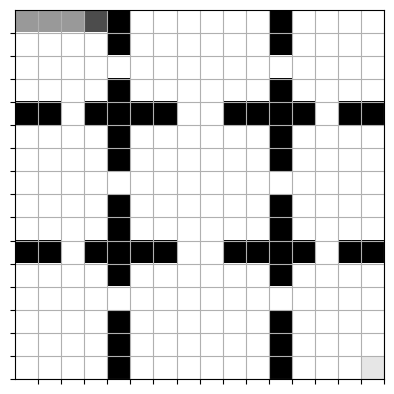

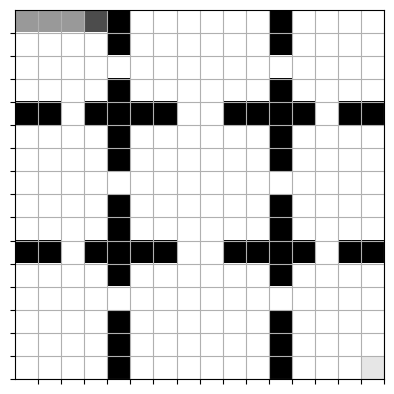

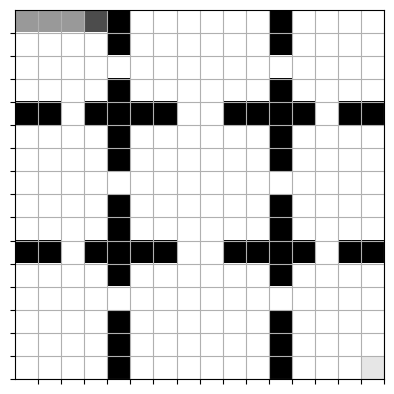

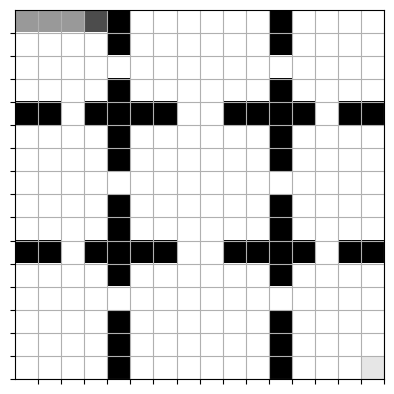

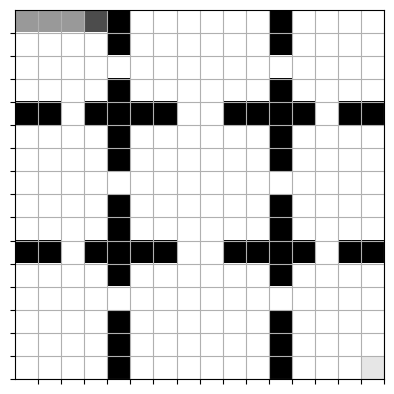

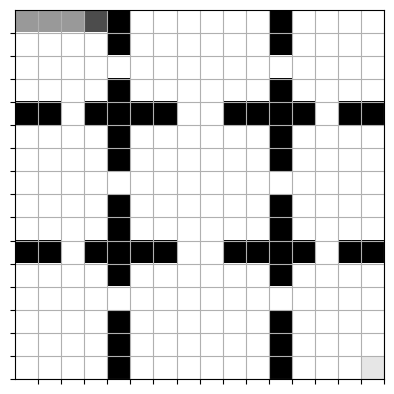

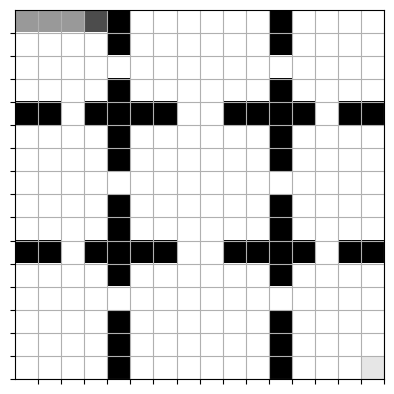

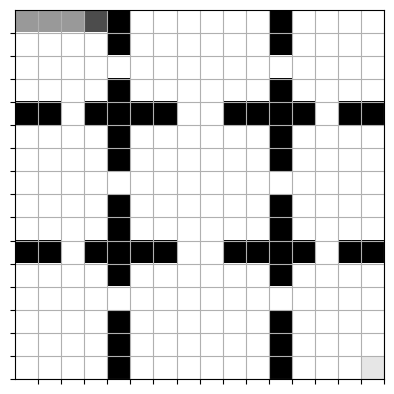

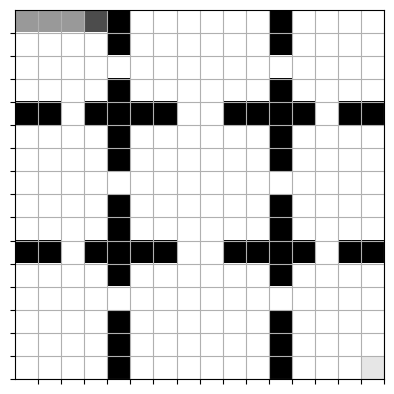

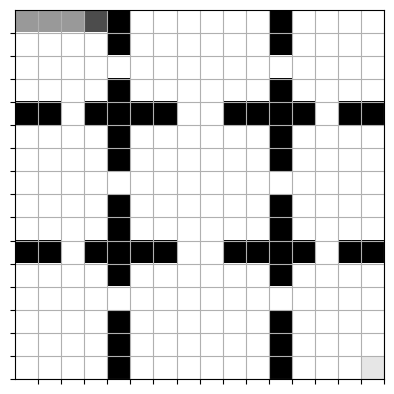

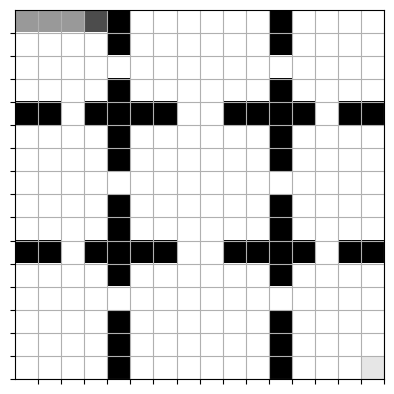

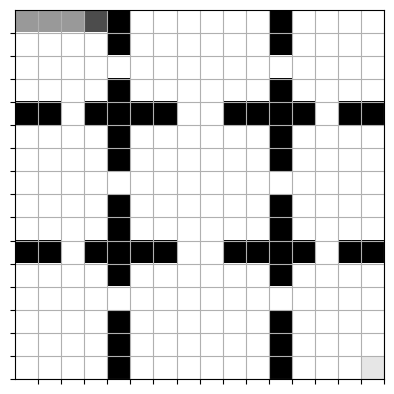

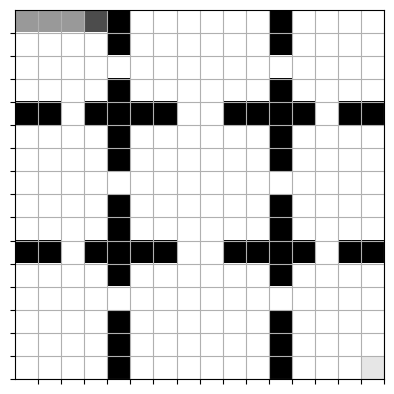

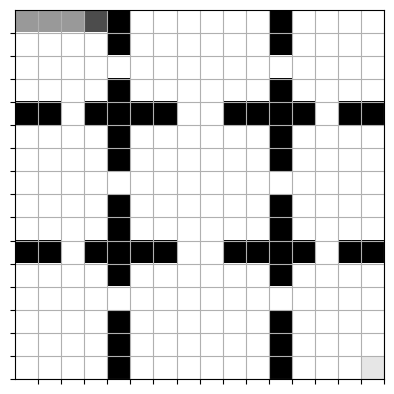

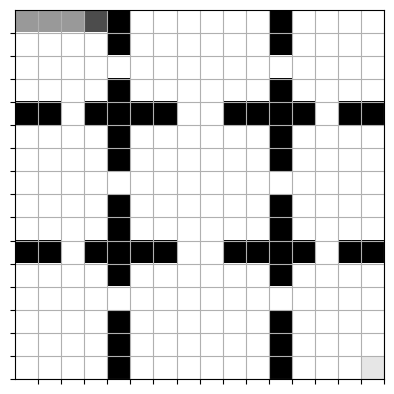

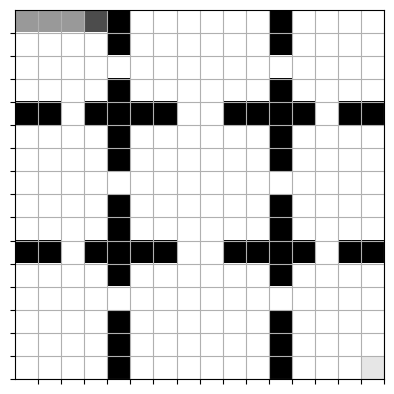

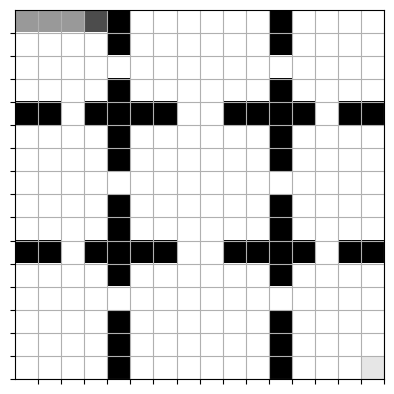

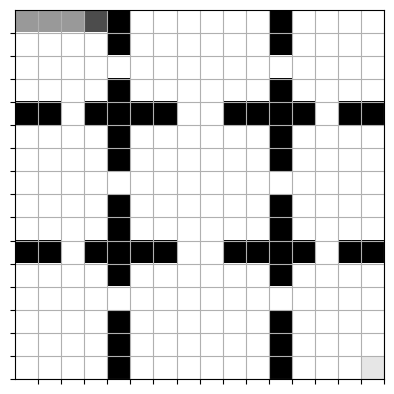

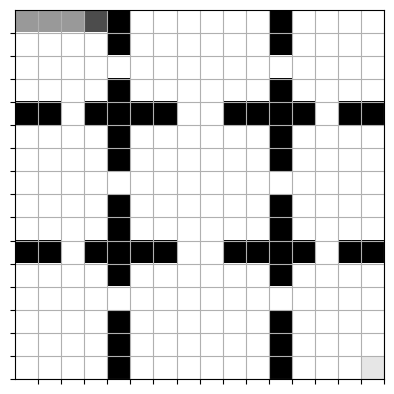

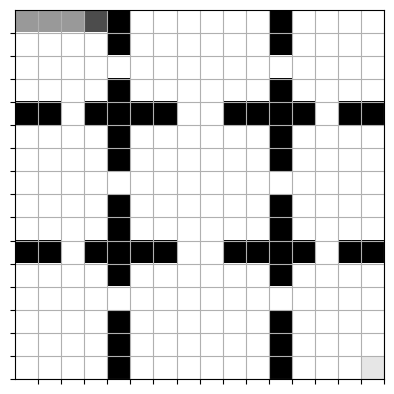

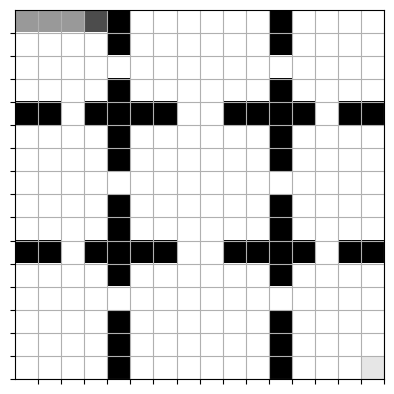

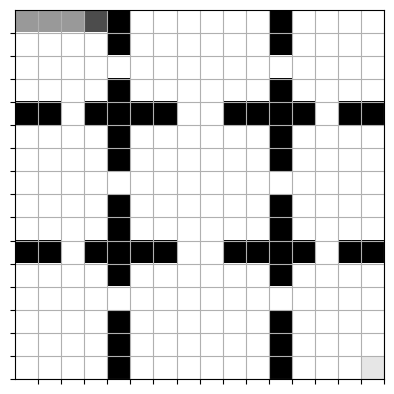

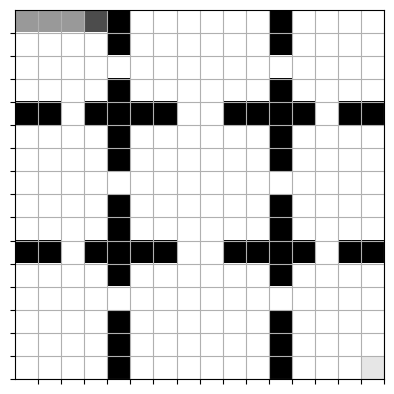

Error in callback <function flush_figures at 0x789ad08912d0> (for post_execute):


KeyboardInterrupt: ignored

In [174]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent_off.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)